In [232]:
import numpy as np
import pandas as pd
import datetime
from datetime import date, datetime
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from lightgbm import LGBMClassifier,LGBMRegressor
from sklearn.model_selection import StratifiedKFold,KFold
from sklearn.metrics import mean_squared_error,confusion_matrix,classification_report,roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer
from scipy import sparse
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import roc_curve, precision_recall_curve
import warnings

warnings.filterwarnings('ignore')
np.random.seed(4590)


In [4]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

def get_new_columns(name,aggs):
    return [name + '_' + k + '_' + agg for k in aggs.keys() for agg in aggs[k]]

In [11]:
df_train = pd.read_csv('../input/train.csv')
df_test = pd.read_csv('../input/test.csv')
df_hist_trans = pd.read_csv('../input/historical_transactions.csv',parse_dates=['purchase_date'])
df_new_merchant_trans = pd.read_csv('../input/new_merchant_transactions.csv',parse_dates=['purchase_date'])

df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)
df_hist_trans = reduce_mem_usage(df_hist_trans)
df_new_merchant_trans = reduce_mem_usage(df_new_merchant_trans)
gc.collect()

Mem. usage decreased to  4.04 Mb (56.2% reduction)
Mem. usage decreased to  2.24 Mb (52.5% reduction)
Mem. usage decreased to 1749.11 Mb (43.7% reduction)
Mem. usage decreased to 114.20 Mb (45.5% reduction)


405

## purchase_date

In [13]:
max_date=df_new_merchant_trans['purchase_date'].max()

for df in [df_hist_trans,df_new_merchant_trans]:
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])
    df['year'] = df['purchase_date'].dt.year
    df['weekofyear'] = df['purchase_date'].dt.weekofyear
    df['month'] = df['purchase_date'].dt.month
    df['day'] = df['purchase_date'].dt.day
    
    df['dayofweek'] = df['purchase_date'].dt.dayofweek
    df['weekend'] = (df.purchase_date.dt.weekday >=5).astype(int)
    df['hour'] = df['purchase_date'].dt.hour
    df['authorized_flag'] = df['authorized_flag'].map({'Y':1, 'N':0})
    df['category_1'] = df['category_1'].map({'Y':1, 'N':0}) 
    df['month_diff'] = ((max_date - df['purchase_date']).dt.days)//30
    df['month_diff'] += df['month_lag']
#     df['authorized_flag_purchase_amount'] = df.apply(lambda x: x['purchase_amount'] \
#                             if x['authorized_flag']>0 else 0 ,axis=1)
    
#     df['unauthorized_flag_purchase_amount'] = df.apply(lambda x: x['purchase_amount'] \
#                             if x['authorized_flag']<1 else 0 ,axis=1)


In [29]:
df_hist_trans.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,...,dayofweek_mean,year_mean,subsector_id_mean,merchant_id_mean,merchant_category_id_mean,category_1_mean,category_2_mean,category_3_mean,month_lag_mean,card_id_mean
0,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_e020e9b302,-8,-0.703331,...,1.755823,0.102926,-0.235840,-0.680620,-0.436136,0.07154,0.14957,0.361926,-0.252381,-0.726847
1,1,C_ID_4e6213e9bc,88,0,0,A,367,M_ID_86ec983688,-7,-0.733128,...,-0.078892,0.102926,-0.317189,-0.645051,-0.321717,0.07154,0.14957,0.361926,-0.061212,-0.726847
2,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_979ed661fc,-6,-0.720386,...,-0.207237,0.102926,-0.235840,-0.710140,-0.436136,0.07154,0.14957,0.361926,-0.231082,-0.726847
3,1,C_ID_4e6213e9bc,88,0,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,...,-0.078892,0.102926,2.180532,-0.734185,-0.235195,0.07154,0.14957,0.361926,-0.183201,-0.726847
4,1,C_ID_4e6213e9bc,88,0,0,A,80,M_ID_e020e9b302,-11,-0.722865,...,-0.156621,0.102926,-0.235840,-0.680620,-0.436136,0.07154,0.14957,0.361926,-0.224293,-0.726847


## agg

In [30]:
def  get_agg_fea(count_df,prefix):
    aggs = {}
    
    for col in ['month','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id',\
                'category_1','category_2','category_3','month_lag','card_id']:
        count_df[col+'_mean'] = count_df.groupby([col])['purchase_amount'].transform('mean')
        aggs[col+'_mean'] = ['mean']
    
    for col in ['month','day','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id']:
        aggs[col] = ['nunique']

    aggs['purchase_amount'] = ['sum','max','min','mean','var']
    aggs['installments'] = ['sum','max','min','mean','var']
    aggs['purchase_date'] = ['max','min']
    aggs['month_lag'] = ['max','min','mean','var']
    # aggs['month_diff'] = ['mean']
    aggs['month_diff'] = ['max','min','mean','var']
    aggs['authorized_flag'] = ['sum', 'mean']
    aggs['weekend'] = ['sum', 'mean']
    aggs['category_1'] = ['sum', 'mean']
    aggs['card_id'] = ['size']

    new_columns = get_new_columns(prefix,aggs)
    count_df_gp = count_df.groupby('card_id').agg(aggs)
    count_df_gp.columns = new_columns
    count_df_gp.reset_index(drop=False,inplace=True)
    count_df_gp['%s_purchase_date_diff'%prefix] = (count_df_gp['%s_purchase_date_max'%prefix] - count_df_gp['%s_purchase_date_min'%prefix]).dt.days
    count_df_gp['%s_purchase_date_average'%prefix] = count_df_gp['%s_purchase_date_diff'%prefix]/count_df_gp['%s_card_id_size'%prefix]
    count_df_gp['%s_purchase_date_uptonow'%prefix] = (max_date - count_df_gp['%s_purchase_date_max'%prefix]).dt.days
    count_df_gp['%s_purchase_date_uptomin'%prefix] = (max_date - count_df_gp['%s_purchase_date_min'%prefix]).dt.days
    
    return count_df_gp



hist_count_df=get_agg_fea(df_hist_trans,'hist')
df_train = df_train.merge(hist_count_df,on='card_id',how='left')
df_test = df_test.merge(hist_count_df,on='card_id',how='left')
del hist_count_df
gc.collect()
new_count_df = get_agg_fea(df_new_merchant_trans,'new_hist')
df_train = df_train.merge(new_count_df,on='card_id',how='left')
df_test = df_test.merge(new_count_df,on='card_id',how='left')
del new_count_df
gc.collect()

28

## first_active_month

In [32]:
for df in [df_train,df_test]:
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['first_active_monthtonoew'] = ( max_date-pd.to_datetime(df['first_active_month'])).dt.days
    df['dayofweek'] = df['first_active_month'].dt.dayofweek
    df['weekofyear'] = df['first_active_month'].dt.weekofyear
    df['month'] = df['first_active_month'].dt.month
    df['elapsed_time'] = (max_date- df['first_active_month']).dt.days
    df['hist_first_buy'] = (df['hist_purchase_date_min'] - df['first_active_month']).dt.days
    df['new_hist_first_buy'] = (df['new_hist_purchase_date_min'] - df['first_active_month']).dt.days
    df['hist_sleep_day'] = df['first_active_monthtonoew'] - df['hist_day_nunique']
    df['new_sleep_day'] = df['first_active_monthtonoew'] - df['new_hist_day_nunique']
    df['total_sleep_day'] = df['hist_sleep_day'] + df['new_sleep_day'] 
    df['diff_sleep_day'] = df['hist_sleep_day'] - df['new_sleep_day']
    
    for f in ['hist_purchase_date_max','hist_purchase_date_min','new_hist_purchase_date_max','new_hist_purchase_date_min']:
        df[f] = df[f].astype(np.int64) * 1e-9
    
    df['purchase_amount_total'] = df['new_hist_purchase_amount_sum']+df['hist_purchase_amount_sum']
    df['purchase_amount_diff'] = df['new_hist_purchase_amount_sum']-df['hist_purchase_amount_sum']
    df['purchase_amount_rate'] = df['purchase_amount_diff']/df['hist_purchase_amount_sum']

## new与hist组合

In [33]:
new_hist_feature=[ i for i in df_train  if 'new_hist' in i]

for fea in new_hist_feature:
    if fea in ['new_hist_purchase_date_max','new_hist_purchase_date_min']:
        continue
    print(fea)
    new_fea=fea
    hist_fea=fea.replace("new_hist",'hist')
    df_train[new_fea+"_add_"+hist_fea]=df_train.apply(lambda x: x[new_fea]+x[hist_fea],axis=1)
    df_test[new_fea+"_add_"+hist_fea]=df_test.apply(lambda x: x[new_fea]+x[hist_fea],axis=1)
    df_train[new_fea+"_-_"+hist_fea]=df_train.apply(lambda x: x[new_fea]-x[hist_fea],axis=1)
    df_test[new_fea+"_-_"+hist_fea]=df_test.apply(lambda x: x[new_fea]-x[hist_fea],axis=1)
    df_train[new_fea+"_/_"+hist_fea]=df_train.apply(lambda x: x[new_fea]/(abs(x[hist_fea])+0.01),axis=1)
    df_test[new_fea+"_/_"+hist_fea]=df_test.apply(lambda x: x[new_fea]/(abs(x[hist_fea])+0.01),axis=1)

new_hist_weekofyear_nunique
new_hist_month_diff_max
new_hist_month_diff_min
new_hist_month_diff_mean
new_hist_month_diff_var
new_hist_category_1_sum
new_hist_category_1_mean
new_hist_subsector_id_mean_mean
new_hist_category_2_mean_mean
new_hist_month_mean_mean
new_hist_category_1_mean_mean
new_hist_card_id_mean_mean
new_hist_month_nunique
new_hist_hour_nunique
new_hist_year_mean_mean
new_hist_dayofweek_nunique
new_hist_day_nunique
new_hist_merchant_category_id_mean_mean
new_hist_dayofweek_mean_mean
new_hist_hour_mean_mean
new_hist_merchant_id_mean_mean
new_hist_merchant_id_nunique
new_hist_category_3_mean_mean
new_hist_subsector_id_nunique
new_hist_month_lag_max
new_hist_month_lag_min
new_hist_month_lag_mean
new_hist_month_lag_var
new_hist_authorized_flag_sum
new_hist_authorized_flag_mean
new_hist_weekend_sum
new_hist_weekend_mean
new_hist_installments_sum
new_hist_installments_max
new_hist_installments_min
new_hist_installments_mean
new_hist_installments_var
new_hist_year_nunique
new_

In [34]:
df_train['outliers'] = 0
df_train.loc[df_train['target'] < -30, 'outliers'] = 1
df_train['outliers'].value_counts()

0    199710
1      2207
Name: outliers, dtype: int64

## outliers的CTR特征

In [35]:
def get_data_ctr_fea(tj_data,self_data,items=['feature_1','feature_2','feature_3','new_hist_month_diff_mean',
                                          'hist_month_diff_mean', 'hist_month_diff_max','hist_month_diff_min']):    
    tj_drop_columns=[i for i in  tj_data.columns  if "_ctr" in i]
    print(tj_drop_columns)
    if len(tj_drop_columns)>0:
        tj_data=tj_data.drop(columns=tj_drop_columns)
    
    self_drop_columns=[i for i in  self_data  if "_ctr" in i]
    if len(self_drop_columns)>0:
        print(self_drop_columns)
        self_data.drop(columns=self_drop_columns,inplace=True)
        
    # 单个特征
    for item in items:
        if type(item)==list:
            pr_name="_".join(item)
            merge_columns=item+[pr_name+'_ctr']
        else:
            pr_name=item
            merge_columns=[item,pr_name+'_ctr']
        temp = tj_data.groupby(item, as_index = False)['outliers'].agg({pr_name+'_click':'sum',pr_name+'_count':'count'})
        temp[pr_name+'_ctr'] =1000* (temp[pr_name+'_click']+0.01)/(temp[pr_name+'_count']+0.01)
        
        self_data = pd.merge(self_data, temp[merge_columns], on=item, how='left')
    
    # 两两组合
    for i in range(len(items)):
        for j in range(i+1, len(items)):
            item_g = [items[i], items[j]]
            merge_columns=item_g+['_'.join(item_g)+'_ctr']
            temp = tj_data.groupby(item_g, as_index=False)['outliers'].agg({'_'.join(item_g)+'_click': 'sum','_'.join(item_g)+'count':'count'})
            temp['_'.join(item_g)+'_ctr'] =1000* (temp['_'.join(item_g)+'_click']+0.01)/(temp['_'.join(item_g)+'count']+0.01)
            self_data = pd.merge(self_data, temp[merge_columns], on=item_g, how='left')
            
    return self_data
            
df_test=get_data_ctr_fea(df_train,df_test)  
print("df_test ctr caluate finished")

skf = StratifiedKFold(n_splits=5, random_state=4590, shuffle=True)

df_train['index'] = [i for i in range(len(df_train))]

for k, (df_train_in, df_test_in) in enumerate(skf.split(df_train, df_train.outliers.values)):
    df_train_df=df_train.iloc[df_train_in]
    val_df=df_train.iloc[df_test_in]
    val_df=get_data_ctr_fea(df_train_df,val_df)
    if k==0:
        new_df_train_df=val_df
    else:
        new_df_train_df=pd.concat([new_df_train_df,val_df])

df_train=new_df_train_df
df_train.sort_values(by='index',inplace=True)
df_train.drop(columns = ['index'],inplace=True)

print("df_train ctr caluate finished")


df_test ctr caluate finished
df_train ctr caluate finished


In [37]:
# Dealing with the one nan in df_test.first_active_month a bit arbitrarily for now
df_test.loc[df_test['first_active_month'].isna(),'first_active_month'] = df_test.iloc[11577]['first_active_month']

In [38]:
df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)

Mem. usage decreased to 175.23 Mb (68.5% reduction)
Mem. usage decreased to 104.69 Mb (69.1% reduction)


### 保存特征文件

In [51]:
df_train.to_csv('../input/df_feats_train_0504.csv', index=False)
df_test.to_csv('../input/df_feats_test_0504.csv', index=False)

In [218]:
# df_test = pd.read_csv('../input/df_feats_test_0504.csv')

In [41]:
bed_fea = ['new_hist_month_diff_min_-_hist_month_diff_min', 'new_hist_year_mean_mean_/_hist_year_mean_mean', 'new_hist_year_nunique_/_hist_year_nunique', 'new_hist_year_mean_mean_add_hist_year_mean_mean', 'new_hist_merchant_category_id_mean_mean_-_hist_merchant_category_id_mean_mean', 'new_hist_month_lag_mean_mean_-_hist_month_lag_mean_mean', 'new_hist_month_diff_max_add_hist_month_diff_max', 'new_hist_month_diff_min', 'new_hist_weekend_sum_/_hist_weekend_sum', 'new_hist_year_mean_mean', 'new_hist_merchant_id_mean_mean_add_hist_merchant_id_mean_mean', 'new_hist_purchase_amount_sum_-_hist_purchase_amount_sum', 'new_hist_month_diff_var', 'new_hist_month_diff_max_/_hist_month_diff_max', 'new_hist_weekofyear_nunique', 'new_hist_month_diff_max_-_hist_month_diff_max', 'new_hist_weekend_mean_add_hist_weekend_mean', 'new_hist_month_mean_mean_-_hist_month_mean_mean', 'new_hist_month_diff_mean', 'hist_year_nunique', 'new_hist_weekend_mean', 'new_hist_year_mean_mean_-_hist_year_mean_mean', 'hist_month_diff_mean_hist_month_diff_min_ctr', 'hist_dayofweek_nunique', 'new_hist_merchant_category_id_mean_mean', 'new_hist_weekend_sum', 'new_hist_installments_min_-_hist_installments_min', 'new_hist_authorized_flag_mean', 'new_hist_weekend_mean_/_hist_weekend_mean', 'hist_month_diff_min', 'new_hist_card_id_mean_mean_add_hist_card_id_mean_mean', 'new_hist_month_mean_mean_/_hist_month_mean_mean', 'new_hist_category_2_mean_mean', 'new_hist_month_diff_min_/_hist_month_diff_min', 'new_hist_merchant_category_id_mean_mean_add_hist_merchant_category_id_mean_mean', 'new_hist_dayofweek_nunique_/_hist_dayofweek_nunique', 'new_hist_month_mean_mean', 'new_hist_day_nunique_add_hist_day_nunique', 'new_hist_subsector_id_nunique_-_hist_subsector_id_nunique', 'new_hist_purchase_amount_max_add_hist_purchase_amount_max', 'new_hist_month_diff_mean_add_hist_month_diff_mean', 'new_hist_subsector_id_mean_mean', 'new_hist_year_nunique_-_hist_year_nunique', 'new_hist_dayofweek_nunique_-_hist_dayofweek_nunique', 'new_hist_merchant_id_mean_mean_/_hist_merchant_id_mean_mean']

In [54]:
# bed_fea =['new_hist_month_diff_min', 'new_hist_authorized_flag_mean', 'new_hist_year_mean_mean', 'new_hist_year_nunique_/_hist_year_nunique', 'new_hist_year_nunique_-_hist_year_nunique']
del_col =  ['card_id', 'first_active_month','target','outliers']+bed_fea
features = [c for c in df_train.columns if c not in del_col ]
target = df_train['outliers']
train_y = target 
# df_train.drop(columns  = ["card_id","target"],inplace=True)
# df_test.drop(columns = ["card_id"],inplace=True)

In [55]:
print(len(features))

262


In [56]:
features

['feature_1',
 'feature_2',
 'feature_3',
 'hist_weekofyear_nunique',
 'hist_month_diff_max',
 'hist_month_diff_mean',
 'hist_month_diff_var',
 'hist_category_1_sum',
 'hist_category_1_mean',
 'hist_subsector_id_mean_mean',
 'hist_category_2_mean_mean',
 'hist_month_mean_mean',
 'hist_category_1_mean_mean',
 'hist_card_id_mean_mean',
 'hist_month_nunique',
 'hist_hour_nunique',
 'hist_year_mean_mean',
 'hist_day_nunique',
 'hist_merchant_category_id_mean_mean',
 'hist_dayofweek_mean_mean',
 'hist_hour_mean_mean',
 'hist_merchant_id_mean_mean',
 'hist_merchant_id_nunique',
 'hist_category_3_mean_mean',
 'hist_subsector_id_nunique',
 'hist_month_lag_max',
 'hist_month_lag_min',
 'hist_month_lag_mean',
 'hist_month_lag_var',
 'hist_authorized_flag_sum',
 'hist_authorized_flag_mean',
 'hist_weekend_sum',
 'hist_weekend_mean',
 'hist_installments_sum',
 'hist_installments_max',
 'hist_installments_min',
 'hist_installments_mean',
 'hist_installments_var',
 'hist_merchant_category_id_nunique

## model-classifier

fold 0
[1]	valid_0's binary_logloss: 0.0593749	valid_0's auc: 0.843635	valid_1's binary_logloss: 0.0595618	valid_1's auc: 0.853433
Training until validation scores don't improve for 200 rounds.
[2]	valid_0's binary_logloss: 0.0586619	valid_0's auc: 0.84638	valid_1's binary_logloss: 0.0589429	valid_1's auc: 0.855518
[3]	valid_0's binary_logloss: 0.0580166	valid_0's auc: 0.84842	valid_1's binary_logloss: 0.0583744	valid_1's auc: 0.857254
[4]	valid_0's binary_logloss: 0.0574395	valid_0's auc: 0.849703	valid_1's binary_logloss: 0.057874	valid_1's auc: 0.857512
[5]	valid_0's binary_logloss: 0.0569134	valid_0's auc: 0.850425	valid_1's binary_logloss: 0.0574011	valid_1's auc: 0.858599
[6]	valid_0's binary_logloss: 0.0564249	valid_0's auc: 0.850824	valid_1's binary_logloss: 0.0569697	valid_1's auc: 0.85832
[7]	valid_0's binary_logloss: 0.0559737	valid_0's auc: 0.878263	valid_1's binary_logloss: 0.0565769	valid_1's auc: 0.882011
[8]	valid_0's binary_logloss: 0.0555443	valid_0's auc: 0.878923	va

[69]	valid_0's binary_logloss: 0.0443719	valid_0's auc: 0.914511	valid_1's binary_logloss: 0.0473968	valid_1's auc: 0.895844
[70]	valid_0's binary_logloss: 0.0442784	valid_0's auc: 0.914976	valid_1's binary_logloss: 0.047329	valid_1's auc: 0.895675
[71]	valid_0's binary_logloss: 0.0441868	valid_0's auc: 0.915363	valid_1's binary_logloss: 0.0472674	valid_1's auc: 0.895981
[72]	valid_0's binary_logloss: 0.0440966	valid_0's auc: 0.915423	valid_1's binary_logloss: 0.047209	valid_1's auc: 0.895944
[73]	valid_0's binary_logloss: 0.0440038	valid_0's auc: 0.915732	valid_1's binary_logloss: 0.0471487	valid_1's auc: 0.896049
[74]	valid_0's binary_logloss: 0.0439144	valid_0's auc: 0.916013	valid_1's binary_logloss: 0.0470893	valid_1's auc: 0.896091
[75]	valid_0's binary_logloss: 0.0438285	valid_0's auc: 0.916241	valid_1's binary_logloss: 0.0470304	valid_1's auc: 0.896314
[76]	valid_0's binary_logloss: 0.0437453	valid_0's auc: 0.916432	valid_1's binary_logloss: 0.0469759	valid_1's auc: 0.896349
[7

[135]	valid_0's binary_logloss: 0.0398764	valid_0's auc: 0.934387	valid_1's binary_logloss: 0.0448174	valid_1's auc: 0.902119
[136]	valid_0's binary_logloss: 0.0398199	valid_0's auc: 0.93489	valid_1's binary_logloss: 0.0447958	valid_1's auc: 0.902051
[137]	valid_0's binary_logloss: 0.0397755	valid_0's auc: 0.934936	valid_1's binary_logloss: 0.0447748	valid_1's auc: 0.902063
[138]	valid_0's binary_logloss: 0.0397254	valid_0's auc: 0.934998	valid_1's binary_logloss: 0.0447534	valid_1's auc: 0.902003
[139]	valid_0's binary_logloss: 0.0396803	valid_0's auc: 0.93508	valid_1's binary_logloss: 0.0447327	valid_1's auc: 0.902032
[140]	valid_0's binary_logloss: 0.0396375	valid_0's auc: 0.935146	valid_1's binary_logloss: 0.0447137	valid_1's auc: 0.902029
[141]	valid_0's binary_logloss: 0.0395939	valid_0's auc: 0.935225	valid_1's binary_logloss: 0.0446899	valid_1's auc: 0.902076
[142]	valid_0's binary_logloss: 0.0395516	valid_0's auc: 0.935279	valid_1's binary_logloss: 0.0446661	valid_1's auc: 0.9

[201]	valid_0's binary_logloss: 0.0371129	valid_0's auc: 0.949432	valid_1's binary_logloss: 0.0438715	valid_1's auc: 0.902689
[202]	valid_0's binary_logloss: 0.0370779	valid_0's auc: 0.949565	valid_1's binary_logloss: 0.0438597	valid_1's auc: 0.90271
[203]	valid_0's binary_logloss: 0.0370346	valid_0's auc: 0.95002	valid_1's binary_logloss: 0.0438522	valid_1's auc: 0.902662
[204]	valid_0's binary_logloss: 0.0369994	valid_0's auc: 0.950612	valid_1's binary_logloss: 0.0438423	valid_1's auc: 0.90276
[205]	valid_0's binary_logloss: 0.0369646	valid_0's auc: 0.950781	valid_1's binary_logloss: 0.0438314	valid_1's auc: 0.902833
[206]	valid_0's binary_logloss: 0.0369298	valid_0's auc: 0.951017	valid_1's binary_logloss: 0.0438244	valid_1's auc: 0.902841
[207]	valid_0's binary_logloss: 0.0368913	valid_0's auc: 0.951294	valid_1's binary_logloss: 0.043816	valid_1's auc: 0.902806
[208]	valid_0's binary_logloss: 0.0368609	valid_0's auc: 0.95149	valid_1's binary_logloss: 0.0438088	valid_1's auc: 0.9028

[269]	valid_0's binary_logloss: 0.0349817	valid_0's auc: 0.963357	valid_1's binary_logloss: 0.0433935	valid_1's auc: 0.905486
[270]	valid_0's binary_logloss: 0.0349566	valid_0's auc: 0.963479	valid_1's binary_logloss: 0.0433861	valid_1's auc: 0.905539
[271]	valid_0's binary_logloss: 0.0349293	valid_0's auc: 0.96367	valid_1's binary_logloss: 0.0433806	valid_1's auc: 0.905575
[272]	valid_0's binary_logloss: 0.0349016	valid_0's auc: 0.963804	valid_1's binary_logloss: 0.0433736	valid_1's auc: 0.905625
[273]	valid_0's binary_logloss: 0.0348795	valid_0's auc: 0.963865	valid_1's binary_logloss: 0.0433695	valid_1's auc: 0.905638
[274]	valid_0's binary_logloss: 0.0348546	valid_0's auc: 0.963989	valid_1's binary_logloss: 0.0433633	valid_1's auc: 0.905658
[275]	valid_0's binary_logloss: 0.0348291	valid_0's auc: 0.964127	valid_1's binary_logloss: 0.0433598	valid_1's auc: 0.905661
[276]	valid_0's binary_logloss: 0.0348009	valid_0's auc: 0.964213	valid_1's binary_logloss: 0.0433587	valid_1's auc: 0.

[335]	valid_0's binary_logloss: 0.0333381	valid_0's auc: 0.971659	valid_1's binary_logloss: 0.0431741	valid_1's auc: 0.906388
[336]	valid_0's binary_logloss: 0.0333164	valid_0's auc: 0.971737	valid_1's binary_logloss: 0.0431738	valid_1's auc: 0.906383
[337]	valid_0's binary_logloss: 0.0332954	valid_0's auc: 0.971827	valid_1's binary_logloss: 0.0431729	valid_1's auc: 0.906372
[338]	valid_0's binary_logloss: 0.0332728	valid_0's auc: 0.971919	valid_1's binary_logloss: 0.0431724	valid_1's auc: 0.906344
[339]	valid_0's binary_logloss: 0.033253	valid_0's auc: 0.971971	valid_1's binary_logloss: 0.0431698	valid_1's auc: 0.906379
[340]	valid_0's binary_logloss: 0.0332327	valid_0's auc: 0.972102	valid_1's binary_logloss: 0.0431665	valid_1's auc: 0.906376
[341]	valid_0's binary_logloss: 0.0332104	valid_0's auc: 0.972197	valid_1's binary_logloss: 0.0431631	valid_1's auc: 0.90639
[342]	valid_0's binary_logloss: 0.0331825	valid_0's auc: 0.972352	valid_1's binary_logloss: 0.0431558	valid_1's auc: 0.9

[401]	valid_0's binary_logloss: 0.0319657	valid_0's auc: 0.976943	valid_1's binary_logloss: 0.043023	valid_1's auc: 0.907173
[402]	valid_0's binary_logloss: 0.0319467	valid_0's auc: 0.976984	valid_1's binary_logloss: 0.0430175	valid_1's auc: 0.907217
[403]	valid_0's binary_logloss: 0.0319242	valid_0's auc: 0.977052	valid_1's binary_logloss: 0.0430189	valid_1's auc: 0.907225
[404]	valid_0's binary_logloss: 0.031906	valid_0's auc: 0.977103	valid_1's binary_logloss: 0.0430164	valid_1's auc: 0.907243
[405]	valid_0's binary_logloss: 0.0318904	valid_0's auc: 0.977151	valid_1's binary_logloss: 0.0430181	valid_1's auc: 0.907245
[406]	valid_0's binary_logloss: 0.0318659	valid_0's auc: 0.977257	valid_1's binary_logloss: 0.0430186	valid_1's auc: 0.907236
[407]	valid_0's binary_logloss: 0.0318431	valid_0's auc: 0.977318	valid_1's binary_logloss: 0.0430203	valid_1's auc: 0.907221
[408]	valid_0's binary_logloss: 0.0318265	valid_0's auc: 0.977359	valid_1's binary_logloss: 0.043019	valid_1's auc: 0.90

[467]	valid_0's binary_logloss: 0.0307218	valid_0's auc: 0.980729	valid_1's binary_logloss: 0.0429485	valid_1's auc: 0.907585
[468]	valid_0's binary_logloss: 0.030704	valid_0's auc: 0.980768	valid_1's binary_logloss: 0.0429488	valid_1's auc: 0.907595
[469]	valid_0's binary_logloss: 0.0306844	valid_0's auc: 0.980811	valid_1's binary_logloss: 0.0429477	valid_1's auc: 0.907608
[470]	valid_0's binary_logloss: 0.0306662	valid_0's auc: 0.980849	valid_1's binary_logloss: 0.0429465	valid_1's auc: 0.907613
[471]	valid_0's binary_logloss: 0.0306482	valid_0's auc: 0.980907	valid_1's binary_logloss: 0.0429441	valid_1's auc: 0.907645
[472]	valid_0's binary_logloss: 0.0306304	valid_0's auc: 0.98095	valid_1's binary_logloss: 0.0429428	valid_1's auc: 0.907653
[473]	valid_0's binary_logloss: 0.0306149	valid_0's auc: 0.980996	valid_1's binary_logloss: 0.0429421	valid_1's auc: 0.907646
[474]	valid_0's binary_logloss: 0.030598	valid_0's auc: 0.98104	valid_1's binary_logloss: 0.0429419	valid_1's auc: 0.907

[534]	valid_0's binary_logloss: 0.0296135	valid_0's auc: 0.983394	valid_1's binary_logloss: 0.0428979	valid_1's auc: 0.907859
[535]	valid_0's binary_logloss: 0.0295984	valid_0's auc: 0.983427	valid_1's binary_logloss: 0.0428974	valid_1's auc: 0.907859
[536]	valid_0's binary_logloss: 0.0295808	valid_0's auc: 0.983468	valid_1's binary_logloss: 0.0428987	valid_1's auc: 0.907865
[537]	valid_0's binary_logloss: 0.0295656	valid_0's auc: 0.983491	valid_1's binary_logloss: 0.0428973	valid_1's auc: 0.907847
[538]	valid_0's binary_logloss: 0.0295513	valid_0's auc: 0.983515	valid_1's binary_logloss: 0.0428985	valid_1's auc: 0.907842
[539]	valid_0's binary_logloss: 0.0295385	valid_0's auc: 0.983549	valid_1's binary_logloss: 0.0428977	valid_1's auc: 0.907851
[540]	valid_0's binary_logloss: 0.029524	valid_0's auc: 0.983578	valid_1's binary_logloss: 0.0428953	valid_1's auc: 0.90786
[541]	valid_0's binary_logloss: 0.0295059	valid_0's auc: 0.983645	valid_1's binary_logloss: 0.0428937	valid_1's auc: 0.9

[602]	valid_0's binary_logloss: 0.0285654	valid_0's auc: 0.98602	valid_1's binary_logloss: 0.0428709	valid_1's auc: 0.908031
[603]	valid_0's binary_logloss: 0.0285494	valid_0's auc: 0.986082	valid_1's binary_logloss: 0.0428697	valid_1's auc: 0.908045
[604]	valid_0's binary_logloss: 0.0285366	valid_0's auc: 0.986101	valid_1's binary_logloss: 0.0428687	valid_1's auc: 0.908051
[605]	valid_0's binary_logloss: 0.0285183	valid_0's auc: 0.986173	valid_1's binary_logloss: 0.0428675	valid_1's auc: 0.908068
[606]	valid_0's binary_logloss: 0.0285067	valid_0's auc: 0.98619	valid_1's binary_logloss: 0.0428672	valid_1's auc: 0.908073
[607]	valid_0's binary_logloss: 0.0284937	valid_0's auc: 0.986209	valid_1's binary_logloss: 0.0428689	valid_1's auc: 0.908064
[608]	valid_0's binary_logloss: 0.0284752	valid_0's auc: 0.986272	valid_1's binary_logloss: 0.0428688	valid_1's auc: 0.908069
[609]	valid_0's binary_logloss: 0.0284628	valid_0's auc: 0.986292	valid_1's binary_logloss: 0.0428683	valid_1's auc: 0.9

[669]	valid_0's binary_logloss: 0.0275916	valid_0's auc: 0.988264	valid_1's binary_logloss: 0.0428462	valid_1's auc: 0.90836
[670]	valid_0's binary_logloss: 0.0275785	valid_0's auc: 0.988278	valid_1's binary_logloss: 0.042848	valid_1's auc: 0.908345
[671]	valid_0's binary_logloss: 0.0275643	valid_0's auc: 0.988296	valid_1's binary_logloss: 0.0428502	valid_1's auc: 0.908335
[672]	valid_0's binary_logloss: 0.0275535	valid_0's auc: 0.98831	valid_1's binary_logloss: 0.0428466	valid_1's auc: 0.908386
[673]	valid_0's binary_logloss: 0.0275392	valid_0's auc: 0.988347	valid_1's binary_logloss: 0.0428489	valid_1's auc: 0.908373
[674]	valid_0's binary_logloss: 0.0275154	valid_0's auc: 0.988437	valid_1's binary_logloss: 0.0428485	valid_1's auc: 0.908374
[675]	valid_0's binary_logloss: 0.0275019	valid_0's auc: 0.988454	valid_1's binary_logloss: 0.0428459	valid_1's auc: 0.908403
[676]	valid_0's binary_logloss: 0.0274883	valid_0's auc: 0.988469	valid_1's binary_logloss: 0.0428432	valid_1's auc: 0.90

[735]	valid_0's binary_logloss: 0.0266579	valid_0's auc: 0.990104	valid_1's binary_logloss: 0.0428488	valid_1's auc: 0.908491
[736]	valid_0's binary_logloss: 0.0266427	valid_0's auc: 0.99013	valid_1's binary_logloss: 0.04285	valid_1's auc: 0.908487
[737]	valid_0's binary_logloss: 0.0266315	valid_0's auc: 0.99014	valid_1's binary_logloss: 0.0428522	valid_1's auc: 0.90847
[738]	valid_0's binary_logloss: 0.0266187	valid_0's auc: 0.990155	valid_1's binary_logloss: 0.0428539	valid_1's auc: 0.908468
[739]	valid_0's binary_logloss: 0.0266071	valid_0's auc: 0.990165	valid_1's binary_logloss: 0.0428545	valid_1's auc: 0.908459
[740]	valid_0's binary_logloss: 0.0265946	valid_0's auc: 0.990186	valid_1's binary_logloss: 0.0428528	valid_1's auc: 0.908485
[741]	valid_0's binary_logloss: 0.0265811	valid_0's auc: 0.990229	valid_1's binary_logloss: 0.0428545	valid_1's auc: 0.908462
[742]	valid_0's binary_logloss: 0.0265677	valid_0's auc: 0.990259	valid_1's binary_logloss: 0.0428536	valid_1's auc: 0.9084

[803]	valid_0's binary_logloss: 0.0257692	valid_0's auc: 0.991537	valid_1's binary_logloss: 0.0428545	valid_1's auc: 0.90848
[804]	valid_0's binary_logloss: 0.025756	valid_0's auc: 0.991561	valid_1's binary_logloss: 0.0428546	valid_1's auc: 0.908471
[805]	valid_0's binary_logloss: 0.0257418	valid_0's auc: 0.991574	valid_1's binary_logloss: 0.0428551	valid_1's auc: 0.908451
[806]	valid_0's binary_logloss: 0.0257243	valid_0's auc: 0.991612	valid_1's binary_logloss: 0.0428538	valid_1's auc: 0.908475
[807]	valid_0's binary_logloss: 0.025713	valid_0's auc: 0.991625	valid_1's binary_logloss: 0.042855	valid_1's auc: 0.908476
[808]	valid_0's binary_logloss: 0.0257001	valid_0's auc: 0.99165	valid_1's binary_logloss: 0.0428563	valid_1's auc: 0.908458
[809]	valid_0's binary_logloss: 0.0256883	valid_0's auc: 0.991669	valid_1's binary_logloss: 0.0428559	valid_1's auc: 0.908457
[810]	valid_0's binary_logloss: 0.025676	valid_0's auc: 0.991682	valid_1's binary_logloss: 0.0428559	valid_1's auc: 0.90845

[869]	valid_0's binary_logloss: 0.0249389	valid_0's auc: 0.992765	valid_1's binary_logloss: 0.042863	valid_1's auc: 0.908503
[870]	valid_0's binary_logloss: 0.0249259	valid_0's auc: 0.992796	valid_1's binary_logloss: 0.0428636	valid_1's auc: 0.908494
[871]	valid_0's binary_logloss: 0.0249155	valid_0's auc: 0.992805	valid_1's binary_logloss: 0.0428626	valid_1's auc: 0.908502
[872]	valid_0's binary_logloss: 0.0249043	valid_0's auc: 0.992822	valid_1's binary_logloss: 0.0428619	valid_1's auc: 0.908518
[873]	valid_0's binary_logloss: 0.0248934	valid_0's auc: 0.992835	valid_1's binary_logloss: 0.0428619	valid_1's auc: 0.908516
[874]	valid_0's binary_logloss: 0.0248839	valid_0's auc: 0.992843	valid_1's binary_logloss: 0.0428618	valid_1's auc: 0.908512
[875]	valid_0's binary_logloss: 0.0248716	valid_0's auc: 0.99286	valid_1's binary_logloss: 0.0428648	valid_1's auc: 0.908499
[876]	valid_0's binary_logloss: 0.0248611	valid_0's auc: 0.992872	valid_1's binary_logloss: 0.0428655	valid_1's auc: 0.9

[16]	valid_0's binary_logloss: 0.0526614	valid_0's auc: 0.892992	valid_1's binary_logloss: 0.0541338	valid_1's auc: 0.890128
[17]	valid_0's binary_logloss: 0.0523818	valid_0's auc: 0.893532	valid_1's binary_logloss: 0.0539036	valid_1's auc: 0.890181
[18]	valid_0's binary_logloss: 0.0521081	valid_0's auc: 0.894356	valid_1's binary_logloss: 0.0536912	valid_1's auc: 0.890798
[19]	valid_0's binary_logloss: 0.051837	valid_0's auc: 0.894674	valid_1's binary_logloss: 0.0534754	valid_1's auc: 0.890827
[20]	valid_0's binary_logloss: 0.0515817	valid_0's auc: 0.8953	valid_1's binary_logloss: 0.0532741	valid_1's auc: 0.891071
[21]	valid_0's binary_logloss: 0.0513429	valid_0's auc: 0.895657	valid_1's binary_logloss: 0.0530844	valid_1's auc: 0.891321
[22]	valid_0's binary_logloss: 0.0511054	valid_0's auc: 0.89582	valid_1's binary_logloss: 0.0528964	valid_1's auc: 0.891395
[23]	valid_0's binary_logloss: 0.0508745	valid_0's auc: 0.89651	valid_1's binary_logloss: 0.052702	valid_1's auc: 0.891695
[24]	v

[83]	valid_0's binary_logloss: 0.0430599	valid_0's auc: 0.916373	valid_1's binary_logloss: 0.04723	valid_1's auc: 0.897289
[84]	valid_0's binary_logloss: 0.0429799	valid_0's auc: 0.917954	valid_1's binary_logloss: 0.0471854	valid_1's auc: 0.897052
[85]	valid_0's binary_logloss: 0.0429031	valid_0's auc: 0.918154	valid_1's binary_logloss: 0.0471372	valid_1's auc: 0.897095
[86]	valid_0's binary_logloss: 0.0428192	valid_0's auc: 0.918985	valid_1's binary_logloss: 0.0470949	valid_1's auc: 0.898123
[87]	valid_0's binary_logloss: 0.0427343	valid_0's auc: 0.919626	valid_1's binary_logloss: 0.04705	valid_1's auc: 0.898449
[88]	valid_0's binary_logloss: 0.0426532	valid_0's auc: 0.919999	valid_1's binary_logloss: 0.0470069	valid_1's auc: 0.898562
[89]	valid_0's binary_logloss: 0.0425718	valid_0's auc: 0.920273	valid_1's binary_logloss: 0.0469695	valid_1's auc: 0.89816
[90]	valid_0's binary_logloss: 0.0424956	valid_0's auc: 0.920484	valid_1's binary_logloss: 0.0469192	valid_1's auc: 0.898336
[91]	

[151]	valid_0's binary_logloss: 0.0389191	valid_0's auc: 0.93854	valid_1's binary_logloss: 0.0452833	valid_1's auc: 0.901733
[152]	valid_0's binary_logloss: 0.0388778	valid_0's auc: 0.938675	valid_1's binary_logloss: 0.0452708	valid_1's auc: 0.901716
[153]	valid_0's binary_logloss: 0.0388354	valid_0's auc: 0.938757	valid_1's binary_logloss: 0.0452544	valid_1's auc: 0.901746
[154]	valid_0's binary_logloss: 0.0387882	valid_0's auc: 0.93914	valid_1's binary_logloss: 0.0452358	valid_1's auc: 0.901821
[155]	valid_0's binary_logloss: 0.0387412	valid_0's auc: 0.939335	valid_1's binary_logloss: 0.0452198	valid_1's auc: 0.901784
[156]	valid_0's binary_logloss: 0.0386924	valid_0's auc: 0.939663	valid_1's binary_logloss: 0.0452025	valid_1's auc: 0.901908
[157]	valid_0's binary_logloss: 0.0386471	valid_0's auc: 0.940297	valid_1's binary_logloss: 0.0451878	valid_1's auc: 0.901874
[158]	valid_0's binary_logloss: 0.0386037	valid_0's auc: 0.940574	valid_1's binary_logloss: 0.0451713	valid_1's auc: 0.9

[217]	valid_0's binary_logloss: 0.0363879	valid_0's auc: 0.952028	valid_1's binary_logloss: 0.0445275	valid_1's auc: 0.902775
[218]	valid_0's binary_logloss: 0.0363479	valid_0's auc: 0.952538	valid_1's binary_logloss: 0.0445162	valid_1's auc: 0.902844
[219]	valid_0's binary_logloss: 0.0363164	valid_0's auc: 0.952661	valid_1's binary_logloss: 0.0445083	valid_1's auc: 0.902832
[220]	valid_0's binary_logloss: 0.0362864	valid_0's auc: 0.95305	valid_1's binary_logloss: 0.0445043	valid_1's auc: 0.902853
[221]	valid_0's binary_logloss: 0.0362486	valid_0's auc: 0.953406	valid_1's binary_logloss: 0.0445017	valid_1's auc: 0.902822
[222]	valid_0's binary_logloss: 0.0362126	valid_0's auc: 0.953754	valid_1's binary_logloss: 0.0445	valid_1's auc: 0.902779
[223]	valid_0's binary_logloss: 0.0361824	valid_0's auc: 0.953886	valid_1's binary_logloss: 0.0444953	valid_1's auc: 0.902801
[224]	valid_0's binary_logloss: 0.0361494	valid_0's auc: 0.95416	valid_1's binary_logloss: 0.0444907	valid_1's auc: 0.9027

[284]	valid_0's binary_logloss: 0.0344196	valid_0's auc: 0.964557	valid_1's binary_logloss: 0.0441272	valid_1's auc: 0.904665
[285]	valid_0's binary_logloss: 0.0343907	valid_0's auc: 0.964732	valid_1's binary_logloss: 0.0441209	valid_1's auc: 0.904654
[286]	valid_0's binary_logloss: 0.0343657	valid_0's auc: 0.964874	valid_1's binary_logloss: 0.0441157	valid_1's auc: 0.904697
[287]	valid_0's binary_logloss: 0.0343416	valid_0's auc: 0.964968	valid_1's binary_logloss: 0.0441093	valid_1's auc: 0.904695
[288]	valid_0's binary_logloss: 0.0343122	valid_0's auc: 0.965183	valid_1's binary_logloss: 0.0441057	valid_1's auc: 0.904734
[289]	valid_0's binary_logloss: 0.034293	valid_0's auc: 0.96523	valid_1's binary_logloss: 0.0440998	valid_1's auc: 0.904734
[290]	valid_0's binary_logloss: 0.0342681	valid_0's auc: 0.965347	valid_1's binary_logloss: 0.0440979	valid_1's auc: 0.904718
[291]	valid_0's binary_logloss: 0.0342418	valid_0's auc: 0.965479	valid_1's binary_logloss: 0.0440938	valid_1's auc: 0.9

[350]	valid_0's binary_logloss: 0.0328094	valid_0's auc: 0.973238	valid_1's binary_logloss: 0.0439344	valid_1's auc: 0.905371
[351]	valid_0's binary_logloss: 0.0327887	valid_0's auc: 0.973332	valid_1's binary_logloss: 0.0439299	valid_1's auc: 0.905398
[352]	valid_0's binary_logloss: 0.032769	valid_0's auc: 0.973404	valid_1's binary_logloss: 0.0439292	valid_1's auc: 0.905408
[353]	valid_0's binary_logloss: 0.0327511	valid_0's auc: 0.973455	valid_1's binary_logloss: 0.0439266	valid_1's auc: 0.905409
[354]	valid_0's binary_logloss: 0.0327308	valid_0's auc: 0.973498	valid_1's binary_logloss: 0.0439245	valid_1's auc: 0.905418
[355]	valid_0's binary_logloss: 0.0327104	valid_0's auc: 0.973589	valid_1's binary_logloss: 0.0439191	valid_1's auc: 0.905467
[356]	valid_0's binary_logloss: 0.0326922	valid_0's auc: 0.973661	valid_1's binary_logloss: 0.0439174	valid_1's auc: 0.905459
[357]	valid_0's binary_logloss: 0.0326667	valid_0's auc: 0.973786	valid_1's binary_logloss: 0.0439129	valid_1's auc: 0.

[416]	valid_0's binary_logloss: 0.0314628	valid_0's auc: 0.97852	valid_1's binary_logloss: 0.043776	valid_1's auc: 0.906274
[417]	valid_0's binary_logloss: 0.0314484	valid_0's auc: 0.978553	valid_1's binary_logloss: 0.0437731	valid_1's auc: 0.906289
[418]	valid_0's binary_logloss: 0.0314288	valid_0's auc: 0.978597	valid_1's binary_logloss: 0.0437701	valid_1's auc: 0.906309
[419]	valid_0's binary_logloss: 0.0314106	valid_0's auc: 0.97863	valid_1's binary_logloss: 0.0437663	valid_1's auc: 0.906329
[420]	valid_0's binary_logloss: 0.0313932	valid_0's auc: 0.978675	valid_1's binary_logloss: 0.0437663	valid_1's auc: 0.906335
[421]	valid_0's binary_logloss: 0.0313745	valid_0's auc: 0.978735	valid_1's binary_logloss: 0.0437643	valid_1's auc: 0.90635
[422]	valid_0's binary_logloss: 0.0313565	valid_0's auc: 0.978774	valid_1's binary_logloss: 0.0437607	valid_1's auc: 0.906374
[423]	valid_0's binary_logloss: 0.031341	valid_0's auc: 0.978836	valid_1's binary_logloss: 0.04376	valid_1's auc: 0.906391

[484]	valid_0's binary_logloss: 0.0302712	valid_0's auc: 0.981725	valid_1's binary_logloss: 0.0437046	valid_1's auc: 0.906735
[485]	valid_0's binary_logloss: 0.0302511	valid_0's auc: 0.981755	valid_1's binary_logloss: 0.0437056	valid_1's auc: 0.906728
[486]	valid_0's binary_logloss: 0.0302365	valid_0's auc: 0.981786	valid_1's binary_logloss: 0.0437037	valid_1's auc: 0.906751
[487]	valid_0's binary_logloss: 0.0302161	valid_0's auc: 0.981843	valid_1's binary_logloss: 0.0437033	valid_1's auc: 0.906759
[488]	valid_0's binary_logloss: 0.0302001	valid_0's auc: 0.981881	valid_1's binary_logloss: 0.043703	valid_1's auc: 0.90677
[489]	valid_0's binary_logloss: 0.0301839	valid_0's auc: 0.981932	valid_1's binary_logloss: 0.0437013	valid_1's auc: 0.90679
[490]	valid_0's binary_logloss: 0.0301688	valid_0's auc: 0.981967	valid_1's binary_logloss: 0.0436984	valid_1's auc: 0.906816
[491]	valid_0's binary_logloss: 0.0301539	valid_0's auc: 0.981998	valid_1's binary_logloss: 0.0436977	valid_1's auc: 0.90

[551]	valid_0's binary_logloss: 0.0291783	valid_0's auc: 0.984399	valid_1's binary_logloss: 0.0436827	valid_1's auc: 0.907002
[552]	valid_0's binary_logloss: 0.029164	valid_0's auc: 0.984432	valid_1's binary_logloss: 0.0436843	valid_1's auc: 0.906986
[553]	valid_0's binary_logloss: 0.0291508	valid_0's auc: 0.984452	valid_1's binary_logloss: 0.0436836	valid_1's auc: 0.907004
[554]	valid_0's binary_logloss: 0.0291325	valid_0's auc: 0.984487	valid_1's binary_logloss: 0.043685	valid_1's auc: 0.907001
[555]	valid_0's binary_logloss: 0.0291114	valid_0's auc: 0.984584	valid_1's binary_logloss: 0.0436865	valid_1's auc: 0.906983
[556]	valid_0's binary_logloss: 0.029098	valid_0's auc: 0.984603	valid_1's binary_logloss: 0.0436887	valid_1's auc: 0.906986
[557]	valid_0's binary_logloss: 0.0290823	valid_0's auc: 0.984675	valid_1's binary_logloss: 0.0436882	valid_1's auc: 0.906987
[558]	valid_0's binary_logloss: 0.0290654	valid_0's auc: 0.984709	valid_1's binary_logloss: 0.0436888	valid_1's auc: 0.90

[619]	valid_0's binary_logloss: 0.0281395	valid_0's auc: 0.986705	valid_1's binary_logloss: 0.0436814	valid_1's auc: 0.906969
[620]	valid_0's binary_logloss: 0.0281249	valid_0's auc: 0.986738	valid_1's binary_logloss: 0.043682	valid_1's auc: 0.90697
[621]	valid_0's binary_logloss: 0.0281107	valid_0's auc: 0.986768	valid_1's binary_logloss: 0.0436802	valid_1's auc: 0.906965
[622]	valid_0's binary_logloss: 0.0280991	valid_0's auc: 0.986783	valid_1's binary_logloss: 0.0436804	valid_1's auc: 0.906972
[623]	valid_0's binary_logloss: 0.0280863	valid_0's auc: 0.986804	valid_1's binary_logloss: 0.0436787	valid_1's auc: 0.906986
[624]	valid_0's binary_logloss: 0.028073	valid_0's auc: 0.986841	valid_1's binary_logloss: 0.043677	valid_1's auc: 0.907012
[625]	valid_0's binary_logloss: 0.0280597	valid_0's auc: 0.986855	valid_1's binary_logloss: 0.0436757	valid_1's auc: 0.90702
[626]	valid_0's binary_logloss: 0.0280433	valid_0's auc: 0.986885	valid_1's binary_logloss: 0.0436783	valid_1's auc: 0.9069

[686]	valid_0's binary_logloss: 0.0271738	valid_0's auc: 0.988668	valid_1's binary_logloss: 0.0436799	valid_1's auc: 0.907094
[687]	valid_0's binary_logloss: 0.0271598	valid_0's auc: 0.988699	valid_1's binary_logloss: 0.043681	valid_1's auc: 0.907089
[688]	valid_0's binary_logloss: 0.0271454	valid_0's auc: 0.988718	valid_1's binary_logloss: 0.0436834	valid_1's auc: 0.907074
[689]	valid_0's binary_logloss: 0.0271307	valid_0's auc: 0.988735	valid_1's binary_logloss: 0.0436854	valid_1's auc: 0.907078
[690]	valid_0's binary_logloss: 0.0271152	valid_0's auc: 0.98877	valid_1's binary_logloss: 0.0436854	valid_1's auc: 0.907086
[691]	valid_0's binary_logloss: 0.0270999	valid_0's auc: 0.988806	valid_1's binary_logloss: 0.043688	valid_1's auc: 0.907067
[692]	valid_0's binary_logloss: 0.0270877	valid_0's auc: 0.988838	valid_1's binary_logloss: 0.0436869	valid_1's auc: 0.907086
[693]	valid_0's binary_logloss: 0.0270712	valid_0's auc: 0.988866	valid_1's binary_logloss: 0.0436876	valid_1's auc: 0.90

[753]	valid_0's binary_logloss: 0.0262385	valid_0's auc: 0.990394	valid_1's binary_logloss: 0.0436869	valid_1's auc: 0.907112
[754]	valid_0's binary_logloss: 0.0262278	valid_0's auc: 0.990405	valid_1's binary_logloss: 0.0436872	valid_1's auc: 0.907107
[755]	valid_0's binary_logloss: 0.0262147	valid_0's auc: 0.990426	valid_1's binary_logloss: 0.0436853	valid_1's auc: 0.907116
[756]	valid_0's binary_logloss: 0.0262011	valid_0's auc: 0.990453	valid_1's binary_logloss: 0.0436869	valid_1's auc: 0.907107
[757]	valid_0's binary_logloss: 0.026189	valid_0's auc: 0.990472	valid_1's binary_logloss: 0.0436857	valid_1's auc: 0.907116
[758]	valid_0's binary_logloss: 0.0261716	valid_0's auc: 0.990533	valid_1's binary_logloss: 0.0436861	valid_1's auc: 0.907111
[759]	valid_0's binary_logloss: 0.0261628	valid_0's auc: 0.99054	valid_1's binary_logloss: 0.0436843	valid_1's auc: 0.907131
[760]	valid_0's binary_logloss: 0.0261515	valid_0's auc: 0.990559	valid_1's binary_logloss: 0.0436851	valid_1's auc: 0.9

[820]	valid_0's binary_logloss: 0.025397	valid_0's auc: 0.991813	valid_1's binary_logloss: 0.0436842	valid_1's auc: 0.907147
[821]	valid_0's binary_logloss: 0.025382	valid_0's auc: 0.991842	valid_1's binary_logloss: 0.0436819	valid_1's auc: 0.907161
[822]	valid_0's binary_logloss: 0.0253709	valid_0's auc: 0.991854	valid_1's binary_logloss: 0.0436818	valid_1's auc: 0.907167
[823]	valid_0's binary_logloss: 0.0253597	valid_0's auc: 0.991874	valid_1's binary_logloss: 0.0436839	valid_1's auc: 0.907143
[824]	valid_0's binary_logloss: 0.0253492	valid_0's auc: 0.991887	valid_1's binary_logloss: 0.0436844	valid_1's auc: 0.907148
[825]	valid_0's binary_logloss: 0.0253388	valid_0's auc: 0.991901	valid_1's binary_logloss: 0.0436854	valid_1's auc: 0.907149
[826]	valid_0's binary_logloss: 0.0253254	valid_0's auc: 0.991919	valid_1's binary_logloss: 0.043687	valid_1's auc: 0.907137
[827]	valid_0's binary_logloss: 0.025312	valid_0's auc: 0.991939	valid_1's binary_logloss: 0.0436875	valid_1's auc: 0.907

[24]	valid_0's binary_logloss: 0.0506232	valid_0's auc: 0.892911	valid_1's binary_logloss: 0.0527618	valid_1's auc: 0.894434
[25]	valid_0's binary_logloss: 0.0503971	valid_0's auc: 0.893237	valid_1's binary_logloss: 0.0525964	valid_1's auc: 0.894654
[26]	valid_0's binary_logloss: 0.0501866	valid_0's auc: 0.89361	valid_1's binary_logloss: 0.0524361	valid_1's auc: 0.894841
[27]	valid_0's binary_logloss: 0.0499903	valid_0's auc: 0.894218	valid_1's binary_logloss: 0.0522918	valid_1's auc: 0.895047
[28]	valid_0's binary_logloss: 0.0497787	valid_0's auc: 0.894885	valid_1's binary_logloss: 0.0521437	valid_1's auc: 0.895214
[29]	valid_0's binary_logloss: 0.0495828	valid_0's auc: 0.895362	valid_1's binary_logloss: 0.052001	valid_1's auc: 0.895148
[30]	valid_0's binary_logloss: 0.0493936	valid_0's auc: 0.895746	valid_1's binary_logloss: 0.0518558	valid_1's auc: 0.895386
[31]	valid_0's binary_logloss: 0.0492105	valid_0's auc: 0.896022	valid_1's binary_logloss: 0.0517182	valid_1's auc: 0.895516
[3

[90]	valid_0's binary_logloss: 0.0424498	valid_0's auc: 0.918594	valid_1's binary_logloss: 0.0471008	valid_1's auc: 0.901997
[91]	valid_0's binary_logloss: 0.0423803	valid_0's auc: 0.918721	valid_1's binary_logloss: 0.0470575	valid_1's auc: 0.902083
[92]	valid_0's binary_logloss: 0.0423036	valid_0's auc: 0.919521	valid_1's binary_logloss: 0.0470152	valid_1's auc: 0.902101
[93]	valid_0's binary_logloss: 0.0422316	valid_0's auc: 0.920144	valid_1's binary_logloss: 0.0469621	valid_1's auc: 0.902347
[94]	valid_0's binary_logloss: 0.0421597	valid_0's auc: 0.920355	valid_1's binary_logloss: 0.0469141	valid_1's auc: 0.902607
[95]	valid_0's binary_logloss: 0.0420892	valid_0's auc: 0.920643	valid_1's binary_logloss: 0.0468752	valid_1's auc: 0.90258
[96]	valid_0's binary_logloss: 0.0420189	valid_0's auc: 0.920868	valid_1's binary_logloss: 0.0468378	valid_1's auc: 0.902639
[97]	valid_0's binary_logloss: 0.0419498	valid_0's auc: 0.921043	valid_1's binary_logloss: 0.0467963	valid_1's auc: 0.902675
[

[157]	valid_0's binary_logloss: 0.0386302	valid_0's auc: 0.940362	valid_1's binary_logloss: 0.0451737	valid_1's auc: 0.908498
[158]	valid_0's binary_logloss: 0.0385928	valid_0's auc: 0.940406	valid_1's binary_logloss: 0.0451575	valid_1's auc: 0.908493
[159]	valid_0's binary_logloss: 0.0385526	valid_0's auc: 0.940587	valid_1's binary_logloss: 0.0451379	valid_1's auc: 0.908553
[160]	valid_0's binary_logloss: 0.0385095	valid_0's auc: 0.940723	valid_1's binary_logloss: 0.0451215	valid_1's auc: 0.908564
[161]	valid_0's binary_logloss: 0.0384698	valid_0's auc: 0.940799	valid_1's binary_logloss: 0.0451035	valid_1's auc: 0.908628
[162]	valid_0's binary_logloss: 0.038427	valid_0's auc: 0.941037	valid_1's binary_logloss: 0.0450858	valid_1's auc: 0.908692
[163]	valid_0's binary_logloss: 0.0383848	valid_0's auc: 0.941216	valid_1's binary_logloss: 0.0450688	valid_1's auc: 0.908702
[164]	valid_0's binary_logloss: 0.0383454	valid_0's auc: 0.941294	valid_1's binary_logloss: 0.0450524	valid_1's auc: 0.

[223]	valid_0's binary_logloss: 0.036265	valid_0's auc: 0.95303	valid_1's binary_logloss: 0.0443527	valid_1's auc: 0.910198
[224]	valid_0's binary_logloss: 0.0362375	valid_0's auc: 0.953158	valid_1's binary_logloss: 0.0443456	valid_1's auc: 0.910213
[225]	valid_0's binary_logloss: 0.0362028	valid_0's auc: 0.953415	valid_1's binary_logloss: 0.0443406	valid_1's auc: 0.910227
[226]	valid_0's binary_logloss: 0.0361679	valid_0's auc: 0.953709	valid_1's binary_logloss: 0.0443339	valid_1's auc: 0.910221
[227]	valid_0's binary_logloss: 0.0361399	valid_0's auc: 0.953834	valid_1's binary_logloss: 0.0443259	valid_1's auc: 0.910243
[228]	valid_0's binary_logloss: 0.0361074	valid_0's auc: 0.95405	valid_1's binary_logloss: 0.044321	valid_1's auc: 0.910237
[229]	valid_0's binary_logloss: 0.0360789	valid_0's auc: 0.954163	valid_1's binary_logloss: 0.0443128	valid_1's auc: 0.910242
[230]	valid_0's binary_logloss: 0.0360489	valid_0's auc: 0.954379	valid_1's binary_logloss: 0.0443077	valid_1's auc: 0.910

[290]	valid_0's binary_logloss: 0.0343829	valid_0's auc: 0.963954	valid_1's binary_logloss: 0.0439937	valid_1's auc: 0.91085
[291]	valid_0's binary_logloss: 0.0343585	valid_0's auc: 0.964134	valid_1's binary_logloss: 0.0439884	valid_1's auc: 0.910869
[292]	valid_0's binary_logloss: 0.0343336	valid_0's auc: 0.964306	valid_1's binary_logloss: 0.0439847	valid_1's auc: 0.910873
[293]	valid_0's binary_logloss: 0.0343096	valid_0's auc: 0.964426	valid_1's binary_logloss: 0.04398	valid_1's auc: 0.910911
[294]	valid_0's binary_logloss: 0.0342769	valid_0's auc: 0.964743	valid_1's binary_logloss: 0.043973	valid_1's auc: 0.910992
[295]	valid_0's binary_logloss: 0.0342386	valid_0's auc: 0.965141	valid_1's binary_logloss: 0.0439726	valid_1's auc: 0.910987
[296]	valid_0's binary_logloss: 0.0342138	valid_0's auc: 0.96534	valid_1's binary_logloss: 0.0439681	valid_1's auc: 0.910999
[297]	valid_0's binary_logloss: 0.0341872	valid_0's auc: 0.965486	valid_1's binary_logloss: 0.0439647	valid_1's auc: 0.9109

[356]	valid_0's binary_logloss: 0.0327774	valid_0's auc: 0.972729	valid_1's binary_logloss: 0.0438	valid_1's auc: 0.911514
[357]	valid_0's binary_logloss: 0.0327599	valid_0's auc: 0.972772	valid_1's binary_logloss: 0.0438002	valid_1's auc: 0.9115
[358]	valid_0's binary_logloss: 0.0327378	valid_0's auc: 0.972875	valid_1's binary_logloss: 0.0437977	valid_1's auc: 0.911496
[359]	valid_0's binary_logloss: 0.0327171	valid_0's auc: 0.972933	valid_1's binary_logloss: 0.0437965	valid_1's auc: 0.911511
[360]	valid_0's binary_logloss: 0.0326939	valid_0's auc: 0.973016	valid_1's binary_logloss: 0.0437915	valid_1's auc: 0.911574
[361]	valid_0's binary_logloss: 0.0326759	valid_0's auc: 0.973064	valid_1's binary_logloss: 0.0437895	valid_1's auc: 0.911578
[362]	valid_0's binary_logloss: 0.0326578	valid_0's auc: 0.973106	valid_1's binary_logloss: 0.0437886	valid_1's auc: 0.911575
[363]	valid_0's binary_logloss: 0.0326385	valid_0's auc: 0.973199	valid_1's binary_logloss: 0.0437859	valid_1's auc: 0.9115

[422]	valid_0's binary_logloss: 0.031426	valid_0's auc: 0.978	valid_1's binary_logloss: 0.0436825	valid_1's auc: 0.911918
[423]	valid_0's binary_logloss: 0.0314073	valid_0's auc: 0.978064	valid_1's binary_logloss: 0.0436817	valid_1's auc: 0.911914
[424]	valid_0's binary_logloss: 0.0313849	valid_0's auc: 0.978199	valid_1's binary_logloss: 0.0436818	valid_1's auc: 0.911901
[425]	valid_0's binary_logloss: 0.031368	valid_0's auc: 0.978237	valid_1's binary_logloss: 0.043683	valid_1's auc: 0.911882
[426]	valid_0's binary_logloss: 0.0313441	valid_0's auc: 0.978387	valid_1's binary_logloss: 0.043681	valid_1's auc: 0.911893
[427]	valid_0's binary_logloss: 0.0313247	valid_0's auc: 0.978435	valid_1's binary_logloss: 0.0436777	valid_1's auc: 0.911908
[428]	valid_0's binary_logloss: 0.0313075	valid_0's auc: 0.978471	valid_1's binary_logloss: 0.0436733	valid_1's auc: 0.911933
[429]	valid_0's binary_logloss: 0.0312879	valid_0's auc: 0.978552	valid_1's binary_logloss: 0.0436713	valid_1's auc: 0.911931

[490]	valid_0's binary_logloss: 0.0302089	valid_0's auc: 0.981628	valid_1's binary_logloss: 0.0436309	valid_1's auc: 0.911966
[491]	valid_0's binary_logloss: 0.0301904	valid_0's auc: 0.981692	valid_1's binary_logloss: 0.0436298	valid_1's auc: 0.91197
[492]	valid_0's binary_logloss: 0.0301748	valid_0's auc: 0.981717	valid_1's binary_logloss: 0.0436308	valid_1's auc: 0.91196
[493]	valid_0's binary_logloss: 0.0301574	valid_0's auc: 0.981769	valid_1's binary_logloss: 0.0436298	valid_1's auc: 0.911965
[494]	valid_0's binary_logloss: 0.0301381	valid_0's auc: 0.981825	valid_1's binary_logloss: 0.0436308	valid_1's auc: 0.911953
[495]	valid_0's binary_logloss: 0.0301236	valid_0's auc: 0.981848	valid_1's binary_logloss: 0.04363	valid_1's auc: 0.911956
[496]	valid_0's binary_logloss: 0.0301095	valid_0's auc: 0.981879	valid_1's binary_logloss: 0.0436316	valid_1's auc: 0.911934
[497]	valid_0's binary_logloss: 0.0300954	valid_0's auc: 0.981911	valid_1's binary_logloss: 0.0436307	valid_1's auc: 0.911

[558]	valid_0's binary_logloss: 0.0291399	valid_0's auc: 0.984249	valid_1's binary_logloss: 0.043604	valid_1's auc: 0.912176
[559]	valid_0's binary_logloss: 0.0291242	valid_0's auc: 0.984275	valid_1's binary_logloss: 0.0436014	valid_1's auc: 0.912184
[560]	valid_0's binary_logloss: 0.0291097	valid_0's auc: 0.984316	valid_1's binary_logloss: 0.0436018	valid_1's auc: 0.9122
[561]	valid_0's binary_logloss: 0.0290951	valid_0's auc: 0.984347	valid_1's binary_logloss: 0.0436011	valid_1's auc: 0.912209
[562]	valid_0's binary_logloss: 0.0290814	valid_0's auc: 0.984372	valid_1's binary_logloss: 0.0435996	valid_1's auc: 0.912251
[563]	valid_0's binary_logloss: 0.0290648	valid_0's auc: 0.984417	valid_1's binary_logloss: 0.0436014	valid_1's auc: 0.912233
[564]	valid_0's binary_logloss: 0.0290518	valid_0's auc: 0.984441	valid_1's binary_logloss: 0.0436037	valid_1's auc: 0.912224
[565]	valid_0's binary_logloss: 0.0290376	valid_0's auc: 0.984467	valid_1's binary_logloss: 0.0436004	valid_1's auc: 0.91

[625]	valid_0's binary_logloss: 0.0281334	valid_0's auc: 0.986425	valid_1's binary_logloss: 0.043601	valid_1's auc: 0.912336
[626]	valid_0's binary_logloss: 0.0281198	valid_0's auc: 0.986441	valid_1's binary_logloss: 0.0436008	valid_1's auc: 0.912334
[627]	valid_0's binary_logloss: 0.028105	valid_0's auc: 0.98647	valid_1's binary_logloss: 0.043602	valid_1's auc: 0.912321
[628]	valid_0's binary_logloss: 0.028093	valid_0's auc: 0.986493	valid_1's binary_logloss: 0.043602	valid_1's auc: 0.912315
[629]	valid_0's binary_logloss: 0.0280784	valid_0's auc: 0.986519	valid_1's binary_logloss: 0.0436028	valid_1's auc: 0.912297
[630]	valid_0's binary_logloss: 0.0280643	valid_0's auc: 0.98654	valid_1's binary_logloss: 0.0436042	valid_1's auc: 0.912293
[631]	valid_0's binary_logloss: 0.0280508	valid_0's auc: 0.986562	valid_1's binary_logloss: 0.0436007	valid_1's auc: 0.91235
[632]	valid_0's binary_logloss: 0.0280376	valid_0's auc: 0.986581	valid_1's binary_logloss: 0.0436011	valid_1's auc: 0.912348


[692]	valid_0's binary_logloss: 0.0272024	valid_0's auc: 0.988307	valid_1's binary_logloss: 0.0435872	valid_1's auc: 0.912582
[693]	valid_0's binary_logloss: 0.0271896	valid_0's auc: 0.988322	valid_1's binary_logloss: 0.0435869	valid_1's auc: 0.912583
[694]	valid_0's binary_logloss: 0.0271772	valid_0's auc: 0.988341	valid_1's binary_logloss: 0.0435856	valid_1's auc: 0.912594
[695]	valid_0's binary_logloss: 0.0271641	valid_0's auc: 0.988364	valid_1's binary_logloss: 0.0435865	valid_1's auc: 0.912586
[696]	valid_0's binary_logloss: 0.0271521	valid_0's auc: 0.988385	valid_1's binary_logloss: 0.0435869	valid_1's auc: 0.91258
[697]	valid_0's binary_logloss: 0.0271419	valid_0's auc: 0.988393	valid_1's binary_logloss: 0.0435845	valid_1's auc: 0.912599
[698]	valid_0's binary_logloss: 0.0271217	valid_0's auc: 0.98846	valid_1's binary_logloss: 0.043587	valid_1's auc: 0.912591
[699]	valid_0's binary_logloss: 0.0271035	valid_0's auc: 0.988513	valid_1's binary_logloss: 0.0435877	valid_1's auc: 0.91

[759]	valid_0's binary_logloss: 0.0263053	valid_0's auc: 0.989955	valid_1's binary_logloss: 0.0436206	valid_1's auc: 0.912388
[760]	valid_0's binary_logloss: 0.0262944	valid_0's auc: 0.989968	valid_1's binary_logloss: 0.0436188	valid_1's auc: 0.912406
[761]	valid_0's binary_logloss: 0.0262806	valid_0's auc: 0.990016	valid_1's binary_logloss: 0.0436182	valid_1's auc: 0.912404
[762]	valid_0's binary_logloss: 0.0262657	valid_0's auc: 0.990045	valid_1's binary_logloss: 0.0436208	valid_1's auc: 0.912394
[763]	valid_0's binary_logloss: 0.0262528	valid_0's auc: 0.990074	valid_1's binary_logloss: 0.0436208	valid_1's auc: 0.912386
[764]	valid_0's binary_logloss: 0.0262386	valid_0's auc: 0.990104	valid_1's binary_logloss: 0.043622	valid_1's auc: 0.912379
[765]	valid_0's binary_logloss: 0.0262196	valid_0's auc: 0.990161	valid_1's binary_logloss: 0.0436241	valid_1's auc: 0.912361
[766]	valid_0's binary_logloss: 0.0262083	valid_0's auc: 0.990172	valid_1's binary_logloss: 0.043624	valid_1's auc: 0.9

[826]	valid_0's binary_logloss: 0.0254694	valid_0's auc: 0.991302	valid_1's binary_logloss: 0.0436357	valid_1's auc: 0.912316
[827]	valid_0's binary_logloss: 0.0254546	valid_0's auc: 0.991327	valid_1's binary_logloss: 0.0436358	valid_1's auc: 0.912316
[828]	valid_0's binary_logloss: 0.0254437	valid_0's auc: 0.991343	valid_1's binary_logloss: 0.0436356	valid_1's auc: 0.912316
[829]	valid_0's binary_logloss: 0.0254327	valid_0's auc: 0.991352	valid_1's binary_logloss: 0.0436364	valid_1's auc: 0.912313
[830]	valid_0's binary_logloss: 0.0254198	valid_0's auc: 0.991374	valid_1's binary_logloss: 0.0436363	valid_1's auc: 0.912315
[831]	valid_0's binary_logloss: 0.0254085	valid_0's auc: 0.991389	valid_1's binary_logloss: 0.0436382	valid_1's auc: 0.912303
[832]	valid_0's binary_logloss: 0.0253954	valid_0's auc: 0.991417	valid_1's binary_logloss: 0.0436374	valid_1's auc: 0.912305
[833]	valid_0's binary_logloss: 0.0253807	valid_0's auc: 0.991471	valid_1's binary_logloss: 0.0436377	valid_1's auc: 0

[893]	valid_0's binary_logloss: 0.024663	valid_0's auc: 0.992418	valid_1's binary_logloss: 0.0436529	valid_1's auc: 0.912295
[894]	valid_0's binary_logloss: 0.0246516	valid_0's auc: 0.992432	valid_1's binary_logloss: 0.043655	valid_1's auc: 0.912277
[895]	valid_0's binary_logloss: 0.0246409	valid_0's auc: 0.992449	valid_1's binary_logloss: 0.0436547	valid_1's auc: 0.912275
[896]	valid_0's binary_logloss: 0.0246313	valid_0's auc: 0.992457	valid_1's binary_logloss: 0.043653	valid_1's auc: 0.912288
[897]	valid_0's binary_logloss: 0.024621	valid_0's auc: 0.992467	valid_1's binary_logloss: 0.0436531	valid_1's auc: 0.912287
Early stopping, best iteration is:
[697]	valid_0's binary_logloss: 0.0271419	valid_0's auc: 0.988393	valid_1's binary_logloss: 0.0435845	valid_1's auc: 0.912599
             precision    recall  f1-score   support

          0       0.99      1.00      0.99     39942
          1       1.00      0.00      0.00       441

avg / total       0.99      0.99      0.98     40383

[58]	valid_0's binary_logloss: 0.0453054	valid_0's auc: 0.909967	valid_1's binary_logloss: 0.0491409	valid_1's auc: 0.888448
[59]	valid_0's binary_logloss: 0.0451949	valid_0's auc: 0.910422	valid_1's binary_logloss: 0.0490687	valid_1's auc: 0.88846
[60]	valid_0's binary_logloss: 0.0450849	valid_0's auc: 0.910686	valid_1's binary_logloss: 0.048996	valid_1's auc: 0.888549
[61]	valid_0's binary_logloss: 0.044978	valid_0's auc: 0.910904	valid_1's binary_logloss: 0.0489272	valid_1's auc: 0.888544
[62]	valid_0's binary_logloss: 0.0448727	valid_0's auc: 0.911262	valid_1's binary_logloss: 0.048865	valid_1's auc: 0.888751
[63]	valid_0's binary_logloss: 0.0447724	valid_0's auc: 0.911649	valid_1's binary_logloss: 0.0487955	valid_1's auc: 0.888823
[64]	valid_0's binary_logloss: 0.0446722	valid_0's auc: 0.911855	valid_1's binary_logloss: 0.0487278	valid_1's auc: 0.889129
[65]	valid_0's binary_logloss: 0.0445746	valid_0's auc: 0.91206	valid_1's binary_logloss: 0.0486615	valid_1's auc: 0.889198
[66]	

[124]	valid_0's binary_logloss: 0.0403447	valid_0's auc: 0.93048	valid_1's binary_logloss: 0.0462604	valid_1's auc: 0.896402
[125]	valid_0's binary_logloss: 0.040292	valid_0's auc: 0.930706	valid_1's binary_logloss: 0.0462339	valid_1's auc: 0.896469
[126]	valid_0's binary_logloss: 0.0402383	valid_0's auc: 0.930785	valid_1's binary_logloss: 0.0462131	valid_1's auc: 0.896474
[127]	valid_0's binary_logloss: 0.0401862	valid_0's auc: 0.930906	valid_1's binary_logloss: 0.0461908	valid_1's auc: 0.896453
[128]	valid_0's binary_logloss: 0.040132	valid_0's auc: 0.931163	valid_1's binary_logloss: 0.0461666	valid_1's auc: 0.896515
[129]	valid_0's binary_logloss: 0.0400803	valid_0's auc: 0.931475	valid_1's binary_logloss: 0.0461438	valid_1's auc: 0.896554
[130]	valid_0's binary_logloss: 0.040018	valid_0's auc: 0.931827	valid_1's binary_logloss: 0.0461223	valid_1's auc: 0.89665
[131]	valid_0's binary_logloss: 0.0399661	valid_0's auc: 0.932045	valid_1's binary_logloss: 0.0461	valid_1's auc: 0.896687


[190]	valid_0's binary_logloss: 0.0373153	valid_0's auc: 0.947775	valid_1's binary_logloss: 0.0451743	valid_1's auc: 0.898886
[191]	valid_0's binary_logloss: 0.037276	valid_0's auc: 0.947967	valid_1's binary_logloss: 0.0451611	valid_1's auc: 0.898882
[192]	valid_0's binary_logloss: 0.0372311	valid_0's auc: 0.948393	valid_1's binary_logloss: 0.0451493	valid_1's auc: 0.89892
[193]	valid_0's binary_logloss: 0.0371909	valid_0's auc: 0.948649	valid_1's binary_logloss: 0.045138	valid_1's auc: 0.898971
[194]	valid_0's binary_logloss: 0.0371478	valid_0's auc: 0.948943	valid_1's binary_logloss: 0.0451285	valid_1's auc: 0.898995
[195]	valid_0's binary_logloss: 0.0371143	valid_0's auc: 0.949095	valid_1's binary_logloss: 0.0451185	valid_1's auc: 0.899156
[196]	valid_0's binary_logloss: 0.0370767	valid_0's auc: 0.949286	valid_1's binary_logloss: 0.045107	valid_1's auc: 0.899223
[197]	valid_0's binary_logloss: 0.0370422	valid_0's auc: 0.949457	valid_1's binary_logloss: 0.0450912	valid_1's auc: 0.899

[258]	valid_0's binary_logloss: 0.0350249	valid_0's auc: 0.962721	valid_1's binary_logloss: 0.044661	valid_1's auc: 0.901802
[259]	valid_0's binary_logloss: 0.0350003	valid_0's auc: 0.962816	valid_1's binary_logloss: 0.044654	valid_1's auc: 0.901853
[260]	valid_0's binary_logloss: 0.034971	valid_0's auc: 0.962942	valid_1's binary_logloss: 0.0446491	valid_1's auc: 0.901884
[261]	valid_0's binary_logloss: 0.0349419	valid_0's auc: 0.963196	valid_1's binary_logloss: 0.0446474	valid_1's auc: 0.901851
[262]	valid_0's binary_logloss: 0.0349112	valid_0's auc: 0.963298	valid_1's binary_logloss: 0.0446419	valid_1's auc: 0.901871
[263]	valid_0's binary_logloss: 0.0348823	valid_0's auc: 0.963392	valid_1's binary_logloss: 0.0446368	valid_1's auc: 0.901886
[264]	valid_0's binary_logloss: 0.0348529	valid_0's auc: 0.963559	valid_1's binary_logloss: 0.0446275	valid_1's auc: 0.901915
[265]	valid_0's binary_logloss: 0.0348259	valid_0's auc: 0.963677	valid_1's binary_logloss: 0.0446216	valid_1's auc: 0.90

[324]	valid_0's binary_logloss: 0.0332822	valid_0's auc: 0.9715	valid_1's binary_logloss: 0.0444184	valid_1's auc: 0.901751
[325]	valid_0's binary_logloss: 0.0332588	valid_0's auc: 0.971644	valid_1's binary_logloss: 0.0444176	valid_1's auc: 0.90173
[326]	valid_0's binary_logloss: 0.0332359	valid_0's auc: 0.971724	valid_1's binary_logloss: 0.0444145	valid_1's auc: 0.901747
[327]	valid_0's binary_logloss: 0.0332094	valid_0's auc: 0.971903	valid_1's binary_logloss: 0.0444124	valid_1's auc: 0.901756
[328]	valid_0's binary_logloss: 0.0331845	valid_0's auc: 0.972038	valid_1's binary_logloss: 0.0444094	valid_1's auc: 0.901733
[329]	valid_0's binary_logloss: 0.0331619	valid_0's auc: 0.972099	valid_1's binary_logloss: 0.0444076	valid_1's auc: 0.901728
[330]	valid_0's binary_logloss: 0.0331375	valid_0's auc: 0.972186	valid_1's binary_logloss: 0.0444048	valid_1's auc: 0.901754
[331]	valid_0's binary_logloss: 0.0331155	valid_0's auc: 0.972268	valid_1's binary_logloss: 0.0444032	valid_1's auc: 0.90

[390]	valid_0's binary_logloss: 0.0318321	valid_0's auc: 0.977417	valid_1's binary_logloss: 0.0443088	valid_1's auc: 0.902042
[391]	valid_0's binary_logloss: 0.0318082	valid_0's auc: 0.977556	valid_1's binary_logloss: 0.0443047	valid_1's auc: 0.902099
[392]	valid_0's binary_logloss: 0.031778	valid_0's auc: 0.977755	valid_1's binary_logloss: 0.0443043	valid_1's auc: 0.902093
[393]	valid_0's binary_logloss: 0.0317552	valid_0's auc: 0.977892	valid_1's binary_logloss: 0.0443039	valid_1's auc: 0.902065
[394]	valid_0's binary_logloss: 0.0317349	valid_0's auc: 0.977948	valid_1's binary_logloss: 0.0443043	valid_1's auc: 0.902054
[395]	valid_0's binary_logloss: 0.0317084	valid_0's auc: 0.978101	valid_1's binary_logloss: 0.0443054	valid_1's auc: 0.902043
[396]	valid_0's binary_logloss: 0.0316909	valid_0's auc: 0.978133	valid_1's binary_logloss: 0.044305	valid_1's auc: 0.902037
[397]	valid_0's binary_logloss: 0.0316671	valid_0's auc: 0.978257	valid_1's binary_logloss: 0.0443047	valid_1's auc: 0.9

[457]	valid_0's binary_logloss: 0.030516	valid_0's auc: 0.981769	valid_1's binary_logloss: 0.0442275	valid_1's auc: 0.902469
[458]	valid_0's binary_logloss: 0.0304993	valid_0's auc: 0.981811	valid_1's binary_logloss: 0.0442275	valid_1's auc: 0.902465
[459]	valid_0's binary_logloss: 0.0304831	valid_0's auc: 0.981863	valid_1's binary_logloss: 0.0442285	valid_1's auc: 0.902448
[460]	valid_0's binary_logloss: 0.0304625	valid_0's auc: 0.981918	valid_1's binary_logloss: 0.0442249	valid_1's auc: 0.902476
[461]	valid_0's binary_logloss: 0.0304454	valid_0's auc: 0.981954	valid_1's binary_logloss: 0.0442248	valid_1's auc: 0.902506
[462]	valid_0's binary_logloss: 0.0304266	valid_0's auc: 0.981989	valid_1's binary_logloss: 0.0442234	valid_1's auc: 0.902506
[463]	valid_0's binary_logloss: 0.0304114	valid_0's auc: 0.982015	valid_1's binary_logloss: 0.0442241	valid_1's auc: 0.902494
[464]	valid_0's binary_logloss: 0.0303961	valid_0's auc: 0.982051	valid_1's binary_logloss: 0.0442249	valid_1's auc: 0.

[524]	valid_0's binary_logloss: 0.029412	valid_0's auc: 0.984239	valid_1's binary_logloss: 0.0441916	valid_1's auc: 0.902565
[525]	valid_0's binary_logloss: 0.0293929	valid_0's auc: 0.984286	valid_1's binary_logloss: 0.0441918	valid_1's auc: 0.902572
[526]	valid_0's binary_logloss: 0.0293793	valid_0's auc: 0.984317	valid_1's binary_logloss: 0.0441907	valid_1's auc: 0.902611
[527]	valid_0's binary_logloss: 0.0293612	valid_0's auc: 0.98436	valid_1's binary_logloss: 0.0441916	valid_1's auc: 0.902635
[528]	valid_0's binary_logloss: 0.0293463	valid_0's auc: 0.98438	valid_1's binary_logloss: 0.0441934	valid_1's auc: 0.902632
[529]	valid_0's binary_logloss: 0.0293264	valid_0's auc: 0.984439	valid_1's binary_logloss: 0.0441943	valid_1's auc: 0.902615
[530]	valid_0's binary_logloss: 0.029309	valid_0's auc: 0.984484	valid_1's binary_logloss: 0.0441949	valid_1's auc: 0.902603
[531]	valid_0's binary_logloss: 0.0292931	valid_0's auc: 0.984509	valid_1's binary_logloss: 0.0441946	valid_1's auc: 0.902

[592]	valid_0's binary_logloss: 0.0283154	valid_0's auc: 0.986733	valid_1's binary_logloss: 0.044192	valid_1's auc: 0.902546
[593]	valid_0's binary_logloss: 0.0283009	valid_0's auc: 0.986762	valid_1's binary_logloss: 0.044194	valid_1's auc: 0.902533
[594]	valid_0's binary_logloss: 0.0282881	valid_0's auc: 0.986778	valid_1's binary_logloss: 0.0441949	valid_1's auc: 0.902518
[595]	valid_0's binary_logloss: 0.0282746	valid_0's auc: 0.986803	valid_1's binary_logloss: 0.0441962	valid_1's auc: 0.902499
[596]	valid_0's binary_logloss: 0.0282584	valid_0's auc: 0.986845	valid_1's binary_logloss: 0.0441969	valid_1's auc: 0.902488
[597]	valid_0's binary_logloss: 0.0282415	valid_0's auc: 0.986875	valid_1's binary_logloss: 0.0441973	valid_1's auc: 0.902502
[598]	valid_0's binary_logloss: 0.0282288	valid_0's auc: 0.986894	valid_1's binary_logloss: 0.0441977	valid_1's auc: 0.902524
[599]	valid_0's binary_logloss: 0.0282144	valid_0's auc: 0.986918	valid_1's binary_logloss: 0.0441961	valid_1's auc: 0.9

[658]	valid_0's binary_logloss: 0.0273412	valid_0's auc: 0.98864	valid_1's binary_logloss: 0.0442	valid_1's auc: 0.902422
[659]	valid_0's binary_logloss: 0.0273249	valid_0's auc: 0.988678	valid_1's binary_logloss: 0.044202	valid_1's auc: 0.902403
[660]	valid_0's binary_logloss: 0.0273132	valid_0's auc: 0.988697	valid_1's binary_logloss: 0.0442036	valid_1's auc: 0.902382
[661]	valid_0's binary_logloss: 0.027299	valid_0's auc: 0.988718	valid_1's binary_logloss: 0.0442047	valid_1's auc: 0.902382
[662]	valid_0's binary_logloss: 0.0272845	valid_0's auc: 0.988743	valid_1's binary_logloss: 0.0442058	valid_1's auc: 0.902385
[663]	valid_0's binary_logloss: 0.0272736	valid_0's auc: 0.988756	valid_1's binary_logloss: 0.044205	valid_1's auc: 0.902377
[664]	valid_0's binary_logloss: 0.027262	valid_0's auc: 0.98877	valid_1's binary_logloss: 0.0442041	valid_1's auc: 0.90238
[665]	valid_0's binary_logloss: 0.0272492	valid_0's auc: 0.988786	valid_1's binary_logloss: 0.0442017	valid_1's auc: 0.9024
[666

fold 4
[1]	valid_0's binary_logloss: 0.0593536	valid_0's auc: 0.850748	valid_1's binary_logloss: 0.0594964	valid_1's auc: 0.826882
Training until validation scores don't improve for 200 rounds.
[2]	valid_0's binary_logloss: 0.0586095	valid_0's auc: 0.852086	valid_1's binary_logloss: 0.058926	valid_1's auc: 0.827904
[3]	valid_0's binary_logloss: 0.0579525	valid_0's auc: 0.852945	valid_1's binary_logloss: 0.0584602	valid_1's auc: 0.828386
[4]	valid_0's binary_logloss: 0.0573559	valid_0's auc: 0.854221	valid_1's binary_logloss: 0.0580086	valid_1's auc: 0.828942
[5]	valid_0's binary_logloss: 0.0568097	valid_0's auc: 0.854515	valid_1's binary_logloss: 0.0575686	valid_1's auc: 0.829255
[6]	valid_0's binary_logloss: 0.0563155	valid_0's auc: 0.879174	valid_1's binary_logloss: 0.0572117	valid_1's auc: 0.848867
[7]	valid_0's binary_logloss: 0.05585	valid_0's auc: 0.879858	valid_1's binary_logloss: 0.056862	valid_1's auc: 0.849657
[8]	valid_0's binary_logloss: 0.0554232	valid_0's auc: 0.88269	val

[68]	valid_0's binary_logloss: 0.0440654	valid_0's auc: 0.916802	valid_1's binary_logloss: 0.0490289	valid_1's auc: 0.875484
[69]	valid_0's binary_logloss: 0.0439699	valid_0's auc: 0.917102	valid_1's binary_logloss: 0.0489762	valid_1's auc: 0.875495
[70]	valid_0's binary_logloss: 0.0438766	valid_0's auc: 0.917208	valid_1's binary_logloss: 0.0489229	valid_1's auc: 0.875519
[71]	valid_0's binary_logloss: 0.0437868	valid_0's auc: 0.917433	valid_1's binary_logloss: 0.0488731	valid_1's auc: 0.87555
[72]	valid_0's binary_logloss: 0.0436946	valid_0's auc: 0.917684	valid_1's binary_logloss: 0.0488234	valid_1's auc: 0.875567
[73]	valid_0's binary_logloss: 0.0436067	valid_0's auc: 0.917906	valid_1's binary_logloss: 0.0487711	valid_1's auc: 0.875581
[74]	valid_0's binary_logloss: 0.043517	valid_0's auc: 0.91812	valid_1's binary_logloss: 0.0487245	valid_1's auc: 0.875649
[75]	valid_0's binary_logloss: 0.0434301	valid_0's auc: 0.918463	valid_1's binary_logloss: 0.0486794	valid_1's auc: 0.876199
[76

[134]	valid_0's binary_logloss: 0.0395049	valid_0's auc: 0.935903	valid_1's binary_logloss: 0.0468859	valid_1's auc: 0.880559
[135]	valid_0's binary_logloss: 0.0394563	valid_0's auc: 0.936068	valid_1's binary_logloss: 0.0468681	valid_1's auc: 0.880565
[136]	valid_0's binary_logloss: 0.0394023	valid_0's auc: 0.936347	valid_1's binary_logloss: 0.0468481	valid_1's auc: 0.880571
[137]	valid_0's binary_logloss: 0.039356	valid_0's auc: 0.936551	valid_1's binary_logloss: 0.0468312	valid_1's auc: 0.880607
[138]	valid_0's binary_logloss: 0.0393063	valid_0's auc: 0.936709	valid_1's binary_logloss: 0.0468133	valid_1's auc: 0.880649
[139]	valid_0's binary_logloss: 0.0392611	valid_0's auc: 0.93677	valid_1's binary_logloss: 0.046797	valid_1's auc: 0.880704
[140]	valid_0's binary_logloss: 0.0392117	valid_0's auc: 0.936974	valid_1's binary_logloss: 0.0467838	valid_1's auc: 0.880683
[141]	valid_0's binary_logloss: 0.0391618	valid_0's auc: 0.93724	valid_1's binary_logloss: 0.0467682	valid_1's auc: 0.880

[202]	valid_0's binary_logloss: 0.0367223	valid_0's auc: 0.947803	valid_1's binary_logloss: 0.0462209	valid_1's auc: 0.882205
[203]	valid_0's binary_logloss: 0.0366893	valid_0's auc: 0.947997	valid_1's binary_logloss: 0.0462166	valid_1's auc: 0.882186
[204]	valid_0's binary_logloss: 0.0366535	valid_0's auc: 0.948091	valid_1's binary_logloss: 0.0462143	valid_1's auc: 0.882146
[205]	valid_0's binary_logloss: 0.0366208	valid_0's auc: 0.948261	valid_1's binary_logloss: 0.0462077	valid_1's auc: 0.882166
[206]	valid_0's binary_logloss: 0.0365742	valid_0's auc: 0.948641	valid_1's binary_logloss: 0.0462049	valid_1's auc: 0.882113
[207]	valid_0's binary_logloss: 0.0365354	valid_0's auc: 0.948934	valid_1's binary_logloss: 0.0462009	valid_1's auc: 0.882086
[208]	valid_0's binary_logloss: 0.0365025	valid_0's auc: 0.949041	valid_1's binary_logloss: 0.046199	valid_1's auc: 0.882058
[209]	valid_0's binary_logloss: 0.036462	valid_0's auc: 0.949344	valid_1's binary_logloss: 0.046195	valid_1's auc: 0.88

[268]	valid_0's binary_logloss: 0.0346422	valid_0's auc: 0.960229	valid_1's binary_logloss: 0.0459604	valid_1's auc: 0.883981
[269]	valid_0's binary_logloss: 0.0346139	valid_0's auc: 0.960406	valid_1's binary_logloss: 0.045958	valid_1's auc: 0.883983
[270]	valid_0's binary_logloss: 0.0345901	valid_0's auc: 0.960515	valid_1's binary_logloss: 0.0459552	valid_1's auc: 0.884311
[271]	valid_0's binary_logloss: 0.0345603	valid_0's auc: 0.960651	valid_1's binary_logloss: 0.0459515	valid_1's auc: 0.884354
[272]	valid_0's binary_logloss: 0.0345343	valid_0's auc: 0.960791	valid_1's binary_logloss: 0.0459475	valid_1's auc: 0.88442
[273]	valid_0's binary_logloss: 0.0345074	valid_0's auc: 0.96095	valid_1's binary_logloss: 0.0459458	valid_1's auc: 0.884427
[274]	valid_0's binary_logloss: 0.0344798	valid_0's auc: 0.961135	valid_1's binary_logloss: 0.0459434	valid_1's auc: 0.884415
[275]	valid_0's binary_logloss: 0.0344547	valid_0's auc: 0.961241	valid_1's binary_logloss: 0.045942	valid_1's auc: 0.884

[334]	valid_0's binary_logloss: 0.0329033	valid_0's auc: 0.971612	valid_1's binary_logloss: 0.045793	valid_1's auc: 0.886414
[335]	valid_0's binary_logloss: 0.0328702	valid_0's auc: 0.971882	valid_1's binary_logloss: 0.045791	valid_1's auc: 0.886453
[336]	valid_0's binary_logloss: 0.0328485	valid_0's auc: 0.972002	valid_1's binary_logloss: 0.0457896	valid_1's auc: 0.886484
[337]	valid_0's binary_logloss: 0.0328196	valid_0's auc: 0.972195	valid_1's binary_logloss: 0.0457874	valid_1's auc: 0.886539
[338]	valid_0's binary_logloss: 0.0328019	valid_0's auc: 0.972245	valid_1's binary_logloss: 0.0457864	valid_1's auc: 0.88656
[339]	valid_0's binary_logloss: 0.0327787	valid_0's auc: 0.97235	valid_1's binary_logloss: 0.0457833	valid_1's auc: 0.886599
[340]	valid_0's binary_logloss: 0.0327586	valid_0's auc: 0.972452	valid_1's binary_logloss: 0.0457822	valid_1's auc: 0.886622
[341]	valid_0's binary_logloss: 0.0327228	valid_0's auc: 0.972756	valid_1's binary_logloss: 0.0457753	valid_1's auc: 0.886

[400]	valid_0's binary_logloss: 0.0314791	valid_0's auc: 0.977753	valid_1's binary_logloss: 0.0456993	valid_1's auc: 0.887633
[401]	valid_0's binary_logloss: 0.0314523	valid_0's auc: 0.977916	valid_1's binary_logloss: 0.0456981	valid_1's auc: 0.887648
[402]	valid_0's binary_logloss: 0.0314357	valid_0's auc: 0.977958	valid_1's binary_logloss: 0.0456946	valid_1's auc: 0.88766
[403]	valid_0's binary_logloss: 0.0314172	valid_0's auc: 0.978007	valid_1's binary_logloss: 0.0456957	valid_1's auc: 0.887645
[404]	valid_0's binary_logloss: 0.0313984	valid_0's auc: 0.978067	valid_1's binary_logloss: 0.0456935	valid_1's auc: 0.887673
[405]	valid_0's binary_logloss: 0.0313827	valid_0's auc: 0.978124	valid_1's binary_logloss: 0.045689	valid_1's auc: 0.887733
[406]	valid_0's binary_logloss: 0.0313673	valid_0's auc: 0.978151	valid_1's binary_logloss: 0.0456871	valid_1's auc: 0.887773
[407]	valid_0's binary_logloss: 0.0313476	valid_0's auc: 0.978218	valid_1's binary_logloss: 0.0456872	valid_1's auc: 0.8

[466]	valid_0's binary_logloss: 0.0302304	valid_0's auc: 0.981713	valid_1's binary_logloss: 0.0456386	valid_1's auc: 0.888341
[467]	valid_0's binary_logloss: 0.030215	valid_0's auc: 0.98174	valid_1's binary_logloss: 0.0456384	valid_1's auc: 0.88833
[468]	valid_0's binary_logloss: 0.0301977	valid_0's auc: 0.981776	valid_1's binary_logloss: 0.0456392	valid_1's auc: 0.88834
[469]	valid_0's binary_logloss: 0.0301814	valid_0's auc: 0.981815	valid_1's binary_logloss: 0.0456338	valid_1's auc: 0.888374
[470]	valid_0's binary_logloss: 0.0301621	valid_0's auc: 0.981862	valid_1's binary_logloss: 0.0456341	valid_1's auc: 0.888374
[471]	valid_0's binary_logloss: 0.0301482	valid_0's auc: 0.981895	valid_1's binary_logloss: 0.0456346	valid_1's auc: 0.888376
[472]	valid_0's binary_logloss: 0.0301295	valid_0's auc: 0.981953	valid_1's binary_logloss: 0.0456337	valid_1's auc: 0.888399
[473]	valid_0's binary_logloss: 0.0301123	valid_0's auc: 0.982006	valid_1's binary_logloss: 0.0456335	valid_1's auc: 0.888

[534]	valid_0's binary_logloss: 0.0290432	valid_0's auc: 0.984972	valid_1's binary_logloss: 0.0456128	valid_1's auc: 0.888606
[535]	valid_0's binary_logloss: 0.0290264	valid_0's auc: 0.985036	valid_1's binary_logloss: 0.0456125	valid_1's auc: 0.888604
[536]	valid_0's binary_logloss: 0.0290126	valid_0's auc: 0.985073	valid_1's binary_logloss: 0.0456132	valid_1's auc: 0.888606
[537]	valid_0's binary_logloss: 0.0289979	valid_0's auc: 0.985111	valid_1's binary_logloss: 0.0456151	valid_1's auc: 0.888599
[538]	valid_0's binary_logloss: 0.028981	valid_0's auc: 0.985148	valid_1's binary_logloss: 0.0456149	valid_1's auc: 0.888604
[539]	valid_0's binary_logloss: 0.0289611	valid_0's auc: 0.985199	valid_1's binary_logloss: 0.0456132	valid_1's auc: 0.888643
[540]	valid_0's binary_logloss: 0.0289408	valid_0's auc: 0.985287	valid_1's binary_logloss: 0.0456146	valid_1's auc: 0.888639
[541]	valid_0's binary_logloss: 0.0289272	valid_0's auc: 0.985307	valid_1's binary_logloss: 0.0456144	valid_1's auc: 0.

[602]	valid_0's binary_logloss: 0.0279724	valid_0's auc: 0.987381	valid_1's binary_logloss: 0.0456235	valid_1's auc: 0.888839
[603]	valid_0's binary_logloss: 0.0279593	valid_0's auc: 0.98741	valid_1's binary_logloss: 0.0456241	valid_1's auc: 0.888846
[604]	valid_0's binary_logloss: 0.0279463	valid_0's auc: 0.987425	valid_1's binary_logloss: 0.0456229	valid_1's auc: 0.88887
[605]	valid_0's binary_logloss: 0.027933	valid_0's auc: 0.987457	valid_1's binary_logloss: 0.0456237	valid_1's auc: 0.888865
[606]	valid_0's binary_logloss: 0.0279146	valid_0's auc: 0.987513	valid_1's binary_logloss: 0.0456244	valid_1's auc: 0.888854
[607]	valid_0's binary_logloss: 0.0278997	valid_0's auc: 0.987543	valid_1's binary_logloss: 0.0456242	valid_1's auc: 0.888851
[608]	valid_0's binary_logloss: 0.0278824	valid_0's auc: 0.987611	valid_1's binary_logloss: 0.0456245	valid_1's auc: 0.888856
[609]	valid_0's binary_logloss: 0.0278652	valid_0's auc: 0.987662	valid_1's binary_logloss: 0.0456206	valid_1's auc: 0.88

[670]	valid_0's binary_logloss: 0.0269767	valid_0's auc: 0.989408	valid_1's binary_logloss: 0.0456362	valid_1's auc: 0.889063
[671]	valid_0's binary_logloss: 0.0269628	valid_0's auc: 0.989429	valid_1's binary_logloss: 0.0456332	valid_1's auc: 0.889082
[672]	valid_0's binary_logloss: 0.0269479	valid_0's auc: 0.98945	valid_1's binary_logloss: 0.0456315	valid_1's auc: 0.889102
[673]	valid_0's binary_logloss: 0.0269316	valid_0's auc: 0.989483	valid_1's binary_logloss: 0.0456345	valid_1's auc: 0.889086
[674]	valid_0's binary_logloss: 0.026919	valid_0's auc: 0.989494	valid_1's binary_logloss: 0.0456354	valid_1's auc: 0.88908
[675]	valid_0's binary_logloss: 0.0269059	valid_0's auc: 0.989521	valid_1's binary_logloss: 0.0456324	valid_1's auc: 0.889127
[676]	valid_0's binary_logloss: 0.026893	valid_0's auc: 0.989549	valid_1's binary_logloss: 0.0456346	valid_1's auc: 0.889111
[677]	valid_0's binary_logloss: 0.0268819	valid_0's auc: 0.989565	valid_1's binary_logloss: 0.0456356	valid_1's auc: 0.889

[736]	valid_0's binary_logloss: 0.0260982	valid_0's auc: 0.990873	valid_1's binary_logloss: 0.0456685	valid_1's auc: 0.888948
[737]	valid_0's binary_logloss: 0.0260821	valid_0's auc: 0.990901	valid_1's binary_logloss: 0.0456679	valid_1's auc: 0.888973
[738]	valid_0's binary_logloss: 0.0260694	valid_0's auc: 0.990914	valid_1's binary_logloss: 0.045668	valid_1's auc: 0.888977
[739]	valid_0's binary_logloss: 0.0260572	valid_0's auc: 0.990938	valid_1's binary_logloss: 0.0456676	valid_1's auc: 0.888973
[740]	valid_0's binary_logloss: 0.0260442	valid_0's auc: 0.990951	valid_1's binary_logloss: 0.0456695	valid_1's auc: 0.888964
[741]	valid_0's binary_logloss: 0.0260319	valid_0's auc: 0.990973	valid_1's binary_logloss: 0.0456704	valid_1's auc: 0.888962
[742]	valid_0's binary_logloss: 0.0260211	valid_0's auc: 0.990984	valid_1's binary_logloss: 0.045672	valid_1's auc: 0.888956
[743]	valid_0's binary_logloss: 0.0260093	valid_0's auc: 0.990993	valid_1's binary_logloss: 0.0456718	valid_1's auc: 0.8

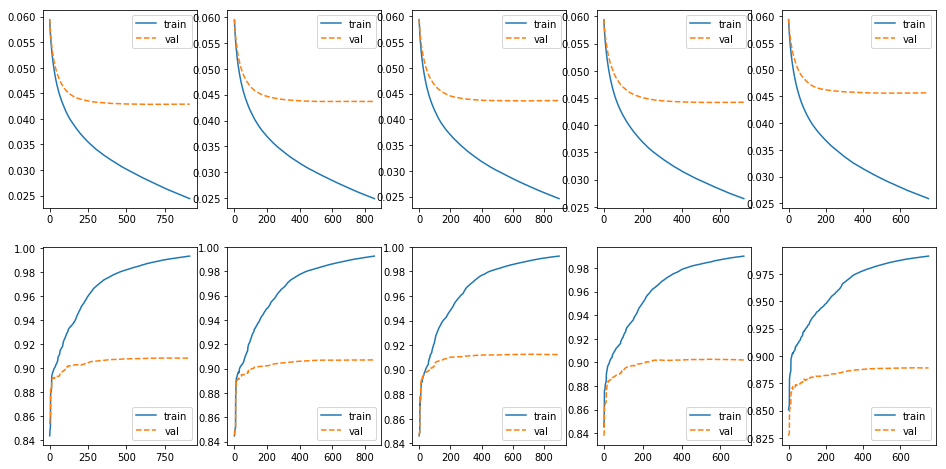

In [275]:
clf = LGBMClassifier(
    boosting_type='gbdt',
    num_leaves=31,
    max_depth=-1,
    learning_rate=0.01,
    n_estimators=10000,
    objective='binary',
#     class_weight='balanced',
    min_split_gain=0.0,
    min_child_weight=0.001,
#     min_child_samples=30,
    subsample=1.0,
    colsample_bytree=1.0,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=4590,
    n_jobs=-1,
)


NFOLD = 5
skf= StratifiedKFold(n_splits=NFOLD, shuffle=True, random_state=4590)

oof_train = np.zeros((len(df_train),1))
oof_train_b = np.zeros((len(df_train),1))
oof_test = np.zeros((len(df_test),1))
oof_test_skf = np.zeros((NFOLD,len(df_test),))
feature_importance_df = pd.DataFrame()
loss_csv = []
lst_auc = []
plt.figure(figsize=(16,8))

for fold_, (trn_idx, val_idx) in enumerate(skf.split(df_train,df_train['outliers'].values)):
    print("fold {}".format(fold_))
    clf.fit(df_train.iloc[trn_idx][features],target.iloc[trn_idx], 
            eval_set=[(df_train.iloc[trn_idx][features],target.iloc[trn_idx]),(df_train.iloc[val_idx][features],target.iloc[val_idx])],
            eval_metric=['logloss','auc'], early_stopping_rounds=200, verbose=True)
    val_pre_b = clf.predict(df_train.iloc[val_idx][features])
    val_pre_proba = clf.predict_proba(df_train.iloc[val_idx][features])[:,-1].reshape(-1,1)
    oof_train[val_idx] = val_pre_proba
    oof_train_b[val_idx] = val_pre_b.reshape(-1,1)
    
    print('='*40)
    print(classification_report(target.iloc[val_idx],val_pre_b))
    print(confusion_matrix(target.iloc[val_idx],val_pre_b))
    fold_auc = roc_auc_score(target.iloc[val_idx], val_pre_proba)
    lst_auc.append(fold_auc)
    print('AUC:',fold_auc)
    print('='*40)
    
    len_n = len(clf.evals_result_['valid_0']['binary_logloss'])
    plt.subplot(2,5,fold_+1)
    plt.plot(range(len_n),clf.evals_result_['valid_0']['binary_logloss'],'-')
    plt.plot(range(len_n),clf.evals_result_['valid_1']['binary_logloss'], '--')
    plt.legend(['train','val'])
    plt.subplot(2,5,fold_+6)
    plt.plot(range(len_n),clf.evals_result_['valid_0']['auc'],'-')
    plt.plot(range(len_n),clf.evals_result_['valid_1']['auc'], '--')
    plt.legend(['train','val'])
    
    loss_csv.append(clf.best_score_['valid_1']['binary_logloss'])
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    oof_test_skf[fold_,:]= clf.predict_proba(df_test[features])[:,-1]    
    
oof_test = oof_test_skf.mean(axis=0)
mean_loss = np.mean(loss_csv)
mean_auc = np.mean(lst_auc)
print('mean loss:',mean_loss,'mean auc:',mean_auc)
plt.savefig('result_class/lgb_class_auc%s_loss.png'%mean_auc)
plt.show()
sub_df = pd.DataFrame({"card_id":df_test["card_id"].values})
sub_df["target"] = oof_test
sub_df.to_csv("result_class/lgb_class_auc%s.csv"%mean_auc, index=False)

             precision    recall  f1-score   support

          0       0.99      1.00      0.99    199710
          1       0.50      0.00      0.01      2207

avg / total       0.98      0.99      0.98    201917

[[199704      6]
 [  2201      6]]
train AUC: 0.9036640623239901


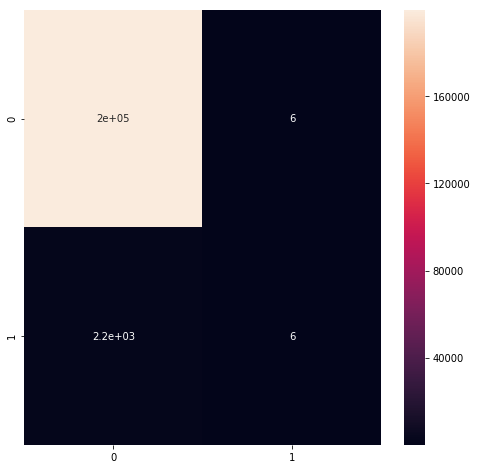

In [276]:
train_auc = roc_auc_score(target, oof_train)
confusion_matrix_train = confusion_matrix(target,oof_train_b)
print(classification_report(target,oof_train_b))
print(confusion_matrix_train)
print('train AUC:',train_auc)
plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix_train, annot=True)
plt.savefig('result_class/lgb_class_auc%s_cfm.png'%mean_auc)
plt.show()

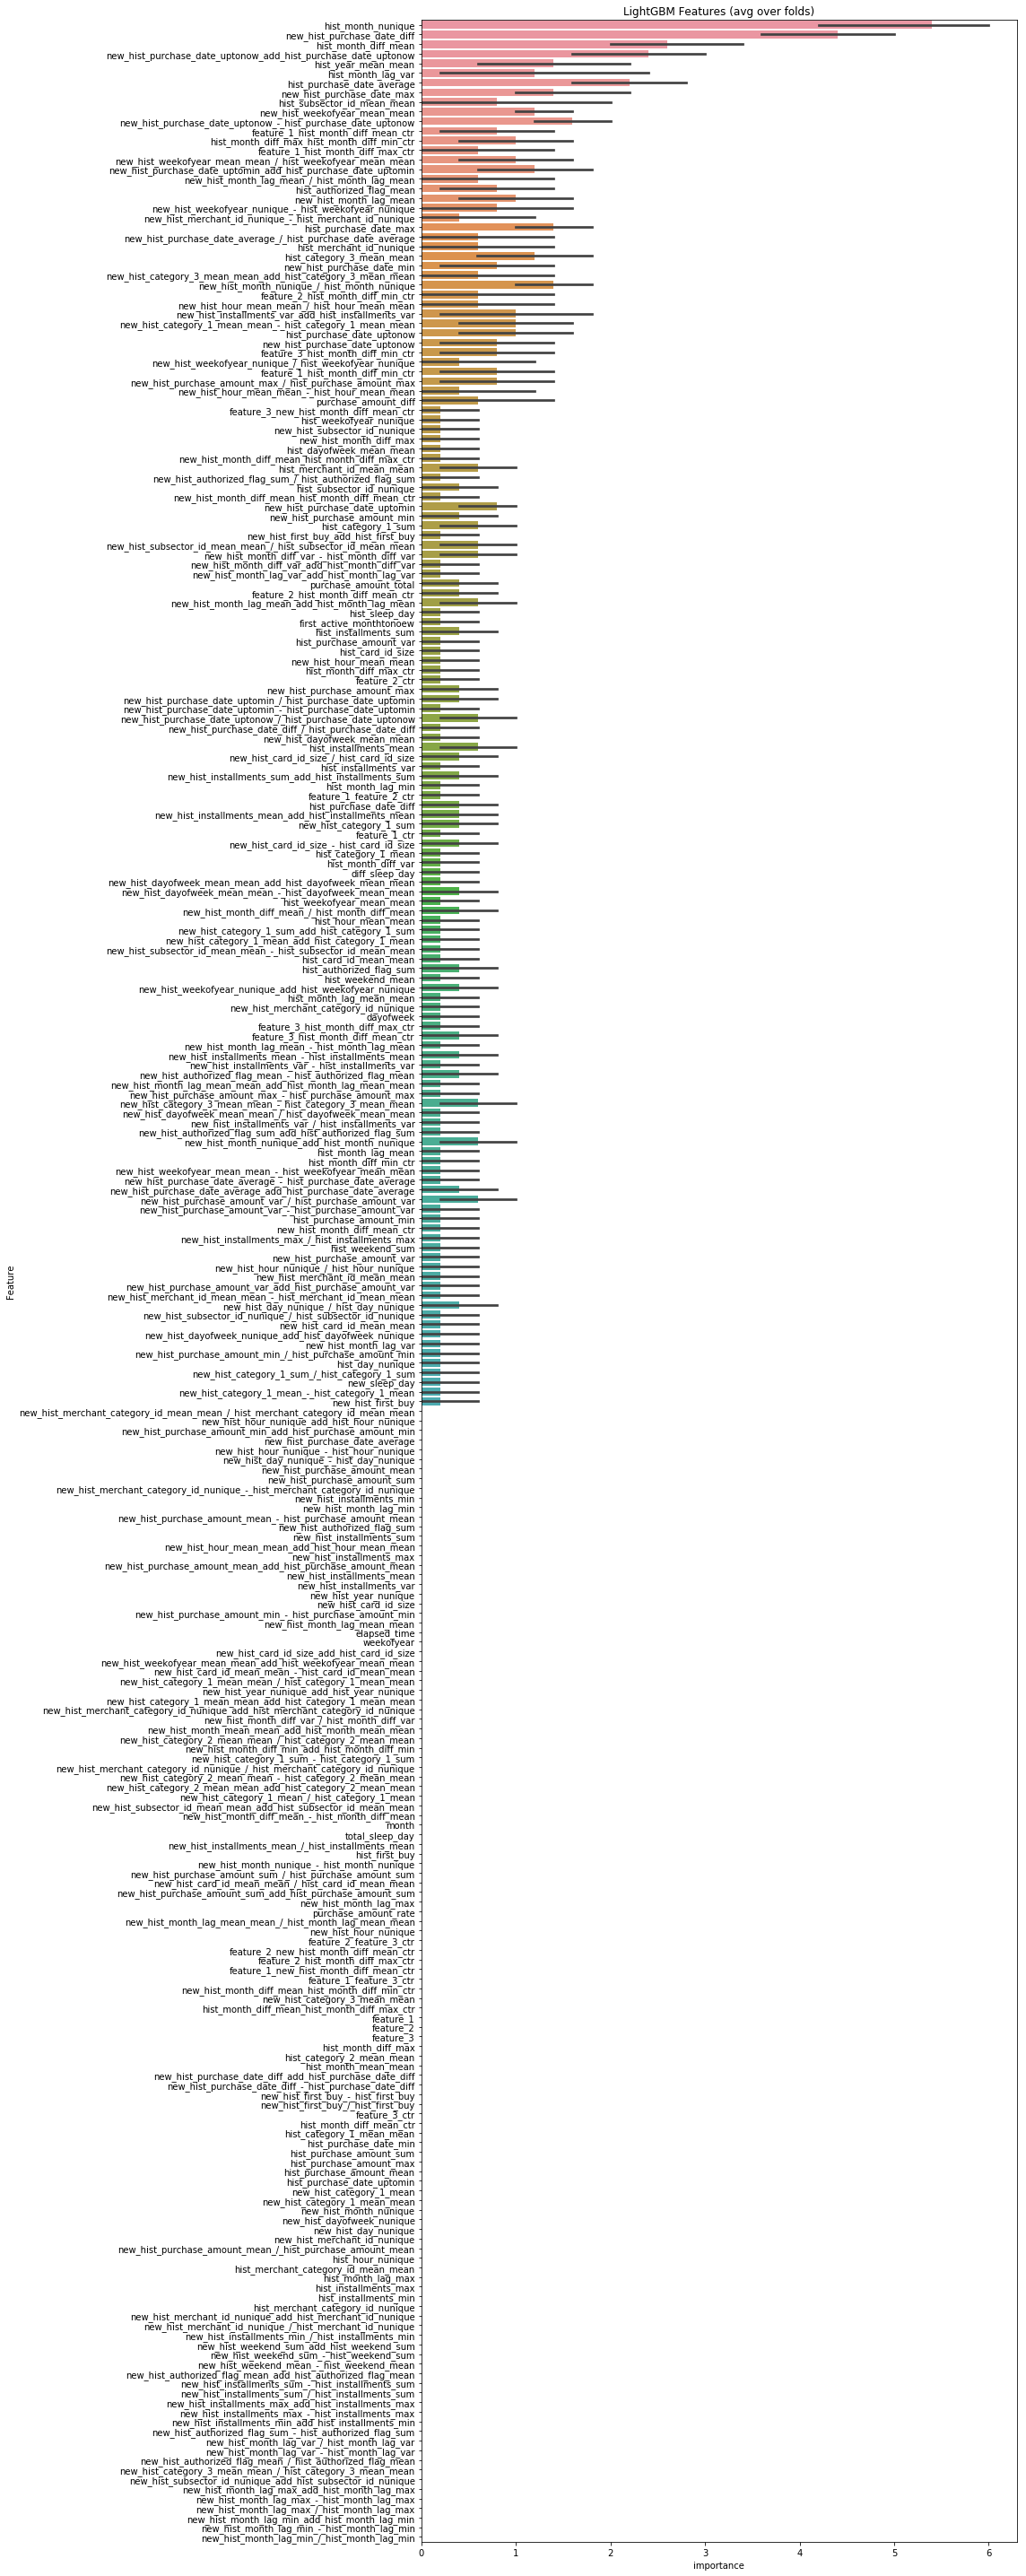

In [154]:
#cv: 3.6497796168629439  lb:3.693
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:500].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(16,40))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('result_class/lgb_class_auc%s_featimpt.png'%mean_auc)

In [168]:

def threshold_search(y_true, y_proba, plot=False):
    precision, recall, thresholds = precision_recall_curve(y_true, y_proba)
    thresholds = np.append(thresholds, 1.001) 
    F = 2 / (1/precision + 1/recall)
    best_score = np.max(F)
    best_th = thresholds[np.argmax(F)]
    if plot:
        plt.plot(thresholds, F, '-b')
        plt.plot([best_th], [best_score], '*r')
        plt.show()
    search_result = {'threshold': best_th , 'f1': best_score}
    return search_result 

In [169]:
threshold_search(train_y.values,oof_train.reshape(-1))

{'f1': 0.1750674133997096, 'threshold': 0.044928557290256056}

In [151]:
199710/2207

90.48935206162211

## merchant

In [155]:
df_merchant = pd.read_csv("../input/merchants.csv")
add_columns =  [i for  i in df_merchant.columns if i not in df_hist_trans.columns]
df_hist_trans = pd.merge(df_hist_trans,df_merchant[['merchant_id']+add_columns],how='left',on=['merchant_id'])
df_new_merchant_trans = pd.merge(df_new_merchant_trans,df_merchant[['merchant_id']+add_columns],how='left',on=['merchant_id'])

### merchant text feature

In [193]:
df_hist_ca=['authorized_flag','category_1','installments','category_3','merchant_category_id','merchant_id','category_2','state_id',\
          'subsector_id','purchase_amount' ]+add_columns

hist_text_feature={}
gp=df_hist_trans.groupby('card_id')
for fea  in df_hist_ca:
    hist_text_feature[fea+"_hist_text"]=[]
hist_text_feature['card_id']=[]
for_i = 0
for cid,cid_df in  gp:
    if for_i % 10000 == 0:
        print('hist:',for_i,'/',len(gp))
    for_i += 1
    hist_text_feature['card_id'].append(cid)
    for  fea in  df_hist_ca:
        if fea=='card_id':
            continue
        hist_text_feature[fea+"_hist_text"].append(" ".join(cid_df[fea].astype(str).tolist()))
df_hist_text=pd.DataFrame(hist_text_feature)


new_mer_text_feature={}
gp=df_new_merchant_trans.groupby('card_id')
for fea  in df_hist_ca:
    new_mer_text_feature[fea+"_new_mer_text"]=[]
new_mer_text_feature['card_id']=[]
for_i = 0
for cid,cid_df in  gp:
    if for_i % 10000 == 0:
        print('new:',for_i,'/',len(gp))
    for_i += 1
    new_mer_text_feature['card_id'].append(cid)
    for  fea in  df_hist_ca:
        if fea=='card_id':
            continue
        new_mer_text_feature[fea+"_new_mer_text"].append(" ".join(cid_df[fea].astype(str).tolist()))
        
df_new_mer_text=pd.DataFrame(new_mer_text_feature)

hist 0 / 325540
hist 10000 / 325540
hist 20000 / 325540
hist 30000 / 325540
hist 40000 / 325540
hist 50000 / 325540
hist 60000 / 325540
hist 70000 / 325540
hist 80000 / 325540
hist 90000 / 325540
hist 100000 / 325540
hist 110000 / 325540
hist 120000 / 325540
hist 130000 / 325540
hist 140000 / 325540
hist 150000 / 325540
hist 160000 / 325540
hist 170000 / 325540
hist 180000 / 325540
hist 190000 / 325540
hist 200000 / 325540
hist 210000 / 325540
hist 220000 / 325540
hist 230000 / 325540
hist 240000 / 325540
hist 250000 / 325540
hist 260000 / 325540
hist 270000 / 325540
hist 280000 / 325540
hist 290000 / 325540
hist 300000 / 325540
hist 310000 / 325540
hist 320000 / 325540
new 0 / 290001
new 10000 / 290001
new 20000 / 290001
new 30000 / 290001
new 40000 / 290001
new 50000 / 290001
new 60000 / 290001
new 70000 / 290001
new 80000 / 290001
new 90000 / 290001
new 100000 / 290001
new 110000 / 290001
new 120000 / 290001
new 130000 / 290001
new 140000 / 290001
new 150000 / 290001
new 160000 / 29

In [206]:
df_hist_text.to_csv('../input/df_feats_hist_text.csv',index=False)
df_new_mer_text.to_csv('../input/df_feats_new_text.csv',index=False)

### add hist merchant text

In [219]:
df_train=pd.merge(df_train,df_hist_text,how='left',on='card_id')
df_test=pd.merge(df_test,df_hist_text,how='left',on='card_id')

df_all=pd.concat([df_train,df_test])
text_fea=[i for i in df_all.columns if "text"in i]
cv=CountVectorizer(analyzer='word',token_pattern=u"(?u)\\b\\w+\\b")

for idx,i in enumerate(text_fea):
    print(i)
    cv.fit(df_all[i])
    tr_x=cv.transform(df_train[i])
    te_x=cv.transform(df_test[i])
    
    if idx==0:
        cv_Train_x=tr_x
        cv_Test_x=te_x
    else:
        cv_Train_x=sparse.hstack((cv_Train_x,tr_x))
        cv_Test_x=sparse.hstack((cv_Test_x,te_x))
    
print(cv_Train_x.shape,cv_Test_x.shape)


active_months_lag12_hist_text
active_months_lag3_hist_text
active_months_lag6_hist_text
authorized_flag_hist_text
avg_purchases_lag12_hist_text
avg_purchases_lag3_hist_text
avg_purchases_lag6_hist_text
avg_sales_lag12_hist_text
avg_sales_lag3_hist_text
avg_sales_lag6_hist_text
category_1_hist_text
category_2_hist_text
category_3_hist_text
category_4_hist_text
installments_hist_text
merchant_category_id_hist_text
merchant_group_id_hist_text
merchant_id_hist_text
most_recent_purchases_range_hist_text
most_recent_sales_range_hist_text
numerical_1_hist_text
numerical_2_hist_text
purchase_amount_hist_text
state_id_hist_text
subsector_id_hist_text
(201917, 977434) (123623, 977434)


In [220]:
# 方检验chi2,取前500个特征
skb = SelectKBest(chi2,500)
skb.fit(cv_Train_x,df_train['outliers'].values)

cv_Train_x_filter = skb.transform(cv_Train_x)
cv_Test_x_filter = skb.transform(cv_Test_x)

print(cv_Train_x_filter.shape,cv_Test_x_filter.shape)

(201917, 500) (123623, 500)


In [197]:
cv_Train_x_filter.data

array([  3,  59,   9, ..., 140, 134, 140], dtype=int64)

In [221]:

oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

train_x=df_train[features].values
test_x=df_test[features].values
train_y=df_train['outliers'].values

train_x=sparse.hstack((train_x,cv_Train_x_filter),'csr')
test_x=sparse.hstack((test_x,cv_Test_x_filter),'csr')
oof_train2 = np.zeros((train_x.shape[0],1))
oof_test2 = np.zeros((test_x.shape[0],1))
oof_test2_skf = np.zeros((NFOLD,test_x.shape[0],))

print(train_x.shape,test_x.shape)

feature_importance_df = pd.DataFrame()
loss_csv = []
for fold_, (trn_idx, val_idx) in enumerate(skf.split(train_x,df_train['outliers'].values)):
    print("fold {}".format(fold_))
    x_tr,y_tr,x_te,y_te=train_x[trn_idx],train_y[trn_idx],train_x[val_idx],train_y[val_idx]
    trn_data = lgb.Dataset(x_tr,y_tr)
    val_data = lgb.Dataset(x_te,y_te)
    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=200, early_stopping_rounds = 500)
    oof_train2[val_idx] = clf.predict(x_te, num_iteration=clf.best_iteration).reshape(-1,1)
    loss_csv.append(clf.best_score['valid_1']['binary_logloss'])

    oof_test2_skf[fold_,:]= clf.predict(test_x, num_iteration=clf.best_iteration)    
oof_test2 = oof_test2_skf.mean(axis=0)
mean_loss=np.mean(loss_csv)
print(mean_loss)

(201917, 762) (123623, 762)
fold 0
Training until validation scores don't improve for 500 rounds.
[200]	training's binary_logloss: 0.0371375	valid_1's binary_logloss: 0.0440579
[400]	training's binary_logloss: 0.0317283	valid_1's binary_logloss: 0.0431928
[600]	training's binary_logloss: 0.0280523	valid_1's binary_logloss: 0.0430423
[800]	training's binary_logloss: 0.0251269	valid_1's binary_logloss: 0.0430004
[1000]	training's binary_logloss: 0.0226752	valid_1's binary_logloss: 0.0430468
[1200]	training's binary_logloss: 0.0205657	valid_1's binary_logloss: 0.0430899
Early stopping, best iteration is:
[806]	training's binary_logloss: 0.0250459	valid_1's binary_logloss: 0.042998
fold 1
Training until validation scores don't improve for 500 rounds.
[200]	training's binary_logloss: 0.0369749	valid_1's binary_logloss: 0.0446094
[400]	training's binary_logloss: 0.0315783	valid_1's binary_logloss: 0.043818
[600]	training's binary_logloss: 0.0279827	valid_1's binary_logloss: 0.0436893
[800]	t

In [222]:
sub_df = pd.DataFrame({"card_id":df_test["card_id"].values})
sub_df["target"] = oof_test2
sub_df.to_csv("result_class/lgb_class_meanloss%s.csv"%mean_loss, index=False)
print(mean_loss)
train_prob=pd.DataFrame(oof_train2)
train_prob.columns=['class1']
train_prob.to_csv("result_class/lgb_class_train_prob_meanloss%s.csv"%mean_loss,index=False)

test_prob=pd.DataFrame(oof_test2)
test_prob.columns=['class1']
test_prob.to_csv("result_class/lgb_class_test_prob_meanloss%s.csv"%mean_loss,index=False)

np.save("train_y",target)

0.04386367862536939


In [223]:
threshold_search(train_y,train_prob)

{'f1': 0.2491743119266055, 'threshold': 0.10774409548273503}

### add new first_active_month text

In [253]:
df_train=pd.merge(df_train,df_new_mer_text,how='left',on='card_id')
df_test=pd.merge(df_test,df_new_mer_text,how='left',on='card_id')

df_all=pd.concat([df_train,df_test])

text_fea=[i for i in df_all.columns if "_new_mer_text"in i]

cv=CountVectorizer(analyzer='word',token_pattern=u"(?u)\\b\\w+\\b")

for idx,i in enumerate(text_fea):
    df_all[i].fillna('-1',inplace=True)
    df_train[i].fillna('-1',inplace=True)
    df_test[i].fillna('-1',inplace=True)
    cv.fit(df_all[i])
    tr_x=cv.transform(df_train[i])
    te_x=cv.transform(df_test[i])
    
    if idx==0:
        cv_Train_x_2=tr_x
        cv_Test_x_2=te_x
    else:
        cv_Train_x_2=sparse.hstack((cv_Train_x_2,tr_x))
        cv_Test_x_2=sparse.hstack((cv_Test_x_2,te_x))
    
print(cv_Train_x_2.shape,cv_Test_x_2.shape)

(201917, 1353304) (123623, 1353304)


In [254]:
skb = SelectKBest(chi2,500)
skb.fit(cv_Train_x_2,df_train['outliers'].values)

cv_Train_x_2_filter = skb.transform(cv_Train_x_2)
cv_Test_x_2_filter = skb.transform(cv_Test_x_2)

print(cv_Train_x_2_filter.shape,cv_Test_x_2_filter.shape)

(201917, 500) (123623, 500)


In [255]:
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

train_x=df_train[features].values
test_x=df_test[features].values
train_y=df_train['outliers'].values

train_x=sparse.hstack((train_x,cv_Train_x_2_filter),'csr')
test_x=sparse.hstack((test_x,cv_Test_x_2_filter),'csr')
oof_train3 = np.zeros((train_x.shape[0],1))
oof_test3 = np.zeros((test_x.shape[0],1))
oof_test3_skf = np.zeros((NFOLD,test_x.shape[0],))

print(train_x.shape,test_x.shape)

feature_importance_df = pd.DataFrame()
loss_csv = []

for fold_, (trn_idx, val_idx) in enumerate(skf.split(train_x,df_train['outliers'].values)):
    print("fold {}".format(fold_))
    x_tr,y_tr,x_te,y_te=train_x[trn_idx],train_y[trn_idx],train_x[val_idx],train_y[val_idx]
    trn_data = lgb.Dataset(x_tr,y_tr)
    val_data = lgb.Dataset(x_te,y_te)
    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=200, early_stopping_rounds = 500)
    oof_train3[val_idx] = clf.predict(x_te, num_iteration=clf.best_iteration).reshape(-1,1)
    loss_csv.append(clf.best_score['valid_1']['binary_logloss'])

    oof_test3_skf[fold_,:]= clf.predict(test_x, num_iteration=clf.best_iteration)    
oof_test3 = oof_test3_skf.mean(axis=0)
mean_loss= np.mean(loss_csv)
print(mean_loss)


sub_df = pd.DataFrame({"card_id":df_test["card_id"].values})
sub_df["target"] = oof_test3
sub_df.to_csv("result_class/lgb_class_meanloss%s.csv"%mean_loss, index=False)

train_prob=pd.DataFrame(oof_train3)
train_prob.columns=['class1']
train_prob.to_csv("result_class/lgb_class_train_prob_meanloss%s.csv"%mean_loss,index=False)

test_prob=pd.DataFrame(oof_test3)
test_prob.columns=['class1']
test_prob.to_csv("result_class/lgb_class_test_prob_meanloss%s.csv"%mean_loss,index=False)

np.save("train_y",target)

(201917, 762) (123623, 762)
fold 0
Training until validation scores don't improve for 500 rounds.
[200]	training's binary_logloss: 0.0374768	valid_1's binary_logloss: 0.0440966
[400]	training's binary_logloss: 0.0321708	valid_1's binary_logloss: 0.0432446
[600]	training's binary_logloss: 0.0286361	valid_1's binary_logloss: 0.0430766
[800]	training's binary_logloss: 0.0258099	valid_1's binary_logloss: 0.043066
[1000]	training's binary_logloss: 0.0234069	valid_1's binary_logloss: 0.0431017
Early stopping, best iteration is:
[633]	training's binary_logloss: 0.0281219	valid_1's binary_logloss: 0.0430547
fold 1
Training until validation scores don't improve for 500 rounds.
[200]	training's binary_logloss: 0.0373412	valid_1's binary_logloss: 0.0446367
[400]	training's binary_logloss: 0.0320634	valid_1's binary_logloss: 0.0438471
[600]	training's binary_logloss: 0.0284817	valid_1's binary_logloss: 0.0436871
[800]	training's binary_logloss: 0.0256907	valid_1's binary_logloss: 0.0436669
[1000]	

FileNotFoundError: [Errno 2] No such file or directory: 'sub/submission_0.04399103007684532.csv'

In [258]:
threshold_search(train_y,train_prob)

{'f1': 0.24603338141355863, 'threshold': 0.1251036593702691}

### hstack cv_Train_x and cv_Train_x_2

In [259]:
sp_tr_x  =  sparse.hstack((cv_Train_x,cv_Train_x_2))
sp_te_x  =  sparse.hstack((cv_Test_x,cv_Test_x_2))
print(sp_tr_x.shape,sp_te_x.shape)

skb = SelectKBest(chi2,800)
skb.fit(sp_tr_x,df_train['outliers'].values)

sp_tr_x_filter = skb.transform(sp_tr_x)
sp_te_x_filter = skb.transform(sp_te_x)

print(sp_tr_x_filter.shape,sp_te_x_filter.shape)

(201917, 2330738) (123623, 2330738)
(201917, 800) (123623, 800)


In [261]:
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

train_x=df_train[features].values
test_x=df_test[features].values
print(train_x.shape,test_x.shape)
train_y= df_train['outliers'].values
train_x = sparse.hstack((train_x,sp_tr_x_filter),'csr')
test_x = sparse.hstack((test_x,sp_te_x_filter),'csr')
print(train_x.shape,test_x.shape)

oof_train4 = np.zeros((train_x.shape[0],1))
oof_test4 = np.zeros((test_x.shape[0],1))
oof_test4_skf = np.zeros((NFOLD,test_x.shape[0],))

print(train_x.shape,test_x.shape)

feature_importance_df = pd.DataFrame()
loss_csv = []

for fold_, (trn_idx, val_idx) in enumerate(skf.split(train_x,df_train['outliers'].values)):
    print("fold {}".format(fold_))
    x_tr,y_tr,x_te,y_te=train_x[trn_idx],train_y[trn_idx],train_x[val_idx],train_y[val_idx]
    trn_data = lgb.Dataset(x_tr,y_tr)
    val_data = lgb.Dataset(x_te,y_te)
    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=200, early_stopping_rounds = 500)
    oof_train4[val_idx] = clf.predict(x_te, num_iteration=clf.best_iteration).reshape(-1,1)
    loss_csv.append(clf.best_score['valid_1']['binary_logloss'])

    oof_test4_skf[fold_,:]= clf.predict(test_x, num_iteration=clf.best_iteration)    
oof_test4 = oof_test4_skf.mean(axis=0)
mean_loss=np.mean(loss_csv)
print(mean_loss)


sub_df = pd.DataFrame({"card_id":df_test["card_id"].values})
sub_df["target"] = oof_test4
sub_df.to_csv("result_class/lgb_class_meanloss%s.csv"%mean_loss, index=False)

train_prob=pd.DataFrame(oof_train4)
train_prob.columns=['class1']
train_prob.to_csv("result_class/lgb_class_train_prob_meanloss%s.csv"%mean_loss,index=False)

test_prob=pd.DataFrame(oof_test4)
test_prob.columns=['class1']
test_prob.to_csv("result_class/lgb_class_test_prob_meanloss%s.csv"%mean_loss,index=False)

np.save("train_y",target)

(201917, 262) (123623, 262)
(201917, 1062) (123623, 1062)
(201917, 1062) (123623, 1062)
fold 0
Training until validation scores don't improve for 500 rounds.
[200]	training's binary_logloss: 0.0371549	valid_1's binary_logloss: 0.043881
[400]	training's binary_logloss: 0.031775	valid_1's binary_logloss: 0.0429936
[600]	training's binary_logloss: 0.0280621	valid_1's binary_logloss: 0.0428322
[800]	training's binary_logloss: 0.0251517	valid_1's binary_logloss: 0.0427912
[1000]	training's binary_logloss: 0.0226543	valid_1's binary_logloss: 0.0428098
[1200]	training's binary_logloss: 0.0205123	valid_1's binary_logloss: 0.0429143
Early stopping, best iteration is:
[798]	training's binary_logloss: 0.0251803	valid_1's binary_logloss: 0.0427872
fold 1
Training until validation scores don't improve for 500 rounds.
[200]	training's binary_logloss: 0.0370429	valid_1's binary_logloss: 0.0446016
[400]	training's binary_logloss: 0.0315866	valid_1's binary_logloss: 0.0437838
[600]	training's binary_lo

In [262]:
threshold_search(train_y,train_prob)

{'f1': 0.24847001223990206, 'threshold': 0.12176470528038673}

### stack

In [271]:
oof_train = oof_train.reshape(-1,1)

In [272]:
train_stack = np.concatenate([oof_train,oof_train2,oof_train3,oof_train4],axis=1)
test_stack = np.concatenate([oof_test.reshape(-1,1),oof_test2.reshape(-1,1),\
                             oof_test3.reshape(-1,1),oof_test4.reshape(-1,1)],axis=1)
print(train_stack.shape,test_stack.shape)

oof_train5 = np.zeros((train_stack.shape[0],1))
oof_test5 = np.zeros((test_stack.shape[0],1))
oof_test5_skf = np.zeros((5,test_stack.shape[0],1))
loss_csv = []
param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'binary',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 30,
         "boosting": "gbdt",
         "feature_fraction": 0.8,
         "bagging_freq": 1,
         "bagging_fraction": 0.74 ,
         "lambda_l1": 0.0,
         'lambda_l2':0.0,
         "verbosity": -1,
         "n_jobs":10,
         "random_state": 4590}
for fold_, (trn_idx, val_idx) in enumerate(skf.split(train_stack,df_train['outliers'].values)):
    print("fold {}".format(fold_))
    x_tr, y_tr = train_stack[trn_idx], target.iloc[trn_idx].values
    x_te, y_te = train_stack[val_idx], target.iloc[val_idx].values
    
    trn_data = lgb.Dataset(x_tr,y_tr)
    val_data = lgb.Dataset(x_te,y_te)
    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=200, early_stopping_rounds = 500)
    oof_train5[val_idx] = clf.predict(x_te, num_iteration=clf.best_iteration).reshape(-1,1)
    loss_csv.append(clf.best_score['valid_1']['binary_logloss'])
    oof_test5_skf[fold_,:] = clf.predict(test_stack).reshape(-1,1)

oof_test = oof_test5_skf.mean(axis=0)
stack_loss=np.mean(loss_csv)
print(stack_loss)
sub_df = pd.DataFrame({"card_id":df_test["card_id"].values})
sub_df["target"] = oof_test5
sub_df.to_csv("result_class/lgb_class_stack_loss%s.csv"%stack_loss, index=False)

train_prob=pd.DataFrame(oof_train5)
train_prob.columns=['class1']
train_prob.to_csv("result_class/lgb_class_train_prob_stack_loss%s.csv"%stack_loss,index=False)

test_prob=pd.DataFrame(oof_test5)
test_prob.columns=['class1']
test_prob.to_csv("result_class/lgb_class_test_prob_stack_loss%s.csv"%stack_loss,index=False)

(201917, 4) (123623, 4)
fold 0
Training until validation scores don't improve for 500 rounds.
[200]	training's binary_logloss: 0.042093	valid_1's binary_logloss: 0.0435433
[400]	training's binary_logloss: 0.0395378	valid_1's binary_logloss: 0.0430466
[600]	training's binary_logloss: 0.0381452	valid_1's binary_logloss: 0.0430687
[800]	training's binary_logloss: 0.0369471	valid_1's binary_logloss: 0.0431775
[1000]	training's binary_logloss: 0.0358965	valid_1's binary_logloss: 0.0432996
Early stopping, best iteration is:
[521]	training's binary_logloss: 0.0386276	valid_1's binary_logloss: 0.0430359
fold 1
Training until validation scores don't improve for 500 rounds.
[200]	training's binary_logloss: 0.041895	valid_1's binary_logloss: 0.0441498
[400]	training's binary_logloss: 0.0393477	valid_1's binary_logloss: 0.0437343
[600]	training's binary_logloss: 0.037907	valid_1's binary_logloss: 0.043837
[800]	training's binary_logloss: 0.0367049	valid_1's binary_logloss: 0.043994
Early stopping,

FileNotFoundError: [Errno 2] No such file or directory: 'class_sub/submission_0.04401906465673574.csv'

In [274]:
threshold_search(train_y,train_prob)

{'f1': 0.24601924759405078, 'threshold': 0.11647209062396326}

### drop outliers

In [229]:
df_train[df_train['outliers']==0].shape

(199710, 336)

In [230]:
target_no_outliers = df_train[df_train['outliers']==0]['target']
target_no_outliers.shape

(199710,)

fold 0
[1]	valid_0's rmse: 1.71042	valid_0's l2: 2.92553	valid_1's rmse: 1.73559	valid_1's l2: 3.01226
Training until validation scores don't improve for 200 rounds.
[2]	valid_0's rmse: 1.70813	valid_0's l2: 2.91772	valid_1's rmse: 1.73338	valid_1's l2: 3.00461
[3]	valid_0's rmse: 1.70589	valid_0's l2: 2.91007	valid_1's rmse: 1.73122	valid_1's l2: 2.99711
[4]	valid_0's rmse: 1.70371	valid_0's l2: 2.90263	valid_1's rmse: 1.72912	valid_1's l2: 2.98987
[5]	valid_0's rmse: 1.70155	valid_0's l2: 2.89528	valid_1's rmse: 1.72704	valid_1's l2: 2.98267
[6]	valid_0's rmse: 1.69944	valid_0's l2: 2.88811	valid_1's rmse: 1.725	valid_1's l2: 2.97562
[7]	valid_0's rmse: 1.69735	valid_0's l2: 2.88099	valid_1's rmse: 1.72299	valid_1's l2: 2.96869
[8]	valid_0's rmse: 1.69532	valid_0's l2: 2.8741	valid_1's rmse: 1.72104	valid_1's l2: 2.96198
[9]	valid_0's rmse: 1.6933	valid_0's l2: 2.86728	valid_1's rmse: 1.71911	valid_1's l2: 2.95532
[10]	valid_0's rmse: 1.69133	valid_0's l2: 2.8606	valid_1's rmse: 1.71

[87]	valid_0's rmse: 1.6046	valid_0's l2: 2.57473	valid_1's rmse: 1.63523	valid_1's l2: 2.67398
[88]	valid_0's rmse: 1.604	valid_0's l2: 2.57281	valid_1's rmse: 1.6347	valid_1's l2: 2.67226
[89]	valid_0's rmse: 1.60337	valid_0's l2: 2.57079	valid_1's rmse: 1.63413	valid_1's l2: 2.67037
[90]	valid_0's rmse: 1.60279	valid_0's l2: 2.56892	valid_1's rmse: 1.63362	valid_1's l2: 2.6687
[91]	valid_0's rmse: 1.60221	valid_0's l2: 2.56709	valid_1's rmse: 1.6331	valid_1's l2: 2.66703
[92]	valid_0's rmse: 1.60161	valid_0's l2: 2.56516	valid_1's rmse: 1.63255	valid_1's l2: 2.66521
[93]	valid_0's rmse: 1.60106	valid_0's l2: 2.5634	valid_1's rmse: 1.63207	valid_1's l2: 2.66364
[94]	valid_0's rmse: 1.60047	valid_0's l2: 2.5615	valid_1's rmse: 1.63155	valid_1's l2: 2.66195
[95]	valid_0's rmse: 1.59993	valid_0's l2: 2.55978	valid_1's rmse: 1.63108	valid_1's l2: 2.66042
[96]	valid_0's rmse: 1.59936	valid_0's l2: 2.55797	valid_1's rmse: 1.63057	valid_1's l2: 2.65874
[97]	valid_0's rmse: 1.59885	valid_0's

[173]	valid_0's rmse: 1.57114	valid_0's l2: 2.46848	valid_1's rmse: 1.60639	valid_1's l2: 2.58048
[174]	valid_0's rmse: 1.57091	valid_0's l2: 2.46775	valid_1's rmse: 1.6062	valid_1's l2: 2.57988
[175]	valid_0's rmse: 1.57066	valid_0's l2: 2.46699	valid_1's rmse: 1.60601	valid_1's l2: 2.57928
[176]	valid_0's rmse: 1.57042	valid_0's l2: 2.46622	valid_1's rmse: 1.60582	valid_1's l2: 2.57867
[177]	valid_0's rmse: 1.57017	valid_0's l2: 2.46544	valid_1's rmse: 1.60563	valid_1's l2: 2.57805
[178]	valid_0's rmse: 1.56995	valid_0's l2: 2.46473	valid_1's rmse: 1.60546	valid_1's l2: 2.57749
[179]	valid_0's rmse: 1.5697	valid_0's l2: 2.46397	valid_1's rmse: 1.60527	valid_1's l2: 2.57689
[180]	valid_0's rmse: 1.56947	valid_0's l2: 2.46324	valid_1's rmse: 1.60508	valid_1's l2: 2.57628
[181]	valid_0's rmse: 1.56925	valid_0's l2: 2.46255	valid_1's rmse: 1.6049	valid_1's l2: 2.57569
[182]	valid_0's rmse: 1.56902	valid_0's l2: 2.46183	valid_1's rmse: 1.60472	valid_1's l2: 2.57513
[183]	valid_0's rmse: 1

[260]	valid_0's rmse: 1.5555	valid_0's l2: 2.41959	valid_1's rmse: 1.59538	valid_1's l2: 2.54525
[261]	valid_0's rmse: 1.55537	valid_0's l2: 2.41917	valid_1's rmse: 1.59531	valid_1's l2: 2.545
[262]	valid_0's rmse: 1.55523	valid_0's l2: 2.41875	valid_1's rmse: 1.59522	valid_1's l2: 2.54473
[263]	valid_0's rmse: 1.5551	valid_0's l2: 2.41832	valid_1's rmse: 1.59514	valid_1's l2: 2.54448
[264]	valid_0's rmse: 1.55497	valid_0's l2: 2.41794	valid_1's rmse: 1.59507	valid_1's l2: 2.54423
[265]	valid_0's rmse: 1.55483	valid_0's l2: 2.4175	valid_1's rmse: 1.59497	valid_1's l2: 2.54393
[266]	valid_0's rmse: 1.5547	valid_0's l2: 2.4171	valid_1's rmse: 1.59489	valid_1's l2: 2.54367
[267]	valid_0's rmse: 1.55457	valid_0's l2: 2.41669	valid_1's rmse: 1.59482	valid_1's l2: 2.54345
[268]	valid_0's rmse: 1.55445	valid_0's l2: 2.41631	valid_1's rmse: 1.59474	valid_1's l2: 2.5432
[269]	valid_0's rmse: 1.55432	valid_0's l2: 2.4159	valid_1's rmse: 1.59465	valid_1's l2: 2.54291
[270]	valid_0's rmse: 1.55418

[346]	valid_0's rmse: 1.54574	valid_0's l2: 2.38931	valid_1's rmse: 1.59003	valid_1's l2: 2.52819
[347]	valid_0's rmse: 1.54565	valid_0's l2: 2.38903	valid_1's rmse: 1.58998	valid_1's l2: 2.52802
[348]	valid_0's rmse: 1.54555	valid_0's l2: 2.38874	valid_1's rmse: 1.58995	valid_1's l2: 2.52795
[349]	valid_0's rmse: 1.54547	valid_0's l2: 2.38847	valid_1's rmse: 1.58991	valid_1's l2: 2.52782
[350]	valid_0's rmse: 1.54537	valid_0's l2: 2.38816	valid_1's rmse: 1.58986	valid_1's l2: 2.52765
[351]	valid_0's rmse: 1.54527	valid_0's l2: 2.38787	valid_1's rmse: 1.58981	valid_1's l2: 2.5275
[352]	valid_0's rmse: 1.54519	valid_0's l2: 2.3876	valid_1's rmse: 1.58978	valid_1's l2: 2.52738
[353]	valid_0's rmse: 1.54509	valid_0's l2: 2.38731	valid_1's rmse: 1.58974	valid_1's l2: 2.52727
[354]	valid_0's rmse: 1.545	valid_0's l2: 2.38702	valid_1's rmse: 1.58969	valid_1's l2: 2.5271
[355]	valid_0's rmse: 1.5449	valid_0's l2: 2.3867	valid_1's rmse: 1.58963	valid_1's l2: 2.52693
[356]	valid_0's rmse: 1.544

[431]	valid_0's rmse: 1.53836	valid_0's l2: 2.36655	valid_1's rmse: 1.58697	valid_1's l2: 2.51847
[432]	valid_0's rmse: 1.53828	valid_0's l2: 2.36629	valid_1's rmse: 1.58692	valid_1's l2: 2.5183
[433]	valid_0's rmse: 1.5382	valid_0's l2: 2.36605	valid_1's rmse: 1.58689	valid_1's l2: 2.51822
[434]	valid_0's rmse: 1.53812	valid_0's l2: 2.36581	valid_1's rmse: 1.58685	valid_1's l2: 2.5181
[435]	valid_0's rmse: 1.53803	valid_0's l2: 2.36554	valid_1's rmse: 1.58682	valid_1's l2: 2.518
[436]	valid_0's rmse: 1.53796	valid_0's l2: 2.36531	valid_1's rmse: 1.58678	valid_1's l2: 2.51788
[437]	valid_0's rmse: 1.53788	valid_0's l2: 2.36506	valid_1's rmse: 1.58674	valid_1's l2: 2.51774
[438]	valid_0's rmse: 1.5378	valid_0's l2: 2.36484	valid_1's rmse: 1.58673	valid_1's l2: 2.5177
[439]	valid_0's rmse: 1.53773	valid_0's l2: 2.36461	valid_1's rmse: 1.5867	valid_1's l2: 2.51761
[440]	valid_0's rmse: 1.53765	valid_0's l2: 2.36437	valid_1's rmse: 1.58667	valid_1's l2: 2.51752
[441]	valid_0's rmse: 1.5375

[515]	valid_0's rmse: 1.53225	valid_0's l2: 2.34778	valid_1's rmse: 1.58473	valid_1's l2: 2.51137
[516]	valid_0's rmse: 1.53218	valid_0's l2: 2.34757	valid_1's rmse: 1.58471	valid_1's l2: 2.5113
[517]	valid_0's rmse: 1.53211	valid_0's l2: 2.34735	valid_1's rmse: 1.58468	valid_1's l2: 2.51121
[518]	valid_0's rmse: 1.53204	valid_0's l2: 2.34716	valid_1's rmse: 1.58467	valid_1's l2: 2.51117
[519]	valid_0's rmse: 1.53197	valid_0's l2: 2.34693	valid_1's rmse: 1.58465	valid_1's l2: 2.51111
[520]	valid_0's rmse: 1.5319	valid_0's l2: 2.34671	valid_1's rmse: 1.58462	valid_1's l2: 2.51103
[521]	valid_0's rmse: 1.53183	valid_0's l2: 2.3465	valid_1's rmse: 1.58461	valid_1's l2: 2.51098
[522]	valid_0's rmse: 1.53176	valid_0's l2: 2.34628	valid_1's rmse: 1.58459	valid_1's l2: 2.51093
[523]	valid_0's rmse: 1.5317	valid_0's l2: 2.34609	valid_1's rmse: 1.58457	valid_1's l2: 2.51087
[524]	valid_0's rmse: 1.53163	valid_0's l2: 2.34588	valid_1's rmse: 1.58455	valid_1's l2: 2.51081
[525]	valid_0's rmse: 1.

[599]	valid_0's rmse: 1.52677	valid_0's l2: 2.33103	valid_1's rmse: 1.58344	valid_1's l2: 2.50727
[600]	valid_0's rmse: 1.52671	valid_0's l2: 2.33085	valid_1's rmse: 1.58343	valid_1's l2: 2.50726
[601]	valid_0's rmse: 1.52666	valid_0's l2: 2.33068	valid_1's rmse: 1.58343	valid_1's l2: 2.50725
[602]	valid_0's rmse: 1.52661	valid_0's l2: 2.33052	valid_1's rmse: 1.58342	valid_1's l2: 2.50722
[603]	valid_0's rmse: 1.52655	valid_0's l2: 2.33034	valid_1's rmse: 1.58341	valid_1's l2: 2.50717
[604]	valid_0's rmse: 1.52648	valid_0's l2: 2.33013	valid_1's rmse: 1.58338	valid_1's l2: 2.5071
[605]	valid_0's rmse: 1.52643	valid_0's l2: 2.32997	valid_1's rmse: 1.58337	valid_1's l2: 2.50705
[606]	valid_0's rmse: 1.52635	valid_0's l2: 2.32976	valid_1's rmse: 1.58335	valid_1's l2: 2.50699
[607]	valid_0's rmse: 1.52629	valid_0's l2: 2.32957	valid_1's rmse: 1.58335	valid_1's l2: 2.50701
[608]	valid_0's rmse: 1.52622	valid_0's l2: 2.32936	valid_1's rmse: 1.58336	valid_1's l2: 2.50701
[609]	valid_0's rmse:

[683]	valid_0's rmse: 1.52189	valid_0's l2: 2.31616	valid_1's rmse: 1.58265	valid_1's l2: 2.50478
[684]	valid_0's rmse: 1.52184	valid_0's l2: 2.31598	valid_1's rmse: 1.58265	valid_1's l2: 2.50479
[685]	valid_0's rmse: 1.52177	valid_0's l2: 2.31579	valid_1's rmse: 1.58264	valid_1's l2: 2.50473
[686]	valid_0's rmse: 1.52172	valid_0's l2: 2.31563	valid_1's rmse: 1.58262	valid_1's l2: 2.50468
[687]	valid_0's rmse: 1.52168	valid_0's l2: 2.3155	valid_1's rmse: 1.58261	valid_1's l2: 2.50466
[688]	valid_0's rmse: 1.52162	valid_0's l2: 2.31534	valid_1's rmse: 1.58262	valid_1's l2: 2.50468
[689]	valid_0's rmse: 1.52157	valid_0's l2: 2.31517	valid_1's rmse: 1.5826	valid_1's l2: 2.50464
[690]	valid_0's rmse: 1.52151	valid_0's l2: 2.315	valid_1's rmse: 1.58259	valid_1's l2: 2.50461
[691]	valid_0's rmse: 1.52145	valid_0's l2: 2.31482	valid_1's rmse: 1.58259	valid_1's l2: 2.50459
[692]	valid_0's rmse: 1.5214	valid_0's l2: 2.31467	valid_1's rmse: 1.58258	valid_1's l2: 2.50455
[693]	valid_0's rmse: 1.5

[770]	valid_0's rmse: 1.51747	valid_0's l2: 2.30272	valid_1's rmse: 1.5819	valid_1's l2: 2.50241
[771]	valid_0's rmse: 1.51743	valid_0's l2: 2.30259	valid_1's rmse: 1.5819	valid_1's l2: 2.5024
[772]	valid_0's rmse: 1.51738	valid_0's l2: 2.30244	valid_1's rmse: 1.5819	valid_1's l2: 2.50242
[773]	valid_0's rmse: 1.51733	valid_0's l2: 2.30229	valid_1's rmse: 1.5819	valid_1's l2: 2.50241
[774]	valid_0's rmse: 1.51727	valid_0's l2: 2.3021	valid_1's rmse: 1.58188	valid_1's l2: 2.50235
[775]	valid_0's rmse: 1.51721	valid_0's l2: 2.30194	valid_1's rmse: 1.58188	valid_1's l2: 2.50234
[776]	valid_0's rmse: 1.51716	valid_0's l2: 2.30177	valid_1's rmse: 1.58186	valid_1's l2: 2.50229
[777]	valid_0's rmse: 1.5171	valid_0's l2: 2.30159	valid_1's rmse: 1.58185	valid_1's l2: 2.50225
[778]	valid_0's rmse: 1.51705	valid_0's l2: 2.30145	valid_1's rmse: 1.58185	valid_1's l2: 2.50224
[779]	valid_0's rmse: 1.51702	valid_0's l2: 2.30134	valid_1's rmse: 1.58184	valid_1's l2: 2.50222
[780]	valid_0's rmse: 1.516

[854]	valid_0's rmse: 1.51337	valid_0's l2: 2.29029	valid_1's rmse: 1.58143	valid_1's l2: 2.50092
[855]	valid_0's rmse: 1.51332	valid_0's l2: 2.29014	valid_1's rmse: 1.58143	valid_1's l2: 2.50092
[856]	valid_0's rmse: 1.51326	valid_0's l2: 2.28995	valid_1's rmse: 1.58143	valid_1's l2: 2.50091
[857]	valid_0's rmse: 1.5132	valid_0's l2: 2.28978	valid_1's rmse: 1.58142	valid_1's l2: 2.50088
[858]	valid_0's rmse: 1.51316	valid_0's l2: 2.28965	valid_1's rmse: 1.58141	valid_1's l2: 2.50085
[859]	valid_0's rmse: 1.51311	valid_0's l2: 2.28949	valid_1's rmse: 1.58141	valid_1's l2: 2.50085
[860]	valid_0's rmse: 1.51306	valid_0's l2: 2.28935	valid_1's rmse: 1.58141	valid_1's l2: 2.50086
[861]	valid_0's rmse: 1.51301	valid_0's l2: 2.28919	valid_1's rmse: 1.58141	valid_1's l2: 2.50084
[862]	valid_0's rmse: 1.51295	valid_0's l2: 2.28902	valid_1's rmse: 1.58139	valid_1's l2: 2.50081
[863]	valid_0's rmse: 1.51291	valid_0's l2: 2.28889	valid_1's rmse: 1.58138	valid_1's l2: 2.50078
[864]	valid_0's rmse:

[941]	valid_0's rmse: 1.5092	valid_0's l2: 2.27768	valid_1's rmse: 1.58115	valid_1's l2: 2.50003
[942]	valid_0's rmse: 1.50915	valid_0's l2: 2.27753	valid_1's rmse: 1.58114	valid_1's l2: 2.49999
[943]	valid_0's rmse: 1.5091	valid_0's l2: 2.27738	valid_1's rmse: 1.58113	valid_1's l2: 2.49997
[944]	valid_0's rmse: 1.50906	valid_0's l2: 2.27726	valid_1's rmse: 1.58113	valid_1's l2: 2.49998
[945]	valid_0's rmse: 1.509	valid_0's l2: 2.27708	valid_1's rmse: 1.58112	valid_1's l2: 2.49995
[946]	valid_0's rmse: 1.50895	valid_0's l2: 2.27694	valid_1's rmse: 1.58111	valid_1's l2: 2.49991
[947]	valid_0's rmse: 1.5089	valid_0's l2: 2.27677	valid_1's rmse: 1.58109	valid_1's l2: 2.49985
[948]	valid_0's rmse: 1.50885	valid_0's l2: 2.27663	valid_1's rmse: 1.58109	valid_1's l2: 2.49985
[949]	valid_0's rmse: 1.5088	valid_0's l2: 2.27649	valid_1's rmse: 1.58108	valid_1's l2: 2.49982
[950]	valid_0's rmse: 1.50877	valid_0's l2: 2.27638	valid_1's rmse: 1.58108	valid_1's l2: 2.49982
[951]	valid_0's rmse: 1.50

[1027]	valid_0's rmse: 1.50533	valid_0's l2: 2.26603	valid_1's rmse: 1.58086	valid_1's l2: 2.49912
[1028]	valid_0's rmse: 1.50529	valid_0's l2: 2.26591	valid_1's rmse: 1.58086	valid_1's l2: 2.49912
[1029]	valid_0's rmse: 1.50526	valid_0's l2: 2.26579	valid_1's rmse: 1.58086	valid_1's l2: 2.49911
[1030]	valid_0's rmse: 1.50521	valid_0's l2: 2.26567	valid_1's rmse: 1.58085	valid_1's l2: 2.49907
[1031]	valid_0's rmse: 1.50518	valid_0's l2: 2.26557	valid_1's rmse: 1.58084	valid_1's l2: 2.49907
[1032]	valid_0's rmse: 1.50513	valid_0's l2: 2.26542	valid_1's rmse: 1.58084	valid_1's l2: 2.49906
[1033]	valid_0's rmse: 1.50509	valid_0's l2: 2.26529	valid_1's rmse: 1.58083	valid_1's l2: 2.49902
[1034]	valid_0's rmse: 1.50505	valid_0's l2: 2.26518	valid_1's rmse: 1.58083	valid_1's l2: 2.49902
[1035]	valid_0's rmse: 1.50501	valid_0's l2: 2.26504	valid_1's rmse: 1.58082	valid_1's l2: 2.499
[1036]	valid_0's rmse: 1.50497	valid_0's l2: 2.26494	valid_1's rmse: 1.58082	valid_1's l2: 2.49898
[1037]	valid

[1113]	valid_0's rmse: 1.50177	valid_0's l2: 2.25531	valid_1's rmse: 1.58072	valid_1's l2: 2.49868
[1114]	valid_0's rmse: 1.50174	valid_0's l2: 2.25521	valid_1's rmse: 1.58072	valid_1's l2: 2.49866
[1115]	valid_0's rmse: 1.50169	valid_0's l2: 2.25507	valid_1's rmse: 1.58071	valid_1's l2: 2.49865
[1116]	valid_0's rmse: 1.50164	valid_0's l2: 2.25493	valid_1's rmse: 1.58071	valid_1's l2: 2.49865
[1117]	valid_0's rmse: 1.50158	valid_0's l2: 2.25475	valid_1's rmse: 1.58072	valid_1's l2: 2.49867
[1118]	valid_0's rmse: 1.50154	valid_0's l2: 2.25462	valid_1's rmse: 1.58072	valid_1's l2: 2.49867
[1119]	valid_0's rmse: 1.5015	valid_0's l2: 2.2545	valid_1's rmse: 1.58071	valid_1's l2: 2.49866
[1120]	valid_0's rmse: 1.50145	valid_0's l2: 2.25436	valid_1's rmse: 1.58072	valid_1's l2: 2.49866
[1121]	valid_0's rmse: 1.50141	valid_0's l2: 2.25423	valid_1's rmse: 1.58071	valid_1's l2: 2.49864
[1122]	valid_0's rmse: 1.50136	valid_0's l2: 2.25408	valid_1's rmse: 1.5807	valid_1's l2: 2.49862
[1123]	valid_

[1197]	valid_0's rmse: 1.4982	valid_0's l2: 2.24462	valid_1's rmse: 1.58048	valid_1's l2: 2.49793
[1198]	valid_0's rmse: 1.49815	valid_0's l2: 2.24446	valid_1's rmse: 1.58048	valid_1's l2: 2.49791
[1199]	valid_0's rmse: 1.4981	valid_0's l2: 2.24431	valid_1's rmse: 1.58048	valid_1's l2: 2.49793
[1200]	valid_0's rmse: 1.49807	valid_0's l2: 2.24421	valid_1's rmse: 1.58049	valid_1's l2: 2.49795
[1201]	valid_0's rmse: 1.49803	valid_0's l2: 2.24411	valid_1's rmse: 1.58049	valid_1's l2: 2.49795
[1202]	valid_0's rmse: 1.49799	valid_0's l2: 2.24399	valid_1's rmse: 1.58049	valid_1's l2: 2.49796
[1203]	valid_0's rmse: 1.49796	valid_0's l2: 2.2439	valid_1's rmse: 1.58049	valid_1's l2: 2.49794
[1204]	valid_0's rmse: 1.49792	valid_0's l2: 2.24377	valid_1's rmse: 1.58049	valid_1's l2: 2.49794
[1205]	valid_0's rmse: 1.49788	valid_0's l2: 2.24365	valid_1's rmse: 1.58049	valid_1's l2: 2.49795
[1206]	valid_0's rmse: 1.49785	valid_0's l2: 2.24356	valid_1's rmse: 1.58049	valid_1's l2: 2.49794
[1207]	valid_

[1282]	valid_0's rmse: 1.49464	valid_0's l2: 2.23394	valid_1's rmse: 1.5804	valid_1's l2: 2.49766
[1283]	valid_0's rmse: 1.49458	valid_0's l2: 2.23378	valid_1's rmse: 1.58039	valid_1's l2: 2.49762
[1284]	valid_0's rmse: 1.49455	valid_0's l2: 2.23369	valid_1's rmse: 1.58039	valid_1's l2: 2.49762
[1285]	valid_0's rmse: 1.4945	valid_0's l2: 2.23354	valid_1's rmse: 1.58038	valid_1's l2: 2.49762
[1286]	valid_0's rmse: 1.49447	valid_0's l2: 2.23343	valid_1's rmse: 1.58038	valid_1's l2: 2.49762
[1287]	valid_0's rmse: 1.49442	valid_0's l2: 2.2333	valid_1's rmse: 1.58039	valid_1's l2: 2.49763
[1288]	valid_0's rmse: 1.49438	valid_0's l2: 2.23316	valid_1's rmse: 1.58039	valid_1's l2: 2.49763
[1289]	valid_0's rmse: 1.49434	valid_0's l2: 2.23305	valid_1's rmse: 1.58039	valid_1's l2: 2.49762
[1290]	valid_0's rmse: 1.49429	valid_0's l2: 2.23292	valid_1's rmse: 1.58039	valid_1's l2: 2.49764
[1291]	valid_0's rmse: 1.49426	valid_0's l2: 2.23283	valid_1's rmse: 1.58039	valid_1's l2: 2.49765
[1292]	valid_

[1366]	valid_0's rmse: 1.49119	valid_0's l2: 2.22366	valid_1's rmse: 1.58026	valid_1's l2: 2.49721
[1367]	valid_0's rmse: 1.49116	valid_0's l2: 2.22356	valid_1's rmse: 1.58026	valid_1's l2: 2.49722
[1368]	valid_0's rmse: 1.49112	valid_0's l2: 2.22345	valid_1's rmse: 1.58026	valid_1's l2: 2.49723
[1369]	valid_0's rmse: 1.49108	valid_0's l2: 2.22331	valid_1's rmse: 1.58026	valid_1's l2: 2.49722
[1370]	valid_0's rmse: 1.49103	valid_0's l2: 2.22317	valid_1's rmse: 1.58026	valid_1's l2: 2.49722
[1371]	valid_0's rmse: 1.49099	valid_0's l2: 2.22306	valid_1's rmse: 1.58027	valid_1's l2: 2.49725
[1372]	valid_0's rmse: 1.49096	valid_0's l2: 2.22296	valid_1's rmse: 1.58026	valid_1's l2: 2.49723
[1373]	valid_0's rmse: 1.49091	valid_0's l2: 2.22282	valid_1's rmse: 1.58027	valid_1's l2: 2.49725
[1374]	valid_0's rmse: 1.49086	valid_0's l2: 2.22266	valid_1's rmse: 1.58027	valid_1's l2: 2.49726
[1375]	valid_0's rmse: 1.49081	valid_0's l2: 2.22252	valid_1's rmse: 1.58027	valid_1's l2: 2.49726
[1376]	val

[1452]	valid_0's rmse: 1.48777	valid_0's l2: 2.21345	valid_1's rmse: 1.58017	valid_1's l2: 2.49695
[1453]	valid_0's rmse: 1.48773	valid_0's l2: 2.21335	valid_1's rmse: 1.58017	valid_1's l2: 2.49693
[1454]	valid_0's rmse: 1.4877	valid_0's l2: 2.21325	valid_1's rmse: 1.58017	valid_1's l2: 2.49695
[1455]	valid_0's rmse: 1.48767	valid_0's l2: 2.21316	valid_1's rmse: 1.58017	valid_1's l2: 2.49694
[1456]	valid_0's rmse: 1.48764	valid_0's l2: 2.21308	valid_1's rmse: 1.58017	valid_1's l2: 2.49694
[1457]	valid_0's rmse: 1.4876	valid_0's l2: 2.21295	valid_1's rmse: 1.58016	valid_1's l2: 2.49691
[1458]	valid_0's rmse: 1.48756	valid_0's l2: 2.21283	valid_1's rmse: 1.58016	valid_1's l2: 2.4969
[1459]	valid_0's rmse: 1.48751	valid_0's l2: 2.2127	valid_1's rmse: 1.58015	valid_1's l2: 2.49688
[1460]	valid_0's rmse: 1.48747	valid_0's l2: 2.21257	valid_1's rmse: 1.58016	valid_1's l2: 2.49689
[1461]	valid_0's rmse: 1.48743	valid_0's l2: 2.21244	valid_1's rmse: 1.58015	valid_1's l2: 2.49687
[1462]	valid_0

[1538]	valid_0's rmse: 1.4844	valid_0's l2: 2.20346	valid_1's rmse: 1.58017	valid_1's l2: 2.49693
[1539]	valid_0's rmse: 1.48436	valid_0's l2: 2.20334	valid_1's rmse: 1.58016	valid_1's l2: 2.49691
[1540]	valid_0's rmse: 1.48433	valid_0's l2: 2.20325	valid_1's rmse: 1.58015	valid_1's l2: 2.49689
[1541]	valid_0's rmse: 1.48431	valid_0's l2: 2.20317	valid_1's rmse: 1.58015	valid_1's l2: 2.49687
[1542]	valid_0's rmse: 1.48428	valid_0's l2: 2.20307	valid_1's rmse: 1.58015	valid_1's l2: 2.49689
[1543]	valid_0's rmse: 1.48423	valid_0's l2: 2.20295	valid_1's rmse: 1.58015	valid_1's l2: 2.49687
[1544]	valid_0's rmse: 1.4842	valid_0's l2: 2.20285	valid_1's rmse: 1.58015	valid_1's l2: 2.49689
[1545]	valid_0's rmse: 1.48416	valid_0's l2: 2.20273	valid_1's rmse: 1.58015	valid_1's l2: 2.49688
[1546]	valid_0's rmse: 1.48413	valid_0's l2: 2.20264	valid_1's rmse: 1.58015	valid_1's l2: 2.49687
[1547]	valid_0's rmse: 1.48408	valid_0's l2: 2.20249	valid_1's rmse: 1.58015	valid_1's l2: 2.49687
[1548]	valid

[1623]	valid_0's rmse: 1.48112	valid_0's l2: 2.19372	valid_1's rmse: 1.58006	valid_1's l2: 2.4966
[1624]	valid_0's rmse: 1.48109	valid_0's l2: 2.19363	valid_1's rmse: 1.58006	valid_1's l2: 2.4966
[1625]	valid_0's rmse: 1.48106	valid_0's l2: 2.19355	valid_1's rmse: 1.58006	valid_1's l2: 2.49659
[1626]	valid_0's rmse: 1.48101	valid_0's l2: 2.19338	valid_1's rmse: 1.58006	valid_1's l2: 2.49657
[1627]	valid_0's rmse: 1.48098	valid_0's l2: 2.19329	valid_1's rmse: 1.58005	valid_1's l2: 2.49655
[1628]	valid_0's rmse: 1.48095	valid_0's l2: 2.19321	valid_1's rmse: 1.58004	valid_1's l2: 2.49654
[1629]	valid_0's rmse: 1.48091	valid_0's l2: 2.19309	valid_1's rmse: 1.58004	valid_1's l2: 2.49654
[1630]	valid_0's rmse: 1.48087	valid_0's l2: 2.19297	valid_1's rmse: 1.58004	valid_1's l2: 2.49653
[1631]	valid_0's rmse: 1.48083	valid_0's l2: 2.19286	valid_1's rmse: 1.58004	valid_1's l2: 2.49653
[1632]	valid_0's rmse: 1.4808	valid_0's l2: 2.19276	valid_1's rmse: 1.58005	valid_1's l2: 2.49655
[1633]	valid_

[1710]	valid_0's rmse: 1.47783	valid_0's l2: 2.18398	valid_1's rmse: 1.58004	valid_1's l2: 2.49654
[1711]	valid_0's rmse: 1.4778	valid_0's l2: 2.18389	valid_1's rmse: 1.58004	valid_1's l2: 2.49654
[1712]	valid_0's rmse: 1.47776	valid_0's l2: 2.18378	valid_1's rmse: 1.58005	valid_1's l2: 2.49656
[1713]	valid_0's rmse: 1.47773	valid_0's l2: 2.18369	valid_1's rmse: 1.58006	valid_1's l2: 2.49658
[1714]	valid_0's rmse: 1.47769	valid_0's l2: 2.18357	valid_1's rmse: 1.58005	valid_1's l2: 2.49657
[1715]	valid_0's rmse: 1.47765	valid_0's l2: 2.18345	valid_1's rmse: 1.58005	valid_1's l2: 2.49654
[1716]	valid_0's rmse: 1.47761	valid_0's l2: 2.18334	valid_1's rmse: 1.58005	valid_1's l2: 2.49654
[1717]	valid_0's rmse: 1.47759	valid_0's l2: 2.18326	valid_1's rmse: 1.58004	valid_1's l2: 2.49653
[1718]	valid_0's rmse: 1.47755	valid_0's l2: 2.18315	valid_1's rmse: 1.58003	valid_1's l2: 2.49649
[1719]	valid_0's rmse: 1.47752	valid_0's l2: 2.18307	valid_1's rmse: 1.58003	valid_1's l2: 2.49649
[1720]	vali

[1794]	valid_0's rmse: 1.47473	valid_0's l2: 2.17482	valid_1's rmse: 1.57997	valid_1's l2: 2.4963
[1795]	valid_0's rmse: 1.47469	valid_0's l2: 2.1747	valid_1's rmse: 1.57998	valid_1's l2: 2.49633
[1796]	valid_0's rmse: 1.47462	valid_0's l2: 2.17451	valid_1's rmse: 1.57998	valid_1's l2: 2.49633
[1797]	valid_0's rmse: 1.47459	valid_0's l2: 2.17441	valid_1's rmse: 1.57997	valid_1's l2: 2.49631
[1798]	valid_0's rmse: 1.47455	valid_0's l2: 2.17428	valid_1's rmse: 1.57997	valid_1's l2: 2.49632
[1799]	valid_0's rmse: 1.47451	valid_0's l2: 2.17418	valid_1's rmse: 1.57997	valid_1's l2: 2.4963
[1800]	valid_0's rmse: 1.47447	valid_0's l2: 2.17407	valid_1's rmse: 1.57997	valid_1's l2: 2.4963
[1801]	valid_0's rmse: 1.47443	valid_0's l2: 2.17394	valid_1's rmse: 1.57997	valid_1's l2: 2.49629
[1802]	valid_0's rmse: 1.47439	valid_0's l2: 2.17381	valid_1's rmse: 1.57997	valid_1's l2: 2.49629
[1803]	valid_0's rmse: 1.47435	valid_0's l2: 2.17372	valid_1's rmse: 1.57997	valid_1's l2: 2.49629
[1804]	valid_0

[1878]	valid_0's rmse: 1.47166	valid_0's l2: 2.16578	valid_1's rmse: 1.57987	valid_1's l2: 2.496
[1879]	valid_0's rmse: 1.47162	valid_0's l2: 2.16566	valid_1's rmse: 1.57987	valid_1's l2: 2.49599
[1880]	valid_0's rmse: 1.47157	valid_0's l2: 2.16552	valid_1's rmse: 1.57987	valid_1's l2: 2.49598
[1881]	valid_0's rmse: 1.47155	valid_0's l2: 2.16545	valid_1's rmse: 1.57987	valid_1's l2: 2.49599
[1882]	valid_0's rmse: 1.47151	valid_0's l2: 2.16533	valid_1's rmse: 1.57987	valid_1's l2: 2.49599
[1883]	valid_0's rmse: 1.47146	valid_0's l2: 2.1652	valid_1's rmse: 1.57988	valid_1's l2: 2.49601
[1884]	valid_0's rmse: 1.47143	valid_0's l2: 2.16509	valid_1's rmse: 1.57987	valid_1's l2: 2.496
[1885]	valid_0's rmse: 1.47138	valid_0's l2: 2.16497	valid_1's rmse: 1.57988	valid_1's l2: 2.49603
[1886]	valid_0's rmse: 1.47136	valid_0's l2: 2.16489	valid_1's rmse: 1.57988	valid_1's l2: 2.49603
[1887]	valid_0's rmse: 1.47132	valid_0's l2: 2.16478	valid_1's rmse: 1.57988	valid_1's l2: 2.49602
[1888]	valid_0'

[1963]	valid_0's rmse: 1.46858	valid_0's l2: 2.15672	valid_1's rmse: 1.5798	valid_1's l2: 2.49577
[1964]	valid_0's rmse: 1.46854	valid_0's l2: 2.15662	valid_1's rmse: 1.5798	valid_1's l2: 2.49578
[1965]	valid_0's rmse: 1.46851	valid_0's l2: 2.15653	valid_1's rmse: 1.5798	valid_1's l2: 2.49576
[1966]	valid_0's rmse: 1.46848	valid_0's l2: 2.15642	valid_1's rmse: 1.57981	valid_1's l2: 2.49578
[1967]	valid_0's rmse: 1.46843	valid_0's l2: 2.15629	valid_1's rmse: 1.5798	valid_1's l2: 2.49578
[1968]	valid_0's rmse: 1.46838	valid_0's l2: 2.15615	valid_1's rmse: 1.57981	valid_1's l2: 2.4958
[1969]	valid_0's rmse: 1.46835	valid_0's l2: 2.15604	valid_1's rmse: 1.5798	valid_1's l2: 2.49578
[1970]	valid_0's rmse: 1.46831	valid_0's l2: 2.15593	valid_1's rmse: 1.5798	valid_1's l2: 2.49576
[1971]	valid_0's rmse: 1.46826	valid_0's l2: 2.15579	valid_1's rmse: 1.5798	valid_1's l2: 2.49575
[1972]	valid_0's rmse: 1.46822	valid_0's l2: 2.15567	valid_1's rmse: 1.57979	valid_1's l2: 2.49574
[1973]	valid_0's r

[2047]	valid_0's rmse: 1.4656	valid_0's l2: 2.14798	valid_1's rmse: 1.5798	valid_1's l2: 2.49576
[2048]	valid_0's rmse: 1.46557	valid_0's l2: 2.14789	valid_1's rmse: 1.5798	valid_1's l2: 2.49577
[2049]	valid_0's rmse: 1.46553	valid_0's l2: 2.14778	valid_1's rmse: 1.57979	valid_1's l2: 2.49574
[2050]	valid_0's rmse: 1.4655	valid_0's l2: 2.1477	valid_1's rmse: 1.57979	valid_1's l2: 2.49574
[2051]	valid_0's rmse: 1.46545	valid_0's l2: 2.14754	valid_1's rmse: 1.57979	valid_1's l2: 2.49575
[2052]	valid_0's rmse: 1.46542	valid_0's l2: 2.14746	valid_1's rmse: 1.5798	valid_1's l2: 2.49577
[2053]	valid_0's rmse: 1.46539	valid_0's l2: 2.14736	valid_1's rmse: 1.5798	valid_1's l2: 2.49577
[2054]	valid_0's rmse: 1.46536	valid_0's l2: 2.14728	valid_1's rmse: 1.57981	valid_1's l2: 2.49579
[2055]	valid_0's rmse: 1.46533	valid_0's l2: 2.14718	valid_1's rmse: 1.57981	valid_1's l2: 2.49578
[2056]	valid_0's rmse: 1.46529	valid_0's l2: 2.14707	valid_1's rmse: 1.57981	valid_1's l2: 2.4958
[2057]	valid_0's r

[2133]	valid_0's rmse: 1.4625	valid_0's l2: 2.13892	valid_1's rmse: 1.57975	valid_1's l2: 2.4956
[2134]	valid_0's rmse: 1.46247	valid_0's l2: 2.1388	valid_1's rmse: 1.57975	valid_1's l2: 2.49562
[2135]	valid_0's rmse: 1.46244	valid_0's l2: 2.13872	valid_1's rmse: 1.57974	valid_1's l2: 2.49559
[2136]	valid_0's rmse: 1.4624	valid_0's l2: 2.13862	valid_1's rmse: 1.57975	valid_1's l2: 2.4956
[2137]	valid_0's rmse: 1.46238	valid_0's l2: 2.13856	valid_1's rmse: 1.57976	valid_1's l2: 2.49563
[2138]	valid_0's rmse: 1.46234	valid_0's l2: 2.13845	valid_1's rmse: 1.57975	valid_1's l2: 2.49561
[2139]	valid_0's rmse: 1.46232	valid_0's l2: 2.13838	valid_1's rmse: 1.57975	valid_1's l2: 2.4956
[2140]	valid_0's rmse: 1.46228	valid_0's l2: 2.13826	valid_1's rmse: 1.57975	valid_1's l2: 2.49562
[2141]	valid_0's rmse: 1.46226	valid_0's l2: 2.13819	valid_1's rmse: 1.57975	valid_1's l2: 2.49561
[2142]	valid_0's rmse: 1.46222	valid_0's l2: 2.13809	valid_1's rmse: 1.57974	valid_1's l2: 2.49559
[2143]	valid_0's

[2218]	valid_0's rmse: 1.45965	valid_0's l2: 2.13059	valid_1's rmse: 1.57973	valid_1's l2: 2.49553
[2219]	valid_0's rmse: 1.45961	valid_0's l2: 2.13046	valid_1's rmse: 1.57973	valid_1's l2: 2.49555
[2220]	valid_0's rmse: 1.45957	valid_0's l2: 2.13035	valid_1's rmse: 1.57973	valid_1's l2: 2.49555
[2221]	valid_0's rmse: 1.45955	valid_0's l2: 2.13028	valid_1's rmse: 1.57973	valid_1's l2: 2.49554
[2222]	valid_0's rmse: 1.45953	valid_0's l2: 2.13022	valid_1's rmse: 1.57973	valid_1's l2: 2.49554
[2223]	valid_0's rmse: 1.4595	valid_0's l2: 2.13015	valid_1's rmse: 1.57973	valid_1's l2: 2.49554
[2224]	valid_0's rmse: 1.45947	valid_0's l2: 2.13006	valid_1's rmse: 1.57973	valid_1's l2: 2.49555
[2225]	valid_0's rmse: 1.45944	valid_0's l2: 2.12996	valid_1's rmse: 1.57973	valid_1's l2: 2.49555
[2226]	valid_0's rmse: 1.45939	valid_0's l2: 2.12981	valid_1's rmse: 1.57973	valid_1's l2: 2.49555
[2227]	valid_0's rmse: 1.45934	valid_0's l2: 2.12969	valid_1's rmse: 1.57973	valid_1's l2: 2.49556
[2228]	vali

[2307]	valid_0's rmse: 1.45653	valid_0's l2: 2.12147	valid_1's rmse: 1.57972	valid_1's l2: 2.49551
[2308]	valid_0's rmse: 1.45649	valid_0's l2: 2.12135	valid_1's rmse: 1.57972	valid_1's l2: 2.49551
[2309]	valid_0's rmse: 1.45645	valid_0's l2: 2.12123	valid_1's rmse: 1.57972	valid_1's l2: 2.49552
[2310]	valid_0's rmse: 1.45641	valid_0's l2: 2.12113	valid_1's rmse: 1.57972	valid_1's l2: 2.49552
[2311]	valid_0's rmse: 1.45638	valid_0's l2: 2.12105	valid_1's rmse: 1.57972	valid_1's l2: 2.49551
[2312]	valid_0's rmse: 1.45634	valid_0's l2: 2.12094	valid_1's rmse: 1.57972	valid_1's l2: 2.4955
[2313]	valid_0's rmse: 1.45631	valid_0's l2: 2.12084	valid_1's rmse: 1.57973	valid_1's l2: 2.49554
[2314]	valid_0's rmse: 1.45628	valid_0's l2: 2.12075	valid_1's rmse: 1.57974	valid_1's l2: 2.49558
[2315]	valid_0's rmse: 1.45624	valid_0's l2: 2.12064	valid_1's rmse: 1.57974	valid_1's l2: 2.49557
[2316]	valid_0's rmse: 1.45621	valid_0's l2: 2.12055	valid_1's rmse: 1.57974	valid_1's l2: 2.49559
[2317]	vali

[2391]	valid_0's rmse: 1.45354	valid_0's l2: 2.11279	valid_1's rmse: 1.5797	valid_1's l2: 2.49545
[2392]	valid_0's rmse: 1.4535	valid_0's l2: 2.11267	valid_1's rmse: 1.57971	valid_1's l2: 2.49548
[2393]	valid_0's rmse: 1.45348	valid_0's l2: 2.1126	valid_1's rmse: 1.57971	valid_1's l2: 2.49548
[2394]	valid_0's rmse: 1.45345	valid_0's l2: 2.1125	valid_1's rmse: 1.57971	valid_1's l2: 2.49548
[2395]	valid_0's rmse: 1.45341	valid_0's l2: 2.11241	valid_1's rmse: 1.57971	valid_1's l2: 2.49548
[2396]	valid_0's rmse: 1.45338	valid_0's l2: 2.11231	valid_1's rmse: 1.57972	valid_1's l2: 2.49551
[2397]	valid_0's rmse: 1.45335	valid_0's l2: 2.11223	valid_1's rmse: 1.57971	valid_1's l2: 2.49549
[2398]	valid_0's rmse: 1.45333	valid_0's l2: 2.11215	valid_1's rmse: 1.57971	valid_1's l2: 2.49548
[2399]	valid_0's rmse: 1.4533	valid_0's l2: 2.11209	valid_1's rmse: 1.57971	valid_1's l2: 2.4955
[2400]	valid_0's rmse: 1.45327	valid_0's l2: 2.11199	valid_1's rmse: 1.57972	valid_1's l2: 2.49552
[2401]	valid_0's

[2479]	valid_0's rmse: 1.45053	valid_0's l2: 2.10403	valid_1's rmse: 1.57971	valid_1's l2: 2.49548
[2480]	valid_0's rmse: 1.45048	valid_0's l2: 2.1039	valid_1's rmse: 1.57971	valid_1's l2: 2.49547
[2481]	valid_0's rmse: 1.45046	valid_0's l2: 2.10384	valid_1's rmse: 1.5797	valid_1's l2: 2.49544
[2482]	valid_0's rmse: 1.45042	valid_0's l2: 2.10373	valid_1's rmse: 1.5797	valid_1's l2: 2.49546
[2483]	valid_0's rmse: 1.45038	valid_0's l2: 2.10361	valid_1's rmse: 1.5797	valid_1's l2: 2.49545
[2484]	valid_0's rmse: 1.45035	valid_0's l2: 2.10353	valid_1's rmse: 1.5797	valid_1's l2: 2.49547
[2485]	valid_0's rmse: 1.45032	valid_0's l2: 2.10342	valid_1's rmse: 1.57971	valid_1's l2: 2.49548
[2486]	valid_0's rmse: 1.45028	valid_0's l2: 2.10331	valid_1's rmse: 1.57971	valid_1's l2: 2.49547
[2487]	valid_0's rmse: 1.45025	valid_0's l2: 2.10322	valid_1's rmse: 1.5797	valid_1's l2: 2.49546
[2488]	valid_0's rmse: 1.45022	valid_0's l2: 2.10313	valid_1's rmse: 1.5797	valid_1's l2: 2.49544
[2489]	valid_0's 

[2566]	valid_0's rmse: 1.44756	valid_0's l2: 2.09544	valid_1's rmse: 1.57968	valid_1's l2: 2.4954
[2567]	valid_0's rmse: 1.44753	valid_0's l2: 2.09534	valid_1's rmse: 1.57969	valid_1's l2: 2.49543
[2568]	valid_0's rmse: 1.44749	valid_0's l2: 2.09524	valid_1's rmse: 1.5797	valid_1's l2: 2.49544
[2569]	valid_0's rmse: 1.44747	valid_0's l2: 2.09518	valid_1's rmse: 1.5797	valid_1's l2: 2.49546
[2570]	valid_0's rmse: 1.44743	valid_0's l2: 2.09506	valid_1's rmse: 1.5797	valid_1's l2: 2.49546
[2571]	valid_0's rmse: 1.44739	valid_0's l2: 2.09495	valid_1's rmse: 1.57971	valid_1's l2: 2.49547
[2572]	valid_0's rmse: 1.44736	valid_0's l2: 2.09484	valid_1's rmse: 1.57971	valid_1's l2: 2.49548
[2573]	valid_0's rmse: 1.44732	valid_0's l2: 2.09475	valid_1's rmse: 1.57971	valid_1's l2: 2.49549
[2574]	valid_0's rmse: 1.4473	valid_0's l2: 2.09468	valid_1's rmse: 1.57971	valid_1's l2: 2.49547
[2575]	valid_0's rmse: 1.44727	valid_0's l2: 2.09458	valid_1's rmse: 1.57971	valid_1's l2: 2.49547
[2576]	valid_0'

[2653]	valid_0's rmse: 1.44463	valid_0's l2: 2.08696	valid_1's rmse: 1.57974	valid_1's l2: 2.49558
[2654]	valid_0's rmse: 1.44459	valid_0's l2: 2.08685	valid_1's rmse: 1.57973	valid_1's l2: 2.49556
[2655]	valid_0's rmse: 1.44456	valid_0's l2: 2.08675	valid_1's rmse: 1.57973	valid_1's l2: 2.49556
[2656]	valid_0's rmse: 1.44454	valid_0's l2: 2.08669	valid_1's rmse: 1.57974	valid_1's l2: 2.49557
[2657]	valid_0's rmse: 1.4445	valid_0's l2: 2.08657	valid_1's rmse: 1.57974	valid_1's l2: 2.49557
[2658]	valid_0's rmse: 1.44446	valid_0's l2: 2.08647	valid_1's rmse: 1.57975	valid_1's l2: 2.4956
[2659]	valid_0's rmse: 1.44443	valid_0's l2: 2.08637	valid_1's rmse: 1.57975	valid_1's l2: 2.4956
[2660]	valid_0's rmse: 1.44438	valid_0's l2: 2.08623	valid_1's rmse: 1.57974	valid_1's l2: 2.49559
[2661]	valid_0's rmse: 1.44436	valid_0's l2: 2.08617	valid_1's rmse: 1.57974	valid_1's l2: 2.49559
[2662]	valid_0's rmse: 1.44432	valid_0's l2: 2.08605	valid_1's rmse: 1.57975	valid_1's l2: 2.4956
[2663]	valid_0

[2740]	valid_0's rmse: 1.44171	valid_0's l2: 2.07854	valid_1's rmse: 1.57973	valid_1's l2: 2.49555
[2741]	valid_0's rmse: 1.44169	valid_0's l2: 2.07847	valid_1's rmse: 1.57973	valid_1's l2: 2.49555
[2742]	valid_0's rmse: 1.44166	valid_0's l2: 2.07837	valid_1's rmse: 1.57974	valid_1's l2: 2.49557
[2743]	valid_0's rmse: 1.44162	valid_0's l2: 2.07828	valid_1's rmse: 1.57974	valid_1's l2: 2.49557
[2744]	valid_0's rmse: 1.44159	valid_0's l2: 2.07818	valid_1's rmse: 1.57973	valid_1's l2: 2.49554
[2745]	valid_0's rmse: 1.44155	valid_0's l2: 2.07807	valid_1's rmse: 1.57973	valid_1's l2: 2.49556
[2746]	valid_0's rmse: 1.44152	valid_0's l2: 2.07798	valid_1's rmse: 1.57973	valid_1's l2: 2.49555
[2747]	valid_0's rmse: 1.44149	valid_0's l2: 2.07788	valid_1's rmse: 1.57973	valid_1's l2: 2.49556
[2748]	valid_0's rmse: 1.44144	valid_0's l2: 2.07776	valid_1's rmse: 1.57973	valid_1's l2: 2.49555
[2749]	valid_0's rmse: 1.44141	valid_0's l2: 2.07767	valid_1's rmse: 1.57973	valid_1's l2: 2.49555
[2750]	val

[57]	valid_0's rmse: 1.63435	valid_0's l2: 2.67108	valid_1's rmse: 1.62807	valid_1's l2: 2.6506
[58]	valid_0's rmse: 1.63343	valid_0's l2: 2.6681	valid_1's rmse: 1.62723	valid_1's l2: 2.64788
[59]	valid_0's rmse: 1.63251	valid_0's l2: 2.6651	valid_1's rmse: 1.62637	valid_1's l2: 2.64507
[60]	valid_0's rmse: 1.63162	valid_0's l2: 2.66217	valid_1's rmse: 1.62554	valid_1's l2: 2.64238
[61]	valid_0's rmse: 1.63071	valid_0's l2: 2.65921	valid_1's rmse: 1.6247	valid_1's l2: 2.63964
[62]	valid_0's rmse: 1.62984	valid_0's l2: 2.65638	valid_1's rmse: 1.62387	valid_1's l2: 2.63695
[63]	valid_0's rmse: 1.62899	valid_0's l2: 2.6536	valid_1's rmse: 1.62308	valid_1's l2: 2.63439
[64]	valid_0's rmse: 1.62815	valid_0's l2: 2.65088	valid_1's rmse: 1.62231	valid_1's l2: 2.63188
[65]	valid_0's rmse: 1.6273	valid_0's l2: 2.64812	valid_1's rmse: 1.62152	valid_1's l2: 2.62933
[66]	valid_0's rmse: 1.62648	valid_0's l2: 2.64543	valid_1's rmse: 1.62076	valid_1's l2: 2.62685
[67]	valid_0's rmse: 1.62567	valid_0

[142]	valid_0's rmse: 1.58663	valid_0's l2: 2.5174	valid_1's rmse: 1.58511	valid_1's l2: 2.51257
[143]	valid_0's rmse: 1.58629	valid_0's l2: 2.51631	valid_1's rmse: 1.58481	valid_1's l2: 2.51163
[144]	valid_0's rmse: 1.58594	valid_0's l2: 2.51522	valid_1's rmse: 1.58452	valid_1's l2: 2.51069
[145]	valid_0's rmse: 1.58563	valid_0's l2: 2.51423	valid_1's rmse: 1.58427	valid_1's l2: 2.5099
[146]	valid_0's rmse: 1.58533	valid_0's l2: 2.51326	valid_1's rmse: 1.58404	valid_1's l2: 2.50918
[147]	valid_0's rmse: 1.58499	valid_0's l2: 2.5122	valid_1's rmse: 1.58376	valid_1's l2: 2.5083
[148]	valid_0's rmse: 1.58468	valid_0's l2: 2.51121	valid_1's rmse: 1.5835	valid_1's l2: 2.50747
[149]	valid_0's rmse: 1.58436	valid_0's l2: 2.51021	valid_1's rmse: 1.58322	valid_1's l2: 2.50659
[150]	valid_0's rmse: 1.58407	valid_0's l2: 2.50928	valid_1's rmse: 1.58297	valid_1's l2: 2.50581
[151]	valid_0's rmse: 1.58376	valid_0's l2: 2.50831	valid_1's rmse: 1.58271	valid_1's l2: 2.50496
[152]	valid_0's rmse: 1.5

[227]	valid_0's rmse: 1.56675	valid_0's l2: 2.4547	valid_1's rmse: 1.56991	valid_1's l2: 2.46462
[228]	valid_0's rmse: 1.56658	valid_0's l2: 2.45416	valid_1's rmse: 1.5698	valid_1's l2: 2.46426
[229]	valid_0's rmse: 1.56641	valid_0's l2: 2.45365	valid_1's rmse: 1.56967	valid_1's l2: 2.46385
[230]	valid_0's rmse: 1.56624	valid_0's l2: 2.45312	valid_1's rmse: 1.56957	valid_1's l2: 2.46355
[231]	valid_0's rmse: 1.56607	valid_0's l2: 2.45259	valid_1's rmse: 1.56945	valid_1's l2: 2.46317
[232]	valid_0's rmse: 1.56591	valid_0's l2: 2.45207	valid_1's rmse: 1.56935	valid_1's l2: 2.46285
[233]	valid_0's rmse: 1.56575	valid_0's l2: 2.45158	valid_1's rmse: 1.56925	valid_1's l2: 2.46254
[234]	valid_0's rmse: 1.5656	valid_0's l2: 2.45111	valid_1's rmse: 1.56915	valid_1's l2: 2.46222
[235]	valid_0's rmse: 1.56544	valid_0's l2: 2.4506	valid_1's rmse: 1.56904	valid_1's l2: 2.46188
[236]	valid_0's rmse: 1.56528	valid_0's l2: 2.4501	valid_1's rmse: 1.56894	valid_1's l2: 2.46158
[237]	valid_0's rmse: 1.5

[313]	valid_0's rmse: 1.55528	valid_0's l2: 2.41889	valid_1's rmse: 1.56336	valid_1's l2: 2.4441
[314]	valid_0's rmse: 1.55517	valid_0's l2: 2.41855	valid_1's rmse: 1.56331	valid_1's l2: 2.44393
[315]	valid_0's rmse: 1.55505	valid_0's l2: 2.41819	valid_1's rmse: 1.56324	valid_1's l2: 2.44373
[316]	valid_0's rmse: 1.55494	valid_0's l2: 2.41783	valid_1's rmse: 1.56317	valid_1's l2: 2.44351
[317]	valid_0's rmse: 1.55482	valid_0's l2: 2.41746	valid_1's rmse: 1.56312	valid_1's l2: 2.44336
[318]	valid_0's rmse: 1.55471	valid_0's l2: 2.41713	valid_1's rmse: 1.56307	valid_1's l2: 2.44318
[319]	valid_0's rmse: 1.5546	valid_0's l2: 2.41678	valid_1's rmse: 1.56301	valid_1's l2: 2.44299
[320]	valid_0's rmse: 1.5545	valid_0's l2: 2.41646	valid_1's rmse: 1.56295	valid_1's l2: 2.44282
[321]	valid_0's rmse: 1.55439	valid_0's l2: 2.41612	valid_1's rmse: 1.56289	valid_1's l2: 2.44264
[322]	valid_0's rmse: 1.55429	valid_0's l2: 2.4158	valid_1's rmse: 1.56284	valid_1's l2: 2.44246
[323]	valid_0's rmse: 1.

[399]	valid_0's rmse: 1.54698	valid_0's l2: 2.39316	valid_1's rmse: 1.55978	valid_1's l2: 2.43292
[400]	valid_0's rmse: 1.5469	valid_0's l2: 2.3929	valid_1's rmse: 1.55975	valid_1's l2: 2.43283
[401]	valid_0's rmse: 1.54681	valid_0's l2: 2.39263	valid_1's rmse: 1.5597	valid_1's l2: 2.43268
[402]	valid_0's rmse: 1.54673	valid_0's l2: 2.39238	valid_1's rmse: 1.55967	valid_1's l2: 2.43258
[403]	valid_0's rmse: 1.54665	valid_0's l2: 2.39213	valid_1's rmse: 1.55963	valid_1's l2: 2.43244
[404]	valid_0's rmse: 1.54657	valid_0's l2: 2.39188	valid_1's rmse: 1.55959	valid_1's l2: 2.43234
[405]	valid_0's rmse: 1.54647	valid_0's l2: 2.39158	valid_1's rmse: 1.55957	valid_1's l2: 2.43225
[406]	valid_0's rmse: 1.54639	valid_0's l2: 2.39132	valid_1's rmse: 1.55952	valid_1's l2: 2.43211
[407]	valid_0's rmse: 1.5463	valid_0's l2: 2.39105	valid_1's rmse: 1.55949	valid_1's l2: 2.43201
[408]	valid_0's rmse: 1.54622	valid_0's l2: 2.3908	valid_1's rmse: 1.55946	valid_1's l2: 2.43192
[409]	valid_0's rmse: 1.5

[485]	valid_0's rmse: 1.54025	valid_0's l2: 2.37238	valid_1's rmse: 1.55747	valid_1's l2: 2.42571
[486]	valid_0's rmse: 1.54018	valid_0's l2: 2.37215	valid_1's rmse: 1.55744	valid_1's l2: 2.42563
[487]	valid_0's rmse: 1.54012	valid_0's l2: 2.37196	valid_1's rmse: 1.55743	valid_1's l2: 2.42558
[488]	valid_0's rmse: 1.54004	valid_0's l2: 2.37172	valid_1's rmse: 1.5574	valid_1's l2: 2.4255
[489]	valid_0's rmse: 1.53997	valid_0's l2: 2.37152	valid_1's rmse: 1.55738	valid_1's l2: 2.42545
[490]	valid_0's rmse: 1.5399	valid_0's l2: 2.37128	valid_1's rmse: 1.55737	valid_1's l2: 2.42541
[491]	valid_0's rmse: 1.53983	valid_0's l2: 2.37107	valid_1's rmse: 1.55735	valid_1's l2: 2.42533
[492]	valid_0's rmse: 1.53974	valid_0's l2: 2.37081	valid_1's rmse: 1.55733	valid_1's l2: 2.42528
[493]	valid_0's rmse: 1.53967	valid_0's l2: 2.37057	valid_1's rmse: 1.5573	valid_1's l2: 2.42519
[494]	valid_0's rmse: 1.53959	valid_0's l2: 2.37034	valid_1's rmse: 1.55728	valid_1's l2: 2.42511
[495]	valid_0's rmse: 1.

[569]	valid_0's rmse: 1.53452	valid_0's l2: 2.35477	valid_1's rmse: 1.55601	valid_1's l2: 2.42117
[570]	valid_0's rmse: 1.53447	valid_0's l2: 2.35459	valid_1's rmse: 1.55601	valid_1's l2: 2.42115
[571]	valid_0's rmse: 1.5344	valid_0's l2: 2.35438	valid_1's rmse: 1.55598	valid_1's l2: 2.42107
[572]	valid_0's rmse: 1.53433	valid_0's l2: 2.35416	valid_1's rmse: 1.55597	valid_1's l2: 2.42105
[573]	valid_0's rmse: 1.53427	valid_0's l2: 2.35398	valid_1's rmse: 1.55597	valid_1's l2: 2.42104
[574]	valid_0's rmse: 1.53421	valid_0's l2: 2.35381	valid_1's rmse: 1.55595	valid_1's l2: 2.42098
[575]	valid_0's rmse: 1.53415	valid_0's l2: 2.35362	valid_1's rmse: 1.55593	valid_1's l2: 2.42092
[576]	valid_0's rmse: 1.53409	valid_0's l2: 2.35344	valid_1's rmse: 1.55592	valid_1's l2: 2.42088
[577]	valid_0's rmse: 1.53403	valid_0's l2: 2.35326	valid_1's rmse: 1.55592	valid_1's l2: 2.42089
[578]	valid_0's rmse: 1.53396	valid_0's l2: 2.35305	valid_1's rmse: 1.5559	valid_1's l2: 2.42083
[579]	valid_0's rmse: 

[656]	valid_0's rmse: 1.52928	valid_0's l2: 2.3387	valid_1's rmse: 1.55507	valid_1's l2: 2.41823
[657]	valid_0's rmse: 1.52922	valid_0's l2: 2.33851	valid_1's rmse: 1.55505	valid_1's l2: 2.41819
[658]	valid_0's rmse: 1.52917	valid_0's l2: 2.33835	valid_1's rmse: 1.55503	valid_1's l2: 2.41813
[659]	valid_0's rmse: 1.52911	valid_0's l2: 2.33818	valid_1's rmse: 1.55503	valid_1's l2: 2.4181
[660]	valid_0's rmse: 1.52905	valid_0's l2: 2.338	valid_1's rmse: 1.55503	valid_1's l2: 2.41811
[661]	valid_0's rmse: 1.52899	valid_0's l2: 2.33782	valid_1's rmse: 1.55501	valid_1's l2: 2.41805
[662]	valid_0's rmse: 1.52893	valid_0's l2: 2.33763	valid_1's rmse: 1.555	valid_1's l2: 2.41803
[663]	valid_0's rmse: 1.52888	valid_0's l2: 2.33747	valid_1's rmse: 1.555	valid_1's l2: 2.41803
[664]	valid_0's rmse: 1.52882	valid_0's l2: 2.33729	valid_1's rmse: 1.55499	valid_1's l2: 2.418
[665]	valid_0's rmse: 1.52877	valid_0's l2: 2.33714	valid_1's rmse: 1.55498	valid_1's l2: 2.41795
[666]	valid_0's rmse: 1.52871	

[741]	valid_0's rmse: 1.52463	valid_0's l2: 2.3245	valid_1's rmse: 1.55446	valid_1's l2: 2.41633
[742]	valid_0's rmse: 1.52458	valid_0's l2: 2.32436	valid_1's rmse: 1.55445	valid_1's l2: 2.41633
[743]	valid_0's rmse: 1.52453	valid_0's l2: 2.32419	valid_1's rmse: 1.55445	valid_1's l2: 2.41632
[744]	valid_0's rmse: 1.52448	valid_0's l2: 2.32403	valid_1's rmse: 1.55445	valid_1's l2: 2.4163
[745]	valid_0's rmse: 1.52442	valid_0's l2: 2.32387	valid_1's rmse: 1.55444	valid_1's l2: 2.41628
[746]	valid_0's rmse: 1.52438	valid_0's l2: 2.32374	valid_1's rmse: 1.55443	valid_1's l2: 2.41627
[747]	valid_0's rmse: 1.52433	valid_0's l2: 2.32359	valid_1's rmse: 1.55443	valid_1's l2: 2.41626
[748]	valid_0's rmse: 1.52426	valid_0's l2: 2.32338	valid_1's rmse: 1.55442	valid_1's l2: 2.41621
[749]	valid_0's rmse: 1.52422	valid_0's l2: 2.32324	valid_1's rmse: 1.55442	valid_1's l2: 2.41621
[750]	valid_0's rmse: 1.52417	valid_0's l2: 2.32308	valid_1's rmse: 1.55441	valid_1's l2: 2.41619
[751]	valid_0's rmse: 

[825]	valid_0's rmse: 1.52032	valid_0's l2: 2.31137	valid_1's rmse: 1.5539	valid_1's l2: 2.41459
[826]	valid_0's rmse: 1.52028	valid_0's l2: 2.31124	valid_1's rmse: 1.5539	valid_1's l2: 2.41461
[827]	valid_0's rmse: 1.52021	valid_0's l2: 2.31103	valid_1's rmse: 1.5539	valid_1's l2: 2.41461
[828]	valid_0's rmse: 1.52016	valid_0's l2: 2.31089	valid_1's rmse: 1.5539	valid_1's l2: 2.4146
[829]	valid_0's rmse: 1.52011	valid_0's l2: 2.31074	valid_1's rmse: 1.55389	valid_1's l2: 2.41458
[830]	valid_0's rmse: 1.52007	valid_0's l2: 2.31061	valid_1's rmse: 1.55389	valid_1's l2: 2.41459
[831]	valid_0's rmse: 1.52002	valid_0's l2: 2.31045	valid_1's rmse: 1.55388	valid_1's l2: 2.41455
[832]	valid_0's rmse: 1.51997	valid_0's l2: 2.31031	valid_1's rmse: 1.55388	valid_1's l2: 2.41455
[833]	valid_0's rmse: 1.51992	valid_0's l2: 2.31017	valid_1's rmse: 1.55388	valid_1's l2: 2.41454
[834]	valid_0's rmse: 1.51987	valid_0's l2: 2.31	valid_1's rmse: 1.55387	valid_1's l2: 2.41451
[835]	valid_0's rmse: 1.5198

[911]	valid_0's rmse: 1.51622	valid_0's l2: 2.29892	valid_1's rmse: 1.55352	valid_1's l2: 2.41342
[912]	valid_0's rmse: 1.51618	valid_0's l2: 2.2988	valid_1's rmse: 1.55352	valid_1's l2: 2.41343
[913]	valid_0's rmse: 1.51613	valid_0's l2: 2.29866	valid_1's rmse: 1.55353	valid_1's l2: 2.41345
[914]	valid_0's rmse: 1.51608	valid_0's l2: 2.29849	valid_1's rmse: 1.55352	valid_1's l2: 2.41342
[915]	valid_0's rmse: 1.51601	valid_0's l2: 2.2983	valid_1's rmse: 1.55352	valid_1's l2: 2.41341
[916]	valid_0's rmse: 1.51597	valid_0's l2: 2.29816	valid_1's rmse: 1.55351	valid_1's l2: 2.41338
[917]	valid_0's rmse: 1.51592	valid_0's l2: 2.29802	valid_1's rmse: 1.5535	valid_1's l2: 2.41337
[918]	valid_0's rmse: 1.51588	valid_0's l2: 2.29788	valid_1's rmse: 1.55351	valid_1's l2: 2.41339
[919]	valid_0's rmse: 1.51584	valid_0's l2: 2.29776	valid_1's rmse: 1.5535	valid_1's l2: 2.41337
[920]	valid_0's rmse: 1.5158	valid_0's l2: 2.29764	valid_1's rmse: 1.5535	valid_1's l2: 2.41337
[921]	valid_0's rmse: 1.51

[998]	valid_0's rmse: 1.51217	valid_0's l2: 2.28666	valid_1's rmse: 1.55333	valid_1's l2: 2.41283
[999]	valid_0's rmse: 1.51213	valid_0's l2: 2.28653	valid_1's rmse: 1.55333	valid_1's l2: 2.41284
[1000]	valid_0's rmse: 1.51209	valid_0's l2: 2.28641	valid_1's rmse: 1.55333	valid_1's l2: 2.41283
[1001]	valid_0's rmse: 1.51203	valid_0's l2: 2.28625	valid_1's rmse: 1.55333	valid_1's l2: 2.41282
[1002]	valid_0's rmse: 1.512	valid_0's l2: 2.28613	valid_1's rmse: 1.55331	valid_1's l2: 2.41278
[1003]	valid_0's rmse: 1.51195	valid_0's l2: 2.28598	valid_1's rmse: 1.55331	valid_1's l2: 2.41278
[1004]	valid_0's rmse: 1.5119	valid_0's l2: 2.28585	valid_1's rmse: 1.55332	valid_1's l2: 2.4128
[1005]	valid_0's rmse: 1.51185	valid_0's l2: 2.2857	valid_1's rmse: 1.55332	valid_1's l2: 2.41279
[1006]	valid_0's rmse: 1.51181	valid_0's l2: 2.28557	valid_1's rmse: 1.55332	valid_1's l2: 2.41281
[1007]	valid_0's rmse: 1.51177	valid_0's l2: 2.28546	valid_1's rmse: 1.55331	valid_1's l2: 2.41277
[1008]	valid_0's 

[1085]	valid_0's rmse: 1.50825	valid_0's l2: 2.27482	valid_1's rmse: 1.55314	valid_1's l2: 2.41225
[1086]	valid_0's rmse: 1.50821	valid_0's l2: 2.2747	valid_1's rmse: 1.55314	valid_1's l2: 2.41225
[1087]	valid_0's rmse: 1.50816	valid_0's l2: 2.27455	valid_1's rmse: 1.55315	valid_1's l2: 2.41226
[1088]	valid_0's rmse: 1.50812	valid_0's l2: 2.27444	valid_1's rmse: 1.55314	valid_1's l2: 2.41223
[1089]	valid_0's rmse: 1.50809	valid_0's l2: 2.27433	valid_1's rmse: 1.55312	valid_1's l2: 2.4122
[1090]	valid_0's rmse: 1.50805	valid_0's l2: 2.27421	valid_1's rmse: 1.55313	valid_1's l2: 2.41222
[1091]	valid_0's rmse: 1.50801	valid_0's l2: 2.27408	valid_1's rmse: 1.55313	valid_1's l2: 2.41222
[1092]	valid_0's rmse: 1.50796	valid_0's l2: 2.27395	valid_1's rmse: 1.55313	valid_1's l2: 2.41223
[1093]	valid_0's rmse: 1.50792	valid_0's l2: 2.27382	valid_1's rmse: 1.55313	valid_1's l2: 2.41221
[1094]	valid_0's rmse: 1.50787	valid_0's l2: 2.27366	valid_1's rmse: 1.55312	valid_1's l2: 2.41219
[1095]	valid

[1172]	valid_0's rmse: 1.50454	valid_0's l2: 2.26363	valid_1's rmse: 1.55305	valid_1's l2: 2.41198
[1173]	valid_0's rmse: 1.50449	valid_0's l2: 2.26348	valid_1's rmse: 1.55305	valid_1's l2: 2.41195
[1174]	valid_0's rmse: 1.50444	valid_0's l2: 2.26335	valid_1's rmse: 1.55305	valid_1's l2: 2.41198
[1175]	valid_0's rmse: 1.50441	valid_0's l2: 2.26324	valid_1's rmse: 1.55305	valid_1's l2: 2.41198
[1176]	valid_0's rmse: 1.50437	valid_0's l2: 2.26312	valid_1's rmse: 1.55305	valid_1's l2: 2.41197
[1177]	valid_0's rmse: 1.50433	valid_0's l2: 2.26301	valid_1's rmse: 1.55305	valid_1's l2: 2.41198
[1178]	valid_0's rmse: 1.50429	valid_0's l2: 2.26288	valid_1's rmse: 1.55306	valid_1's l2: 2.412
[1179]	valid_0's rmse: 1.50424	valid_0's l2: 2.26274	valid_1's rmse: 1.55306	valid_1's l2: 2.41199
[1180]	valid_0's rmse: 1.5042	valid_0's l2: 2.26261	valid_1's rmse: 1.55305	valid_1's l2: 2.41197
[1181]	valid_0's rmse: 1.50416	valid_0's l2: 2.26248	valid_1's rmse: 1.55306	valid_1's l2: 2.41198
[1182]	valid_

[1257]	valid_0's rmse: 1.50098	valid_0's l2: 2.25296	valid_1's rmse: 1.55311	valid_1's l2: 2.41216
[1258]	valid_0's rmse: 1.50094	valid_0's l2: 2.25283	valid_1's rmse: 1.55311	valid_1's l2: 2.41214
[1259]	valid_0's rmse: 1.5009	valid_0's l2: 2.2527	valid_1's rmse: 1.55311	valid_1's l2: 2.41214
[1260]	valid_0's rmse: 1.50087	valid_0's l2: 2.25262	valid_1's rmse: 1.5531	valid_1's l2: 2.41213
[1261]	valid_0's rmse: 1.50083	valid_0's l2: 2.25248	valid_1's rmse: 1.55311	valid_1's l2: 2.41216
[1262]	valid_0's rmse: 1.50079	valid_0's l2: 2.25236	valid_1's rmse: 1.55311	valid_1's l2: 2.41214
[1263]	valid_0's rmse: 1.50074	valid_0's l2: 2.25223	valid_1's rmse: 1.55311	valid_1's l2: 2.41214
[1264]	valid_0's rmse: 1.50071	valid_0's l2: 2.25214	valid_1's rmse: 1.55311	valid_1's l2: 2.41214
[1265]	valid_0's rmse: 1.50068	valid_0's l2: 2.25205	valid_1's rmse: 1.5531	valid_1's l2: 2.41213
[1266]	valid_0's rmse: 1.50065	valid_0's l2: 2.25194	valid_1's rmse: 1.5531	valid_1's l2: 2.41212
[1267]	valid_0'

[1344]	valid_0's rmse: 1.49734	valid_0's l2: 2.24202	valid_1's rmse: 1.55314	valid_1's l2: 2.41223
[1345]	valid_0's rmse: 1.4973	valid_0's l2: 2.24191	valid_1's rmse: 1.55313	valid_1's l2: 2.41222
[1346]	valid_0's rmse: 1.49728	valid_0's l2: 2.24183	valid_1's rmse: 1.55313	valid_1's l2: 2.41221
[1347]	valid_0's rmse: 1.49724	valid_0's l2: 2.24172	valid_1's rmse: 1.55313	valid_1's l2: 2.41221
[1348]	valid_0's rmse: 1.4972	valid_0's l2: 2.24161	valid_1's rmse: 1.55314	valid_1's l2: 2.41224
[1349]	valid_0's rmse: 1.49716	valid_0's l2: 2.2415	valid_1's rmse: 1.55313	valid_1's l2: 2.41221
[1350]	valid_0's rmse: 1.49711	valid_0's l2: 2.24135	valid_1's rmse: 1.55312	valid_1's l2: 2.41218
[1351]	valid_0's rmse: 1.49707	valid_0's l2: 2.2412	valid_1's rmse: 1.55312	valid_1's l2: 2.41219
Early stopping, best iteration is:
[1151]	valid_0's rmse: 1.5054	valid_0's l2: 2.26622	valid_1's rmse: 1.55301	valid_1's l2: 2.41185
fold 2
[1]	valid_0's rmse: 1.71105	valid_0's l2: 2.92769	valid_1's rmse: 1.7332

[78]	valid_0's rmse: 1.61125	valid_0's l2: 2.59613	valid_1's rmse: 1.63769	valid_1's l2: 2.68202
[79]	valid_0's rmse: 1.61058	valid_0's l2: 2.59395	valid_1's rmse: 1.63708	valid_1's l2: 2.68002
[80]	valid_0's rmse: 1.60989	valid_0's l2: 2.59174	valid_1's rmse: 1.63644	valid_1's l2: 2.67792
[81]	valid_0's rmse: 1.60923	valid_0's l2: 2.58963	valid_1's rmse: 1.63584	valid_1's l2: 2.67598
[82]	valid_0's rmse: 1.60859	valid_0's l2: 2.58756	valid_1's rmse: 1.63527	valid_1's l2: 2.6741
[83]	valid_0's rmse: 1.60794	valid_0's l2: 2.58548	valid_1's rmse: 1.63467	valid_1's l2: 2.67213
[84]	valid_0's rmse: 1.60732	valid_0's l2: 2.58346	valid_1's rmse: 1.63411	valid_1's l2: 2.6703
[85]	valid_0's rmse: 1.6067	valid_0's l2: 2.58147	valid_1's rmse: 1.63354	valid_1's l2: 2.66845
[86]	valid_0's rmse: 1.60603	valid_0's l2: 2.57935	valid_1's rmse: 1.63294	valid_1's l2: 2.6665
[87]	valid_0's rmse: 1.60542	valid_0's l2: 2.57738	valid_1's rmse: 1.6324	valid_1's l2: 2.66471
[88]	valid_0's rmse: 1.60477	valid_

[163]	valid_0's rmse: 1.5745	valid_0's l2: 2.47904	valid_1's rmse: 1.60498	valid_1's l2: 2.57595
[164]	valid_0's rmse: 1.57422	valid_0's l2: 2.47817	valid_1's rmse: 1.60473	valid_1's l2: 2.57515
[165]	valid_0's rmse: 1.57396	valid_0's l2: 2.47736	valid_1's rmse: 1.60454	valid_1's l2: 2.57454
[166]	valid_0's rmse: 1.57369	valid_0's l2: 2.47651	valid_1's rmse: 1.6043	valid_1's l2: 2.57377
[167]	valid_0's rmse: 1.57342	valid_0's l2: 2.47565	valid_1's rmse: 1.60406	valid_1's l2: 2.573
[168]	valid_0's rmse: 1.57318	valid_0's l2: 2.47488	valid_1's rmse: 1.60386	valid_1's l2: 2.57235
[169]	valid_0's rmse: 1.57292	valid_0's l2: 2.47407	valid_1's rmse: 1.60362	valid_1's l2: 2.5716
[170]	valid_0's rmse: 1.57265	valid_0's l2: 2.47324	valid_1's rmse: 1.60341	valid_1's l2: 2.57092
[171]	valid_0's rmse: 1.57242	valid_0's l2: 2.47251	valid_1's rmse: 1.60321	valid_1's l2: 2.57029
[172]	valid_0's rmse: 1.57217	valid_0's l2: 2.47172	valid_1's rmse: 1.60298	valid_1's l2: 2.56955
[173]	valid_0's rmse: 1.5

[248]	valid_0's rmse: 1.55822	valid_0's l2: 2.42805	valid_1's rmse: 1.59209	valid_1's l2: 2.53474
[249]	valid_0's rmse: 1.55808	valid_0's l2: 2.42762	valid_1's rmse: 1.59198	valid_1's l2: 2.53441
[250]	valid_0's rmse: 1.55795	valid_0's l2: 2.4272	valid_1's rmse: 1.59189	valid_1's l2: 2.5341
[251]	valid_0's rmse: 1.5578	valid_0's l2: 2.42675	valid_1's rmse: 1.59179	valid_1's l2: 2.53378
[252]	valid_0's rmse: 1.55766	valid_0's l2: 2.4263	valid_1's rmse: 1.59169	valid_1's l2: 2.53349
[253]	valid_0's rmse: 1.55751	valid_0's l2: 2.42584	valid_1's rmse: 1.59158	valid_1's l2: 2.53312
[254]	valid_0's rmse: 1.55737	valid_0's l2: 2.4254	valid_1's rmse: 1.59148	valid_1's l2: 2.53281
[255]	valid_0's rmse: 1.55723	valid_0's l2: 2.42496	valid_1's rmse: 1.59139	valid_1's l2: 2.53252
[256]	valid_0's rmse: 1.55709	valid_0's l2: 2.42453	valid_1's rmse: 1.59129	valid_1's l2: 2.53221
[257]	valid_0's rmse: 1.55695	valid_0's l2: 2.42411	valid_1's rmse: 1.5912	valid_1's l2: 2.5319
[258]	valid_0's rmse: 1.556

[335]	valid_0's rmse: 1.5479	valid_0's l2: 2.39599	valid_1's rmse: 1.58589	valid_1's l2: 2.51503
[336]	valid_0's rmse: 1.5478	valid_0's l2: 2.39569	valid_1's rmse: 1.58582	valid_1's l2: 2.51482
[337]	valid_0's rmse: 1.5477	valid_0's l2: 2.39536	valid_1's rmse: 1.58576	valid_1's l2: 2.51465
[338]	valid_0's rmse: 1.5476	valid_0's l2: 2.39507	valid_1's rmse: 1.58571	valid_1's l2: 2.51448
[339]	valid_0's rmse: 1.5475	valid_0's l2: 2.39477	valid_1's rmse: 1.58565	valid_1's l2: 2.51429
[340]	valid_0's rmse: 1.5474	valid_0's l2: 2.39445	valid_1's rmse: 1.58559	valid_1's l2: 2.51408
[341]	valid_0's rmse: 1.5473	valid_0's l2: 2.39413	valid_1's rmse: 1.58554	valid_1's l2: 2.51393
[342]	valid_0's rmse: 1.5472	valid_0's l2: 2.39383	valid_1's rmse: 1.58549	valid_1's l2: 2.51377
[343]	valid_0's rmse: 1.5471	valid_0's l2: 2.39353	valid_1's rmse: 1.58544	valid_1's l2: 2.51361
[344]	valid_0's rmse: 1.547	valid_0's l2: 2.39322	valid_1's rmse: 1.58539	valid_1's l2: 2.51345
[345]	valid_0's rmse: 1.54691	v

[421]	valid_0's rmse: 1.54032	valid_0's l2: 2.37259	valid_1's rmse: 1.58237	valid_1's l2: 2.5039
[422]	valid_0's rmse: 1.54024	valid_0's l2: 2.37234	valid_1's rmse: 1.58235	valid_1's l2: 2.50383
[423]	valid_0's rmse: 1.54016	valid_0's l2: 2.37209	valid_1's rmse: 1.58232	valid_1's l2: 2.50373
[424]	valid_0's rmse: 1.54008	valid_0's l2: 2.37185	valid_1's rmse: 1.58229	valid_1's l2: 2.50365
[425]	valid_0's rmse: 1.54	valid_0's l2: 2.37161	valid_1's rmse: 1.58225	valid_1's l2: 2.50352
[426]	valid_0's rmse: 1.53992	valid_0's l2: 2.37135	valid_1's rmse: 1.5822	valid_1's l2: 2.50337
[427]	valid_0's rmse: 1.53985	valid_0's l2: 2.37113	valid_1's rmse: 1.58217	valid_1's l2: 2.50326
[428]	valid_0's rmse: 1.53977	valid_0's l2: 2.37088	valid_1's rmse: 1.58215	valid_1's l2: 2.5032
[429]	valid_0's rmse: 1.53969	valid_0's l2: 2.37064	valid_1's rmse: 1.58212	valid_1's l2: 2.50309
[430]	valid_0's rmse: 1.53961	valid_0's l2: 2.37041	valid_1's rmse: 1.58209	valid_1's l2: 2.503
[431]	valid_0's rmse: 1.5395

[507]	valid_0's rmse: 1.53403	valid_0's l2: 2.35326	valid_1's rmse: 1.58028	valid_1's l2: 2.4973
[508]	valid_0's rmse: 1.53397	valid_0's l2: 2.35307	valid_1's rmse: 1.58027	valid_1's l2: 2.49724
[509]	valid_0's rmse: 1.5339	valid_0's l2: 2.35286	valid_1's rmse: 1.58023	valid_1's l2: 2.49714
[510]	valid_0's rmse: 1.53383	valid_0's l2: 2.35265	valid_1's rmse: 1.58023	valid_1's l2: 2.49714
[511]	valid_0's rmse: 1.53376	valid_0's l2: 2.35241	valid_1's rmse: 1.5802	valid_1's l2: 2.49702
[512]	valid_0's rmse: 1.53369	valid_0's l2: 2.3522	valid_1's rmse: 1.58017	valid_1's l2: 2.49694
[513]	valid_0's rmse: 1.53361	valid_0's l2: 2.35197	valid_1's rmse: 1.58014	valid_1's l2: 2.49685
[514]	valid_0's rmse: 1.53354	valid_0's l2: 2.35175	valid_1's rmse: 1.58012	valid_1's l2: 2.49678
[515]	valid_0's rmse: 1.53348	valid_0's l2: 2.35155	valid_1's rmse: 1.58011	valid_1's l2: 2.49675
[516]	valid_0's rmse: 1.53341	valid_0's l2: 2.35134	valid_1's rmse: 1.58009	valid_1's l2: 2.49669
[517]	valid_0's rmse: 1.

[593]	valid_0's rmse: 1.52846	valid_0's l2: 2.33619	valid_1's rmse: 1.57887	valid_1's l2: 2.49282
[594]	valid_0's rmse: 1.5284	valid_0's l2: 2.336	valid_1's rmse: 1.57884	valid_1's l2: 2.49275
[595]	valid_0's rmse: 1.52834	valid_0's l2: 2.33581	valid_1's rmse: 1.57884	valid_1's l2: 2.49274
[596]	valid_0's rmse: 1.52828	valid_0's l2: 2.33563	valid_1's rmse: 1.57883	valid_1's l2: 2.49269
[597]	valid_0's rmse: 1.52822	valid_0's l2: 2.33546	valid_1's rmse: 1.57882	valid_1's l2: 2.49266
[598]	valid_0's rmse: 1.52816	valid_0's l2: 2.33527	valid_1's rmse: 1.5788	valid_1's l2: 2.4926
[599]	valid_0's rmse: 1.5281	valid_0's l2: 2.33509	valid_1's rmse: 1.5788	valid_1's l2: 2.49261
[600]	valid_0's rmse: 1.52803	valid_0's l2: 2.33487	valid_1's rmse: 1.57879	valid_1's l2: 2.49256
[601]	valid_0's rmse: 1.52797	valid_0's l2: 2.33469	valid_1's rmse: 1.57878	valid_1's l2: 2.49255
[602]	valid_0's rmse: 1.52792	valid_0's l2: 2.33453	valid_1's rmse: 1.57877	valid_1's l2: 2.49251
[603]	valid_0's rmse: 1.527

[681]	valid_0's rmse: 1.52343	valid_0's l2: 2.32085	valid_1's rmse: 1.57796	valid_1's l2: 2.48997
[682]	valid_0's rmse: 1.52339	valid_0's l2: 2.32071	valid_1's rmse: 1.57796	valid_1's l2: 2.48997
[683]	valid_0's rmse: 1.52334	valid_0's l2: 2.32055	valid_1's rmse: 1.57794	valid_1's l2: 2.4899
[684]	valid_0's rmse: 1.52328	valid_0's l2: 2.32037	valid_1's rmse: 1.57793	valid_1's l2: 2.48985
[685]	valid_0's rmse: 1.52322	valid_0's l2: 2.32019	valid_1's rmse: 1.57792	valid_1's l2: 2.48983
[686]	valid_0's rmse: 1.52317	valid_0's l2: 2.32003	valid_1's rmse: 1.57791	valid_1's l2: 2.4898
[687]	valid_0's rmse: 1.52311	valid_0's l2: 2.31987	valid_1's rmse: 1.57791	valid_1's l2: 2.48979
[688]	valid_0's rmse: 1.52306	valid_0's l2: 2.3197	valid_1's rmse: 1.5779	valid_1's l2: 2.48977
[689]	valid_0's rmse: 1.523	valid_0's l2: 2.31954	valid_1's rmse: 1.5779	valid_1's l2: 2.48977
[690]	valid_0's rmse: 1.52295	valid_0's l2: 2.31938	valid_1's rmse: 1.5779	valid_1's l2: 2.48976
[691]	valid_0's rmse: 1.5229

[765]	valid_0's rmse: 1.51902	valid_0's l2: 2.30743	valid_1's rmse: 1.57749	valid_1's l2: 2.48846
[766]	valid_0's rmse: 1.51898	valid_0's l2: 2.3073	valid_1's rmse: 1.57748	valid_1's l2: 2.48845
[767]	valid_0's rmse: 1.51893	valid_0's l2: 2.30715	valid_1's rmse: 1.57747	valid_1's l2: 2.48842
[768]	valid_0's rmse: 1.51887	valid_0's l2: 2.30698	valid_1's rmse: 1.57747	valid_1's l2: 2.48842
[769]	valid_0's rmse: 1.51883	valid_0's l2: 2.30683	valid_1's rmse: 1.57747	valid_1's l2: 2.4884
[770]	valid_0's rmse: 1.51877	valid_0's l2: 2.30665	valid_1's rmse: 1.57745	valid_1's l2: 2.48835
[771]	valid_0's rmse: 1.51872	valid_0's l2: 2.3065	valid_1's rmse: 1.57745	valid_1's l2: 2.48835
[772]	valid_0's rmse: 1.51866	valid_0's l2: 2.30632	valid_1's rmse: 1.57745	valid_1's l2: 2.48836
[773]	valid_0's rmse: 1.51859	valid_0's l2: 2.30612	valid_1's rmse: 1.57744	valid_1's l2: 2.48833
[774]	valid_0's rmse: 1.51854	valid_0's l2: 2.30596	valid_1's rmse: 1.57743	valid_1's l2: 2.48829
[775]	valid_0's rmse: 1

[851]	valid_0's rmse: 1.51485	valid_0's l2: 2.29476	valid_1's rmse: 1.57709	valid_1's l2: 2.48721
[852]	valid_0's rmse: 1.51479	valid_0's l2: 2.29458	valid_1's rmse: 1.57708	valid_1's l2: 2.48719
[853]	valid_0's rmse: 1.51474	valid_0's l2: 2.29443	valid_1's rmse: 1.57707	valid_1's l2: 2.48715
[854]	valid_0's rmse: 1.51468	valid_0's l2: 2.29425	valid_1's rmse: 1.57706	valid_1's l2: 2.48712
[855]	valid_0's rmse: 1.51462	valid_0's l2: 2.29408	valid_1's rmse: 1.57705	valid_1's l2: 2.48709
[856]	valid_0's rmse: 1.51458	valid_0's l2: 2.29395	valid_1's rmse: 1.57704	valid_1's l2: 2.48706
[857]	valid_0's rmse: 1.51453	valid_0's l2: 2.2938	valid_1's rmse: 1.57703	valid_1's l2: 2.48703
[858]	valid_0's rmse: 1.51449	valid_0's l2: 2.29368	valid_1's rmse: 1.57702	valid_1's l2: 2.48701
[859]	valid_0's rmse: 1.51444	valid_0's l2: 2.29352	valid_1's rmse: 1.57702	valid_1's l2: 2.48698
[860]	valid_0's rmse: 1.51439	valid_0's l2: 2.29339	valid_1's rmse: 1.57701	valid_1's l2: 2.48696
[861]	valid_0's rmse:

[940]	valid_0's rmse: 1.51078	valid_0's l2: 2.28245	valid_1's rmse: 1.57674	valid_1's l2: 2.4861
[941]	valid_0's rmse: 1.51074	valid_0's l2: 2.28233	valid_1's rmse: 1.57674	valid_1's l2: 2.48612
[942]	valid_0's rmse: 1.51069	valid_0's l2: 2.28219	valid_1's rmse: 1.57674	valid_1's l2: 2.48612
[943]	valid_0's rmse: 1.51064	valid_0's l2: 2.28203	valid_1's rmse: 1.57672	valid_1's l2: 2.48605
[944]	valid_0's rmse: 1.5106	valid_0's l2: 2.28193	valid_1's rmse: 1.57672	valid_1's l2: 2.48606
[945]	valid_0's rmse: 1.51057	valid_0's l2: 2.28183	valid_1's rmse: 1.57671	valid_1's l2: 2.48602
[946]	valid_0's rmse: 1.51052	valid_0's l2: 2.28166	valid_1's rmse: 1.5767	valid_1's l2: 2.48599
[947]	valid_0's rmse: 1.51048	valid_0's l2: 2.28155	valid_1's rmse: 1.57672	valid_1's l2: 2.48603
[948]	valid_0's rmse: 1.51044	valid_0's l2: 2.28142	valid_1's rmse: 1.57671	valid_1's l2: 2.48603
[949]	valid_0's rmse: 1.51039	valid_0's l2: 2.28128	valid_1's rmse: 1.57671	valid_1's l2: 2.48601
[950]	valid_0's rmse: 1

[1028]	valid_0's rmse: 1.50689	valid_0's l2: 2.27072	valid_1's rmse: 1.57648	valid_1's l2: 2.48528
[1029]	valid_0's rmse: 1.50684	valid_0's l2: 2.27056	valid_1's rmse: 1.57648	valid_1's l2: 2.48528
[1030]	valid_0's rmse: 1.5068	valid_0's l2: 2.27044	valid_1's rmse: 1.57648	valid_1's l2: 2.48528
[1031]	valid_0's rmse: 1.50675	valid_0's l2: 2.27029	valid_1's rmse: 1.57648	valid_1's l2: 2.48527
[1032]	valid_0's rmse: 1.50671	valid_0's l2: 2.27018	valid_1's rmse: 1.57647	valid_1's l2: 2.48527
[1033]	valid_0's rmse: 1.50666	valid_0's l2: 2.27003	valid_1's rmse: 1.57646	valid_1's l2: 2.48523
[1034]	valid_0's rmse: 1.50661	valid_0's l2: 2.26988	valid_1's rmse: 1.57646	valid_1's l2: 2.48521
[1035]	valid_0's rmse: 1.50658	valid_0's l2: 2.26978	valid_1's rmse: 1.57647	valid_1's l2: 2.48526
[1036]	valid_0's rmse: 1.50654	valid_0's l2: 2.26965	valid_1's rmse: 1.57648	valid_1's l2: 2.48528
[1037]	valid_0's rmse: 1.50648	valid_0's l2: 2.26948	valid_1's rmse: 1.57648	valid_1's l2: 2.48528
[1038]	vali

[1112]	valid_0's rmse: 1.50319	valid_0's l2: 2.25957	valid_1's rmse: 1.57626	valid_1's l2: 2.48459
[1113]	valid_0's rmse: 1.50315	valid_0's l2: 2.25945	valid_1's rmse: 1.57626	valid_1's l2: 2.4846
[1114]	valid_0's rmse: 1.50311	valid_0's l2: 2.25934	valid_1's rmse: 1.57626	valid_1's l2: 2.4846
[1115]	valid_0's rmse: 1.50307	valid_0's l2: 2.25923	valid_1's rmse: 1.57626	valid_1's l2: 2.48461
[1116]	valid_0's rmse: 1.50303	valid_0's l2: 2.25909	valid_1's rmse: 1.57626	valid_1's l2: 2.48461
[1117]	valid_0's rmse: 1.50299	valid_0's l2: 2.25898	valid_1's rmse: 1.57626	valid_1's l2: 2.48459
[1118]	valid_0's rmse: 1.50294	valid_0's l2: 2.25884	valid_1's rmse: 1.57625	valid_1's l2: 2.48457
[1119]	valid_0's rmse: 1.5029	valid_0's l2: 2.25872	valid_1's rmse: 1.57625	valid_1's l2: 2.48458
[1120]	valid_0's rmse: 1.50286	valid_0's l2: 2.25858	valid_1's rmse: 1.57624	valid_1's l2: 2.48454
[1121]	valid_0's rmse: 1.50281	valid_0's l2: 2.25844	valid_1's rmse: 1.57624	valid_1's l2: 2.48452
[1122]	valid_

[1200]	valid_0's rmse: 1.49961	valid_0's l2: 2.24883	valid_1's rmse: 1.5761	valid_1's l2: 2.48409
[1201]	valid_0's rmse: 1.49957	valid_0's l2: 2.24872	valid_1's rmse: 1.5761	valid_1's l2: 2.48409
[1202]	valid_0's rmse: 1.49953	valid_0's l2: 2.2486	valid_1's rmse: 1.57609	valid_1's l2: 2.48406
[1203]	valid_0's rmse: 1.49949	valid_0's l2: 2.24847	valid_1's rmse: 1.57609	valid_1's l2: 2.48405
[1204]	valid_0's rmse: 1.49946	valid_0's l2: 2.24837	valid_1's rmse: 1.57608	valid_1's l2: 2.48403
[1205]	valid_0's rmse: 1.49941	valid_0's l2: 2.24825	valid_1's rmse: 1.57608	valid_1's l2: 2.48402
[1206]	valid_0's rmse: 1.49938	valid_0's l2: 2.24814	valid_1's rmse: 1.57607	valid_1's l2: 2.48401
[1207]	valid_0's rmse: 1.49934	valid_0's l2: 2.24804	valid_1's rmse: 1.57606	valid_1's l2: 2.48398
[1208]	valid_0's rmse: 1.49931	valid_0's l2: 2.24794	valid_1's rmse: 1.57605	valid_1's l2: 2.48394
[1209]	valid_0's rmse: 1.49926	valid_0's l2: 2.24778	valid_1's rmse: 1.57605	valid_1's l2: 2.48392
[1210]	valid_

[1285]	valid_0's rmse: 1.49603	valid_0's l2: 2.23811	valid_1's rmse: 1.57601	valid_1's l2: 2.48381
[1286]	valid_0's rmse: 1.49599	valid_0's l2: 2.238	valid_1's rmse: 1.57601	valid_1's l2: 2.48382
[1287]	valid_0's rmse: 1.49594	valid_0's l2: 2.23784	valid_1's rmse: 1.57601	valid_1's l2: 2.4838
[1288]	valid_0's rmse: 1.49591	valid_0's l2: 2.23773	valid_1's rmse: 1.57601	valid_1's l2: 2.48381
[1289]	valid_0's rmse: 1.49587	valid_0's l2: 2.23764	valid_1's rmse: 1.576	valid_1's l2: 2.48379
[1290]	valid_0's rmse: 1.49584	valid_0's l2: 2.23754	valid_1's rmse: 1.57601	valid_1's l2: 2.4838
[1291]	valid_0's rmse: 1.4958	valid_0's l2: 2.23743	valid_1's rmse: 1.57601	valid_1's l2: 2.48382
[1292]	valid_0's rmse: 1.49577	valid_0's l2: 2.23732	valid_1's rmse: 1.57601	valid_1's l2: 2.4838
[1293]	valid_0's rmse: 1.49573	valid_0's l2: 2.2372	valid_1's rmse: 1.576	valid_1's l2: 2.48377
[1294]	valid_0's rmse: 1.49569	valid_0's l2: 2.23709	valid_1's rmse: 1.576	valid_1's l2: 2.48379
[1295]	valid_0's rmse: 

[1373]	valid_0's rmse: 1.49252	valid_0's l2: 2.2276	valid_1's rmse: 1.57589	valid_1's l2: 2.48343
[1374]	valid_0's rmse: 1.49247	valid_0's l2: 2.22746	valid_1's rmse: 1.57589	valid_1's l2: 2.48343
[1375]	valid_0's rmse: 1.49243	valid_0's l2: 2.22734	valid_1's rmse: 1.57588	valid_1's l2: 2.48341
[1376]	valid_0's rmse: 1.4924	valid_0's l2: 2.22725	valid_1's rmse: 1.57588	valid_1's l2: 2.48341
[1377]	valid_0's rmse: 1.49236	valid_0's l2: 2.22713	valid_1's rmse: 1.57587	valid_1's l2: 2.48337
[1378]	valid_0's rmse: 1.49231	valid_0's l2: 2.22699	valid_1's rmse: 1.57587	valid_1's l2: 2.48335
[1379]	valid_0's rmse: 1.49226	valid_0's l2: 2.22685	valid_1's rmse: 1.57586	valid_1's l2: 2.48334
[1380]	valid_0's rmse: 1.49223	valid_0's l2: 2.22674	valid_1's rmse: 1.57586	valid_1's l2: 2.48333
[1381]	valid_0's rmse: 1.49218	valid_0's l2: 2.22659	valid_1's rmse: 1.57585	valid_1's l2: 2.48331
[1382]	valid_0's rmse: 1.49213	valid_0's l2: 2.22646	valid_1's rmse: 1.57585	valid_1's l2: 2.4833
[1383]	valid_

[1458]	valid_0's rmse: 1.48913	valid_0's l2: 2.21752	valid_1's rmse: 1.57576	valid_1's l2: 2.48303
[1459]	valid_0's rmse: 1.48909	valid_0's l2: 2.2174	valid_1's rmse: 1.57576	valid_1's l2: 2.48303
[1460]	valid_0's rmse: 1.48905	valid_0's l2: 2.21728	valid_1's rmse: 1.57576	valid_1's l2: 2.48303
[1461]	valid_0's rmse: 1.48901	valid_0's l2: 2.21716	valid_1's rmse: 1.57576	valid_1's l2: 2.48303
[1462]	valid_0's rmse: 1.48898	valid_0's l2: 2.21706	valid_1's rmse: 1.57576	valid_1's l2: 2.48303
[1463]	valid_0's rmse: 1.48895	valid_0's l2: 2.21697	valid_1's rmse: 1.57576	valid_1's l2: 2.48301
[1464]	valid_0's rmse: 1.48893	valid_0's l2: 2.2169	valid_1's rmse: 1.57575	valid_1's l2: 2.48298
[1465]	valid_0's rmse: 1.48887	valid_0's l2: 2.21674	valid_1's rmse: 1.57576	valid_1's l2: 2.48301
[1466]	valid_0's rmse: 1.48884	valid_0's l2: 2.21663	valid_1's rmse: 1.57577	valid_1's l2: 2.48304
[1467]	valid_0's rmse: 1.4888	valid_0's l2: 2.21654	valid_1's rmse: 1.57576	valid_1's l2: 2.48302
[1468]	valid_

[1545]	valid_0's rmse: 1.48582	valid_0's l2: 2.20765	valid_1's rmse: 1.57576	valid_1's l2: 2.483
[1546]	valid_0's rmse: 1.48578	valid_0's l2: 2.20755	valid_1's rmse: 1.57576	valid_1's l2: 2.48303
[1547]	valid_0's rmse: 1.48574	valid_0's l2: 2.20742	valid_1's rmse: 1.57577	valid_1's l2: 2.48305
[1548]	valid_0's rmse: 1.48571	valid_0's l2: 2.20734	valid_1's rmse: 1.57577	valid_1's l2: 2.48305
[1549]	valid_0's rmse: 1.48567	valid_0's l2: 2.20722	valid_1's rmse: 1.57576	valid_1's l2: 2.48303
[1550]	valid_0's rmse: 1.48563	valid_0's l2: 2.2071	valid_1's rmse: 1.57577	valid_1's l2: 2.48306
[1551]	valid_0's rmse: 1.4856	valid_0's l2: 2.20702	valid_1's rmse: 1.57577	valid_1's l2: 2.48305
[1552]	valid_0's rmse: 1.48558	valid_0's l2: 2.20694	valid_1's rmse: 1.57577	valid_1's l2: 2.48306
[1553]	valid_0's rmse: 1.48554	valid_0's l2: 2.20682	valid_1's rmse: 1.57577	valid_1's l2: 2.48305
[1554]	valid_0's rmse: 1.4855	valid_0's l2: 2.20671	valid_1's rmse: 1.57577	valid_1's l2: 2.48306
[1555]	valid_0'

[1630]	valid_0's rmse: 1.48264	valid_0's l2: 2.19823	valid_1's rmse: 1.57574	valid_1's l2: 2.48295
[1631]	valid_0's rmse: 1.48261	valid_0's l2: 2.19813	valid_1's rmse: 1.57574	valid_1's l2: 2.48294
[1632]	valid_0's rmse: 1.48256	valid_0's l2: 2.19799	valid_1's rmse: 1.57573	valid_1's l2: 2.48294
[1633]	valid_0's rmse: 1.48253	valid_0's l2: 2.19789	valid_1's rmse: 1.57574	valid_1's l2: 2.48296
[1634]	valid_0's rmse: 1.48249	valid_0's l2: 2.19778	valid_1's rmse: 1.57574	valid_1's l2: 2.48295
[1635]	valid_0's rmse: 1.48245	valid_0's l2: 2.19767	valid_1's rmse: 1.57574	valid_1's l2: 2.48294
[1636]	valid_0's rmse: 1.48242	valid_0's l2: 2.19757	valid_1's rmse: 1.57575	valid_1's l2: 2.48298
[1637]	valid_0's rmse: 1.48237	valid_0's l2: 2.19743	valid_1's rmse: 1.57574	valid_1's l2: 2.48296
[1638]	valid_0's rmse: 1.48233	valid_0's l2: 2.1973	valid_1's rmse: 1.57576	valid_1's l2: 2.48301
[1639]	valid_0's rmse: 1.48229	valid_0's l2: 2.19717	valid_1's rmse: 1.57576	valid_1's l2: 2.48302
[1640]	vali

[1718]	valid_0's rmse: 1.47932	valid_0's l2: 2.18838	valid_1's rmse: 1.57577	valid_1's l2: 2.48306
[1719]	valid_0's rmse: 1.47928	valid_0's l2: 2.18828	valid_1's rmse: 1.57577	valid_1's l2: 2.48306
[1720]	valid_0's rmse: 1.47925	valid_0's l2: 2.18817	valid_1's rmse: 1.57577	valid_1's l2: 2.48306
[1721]	valid_0's rmse: 1.4792	valid_0's l2: 2.18804	valid_1's rmse: 1.57577	valid_1's l2: 2.48305
[1722]	valid_0's rmse: 1.47916	valid_0's l2: 2.18792	valid_1's rmse: 1.57577	valid_1's l2: 2.48306
[1723]	valid_0's rmse: 1.47912	valid_0's l2: 2.18779	valid_1's rmse: 1.57578	valid_1's l2: 2.48309
[1724]	valid_0's rmse: 1.47908	valid_0's l2: 2.18768	valid_1's rmse: 1.57577	valid_1's l2: 2.48305
[1725]	valid_0's rmse: 1.47904	valid_0's l2: 2.18757	valid_1's rmse: 1.57578	valid_1's l2: 2.48309
[1726]	valid_0's rmse: 1.479	valid_0's l2: 2.18743	valid_1's rmse: 1.57578	valid_1's l2: 2.4831
[1727]	valid_0's rmse: 1.47895	valid_0's l2: 2.1873	valid_1's rmse: 1.57578	valid_1's l2: 2.48309
[1728]	valid_0'

[1807]	valid_0's rmse: 1.47612	valid_0's l2: 2.17892	valid_1's rmse: 1.57574	valid_1's l2: 2.48294
[1808]	valid_0's rmse: 1.47607	valid_0's l2: 2.17878	valid_1's rmse: 1.57573	valid_1's l2: 2.48294
[1809]	valid_0's rmse: 1.47603	valid_0's l2: 2.17866	valid_1's rmse: 1.57573	valid_1's l2: 2.48293
[1810]	valid_0's rmse: 1.476	valid_0's l2: 2.17857	valid_1's rmse: 1.57574	valid_1's l2: 2.48296
[1811]	valid_0's rmse: 1.47596	valid_0's l2: 2.17845	valid_1's rmse: 1.57574	valid_1's l2: 2.48294
[1812]	valid_0's rmse: 1.47591	valid_0's l2: 2.17831	valid_1's rmse: 1.57574	valid_1's l2: 2.48295
[1813]	valid_0's rmse: 1.47588	valid_0's l2: 2.17822	valid_1's rmse: 1.57574	valid_1's l2: 2.48295
[1814]	valid_0's rmse: 1.47584	valid_0's l2: 2.1781	valid_1's rmse: 1.57574	valid_1's l2: 2.48297
[1815]	valid_0's rmse: 1.47581	valid_0's l2: 2.17801	valid_1's rmse: 1.57575	valid_1's l2: 2.483
[1816]	valid_0's rmse: 1.47577	valid_0's l2: 2.17789	valid_1's rmse: 1.57575	valid_1's l2: 2.483
[1817]	valid_0's 

[3]	valid_0's rmse: 1.71077	valid_0's l2: 2.92672	valid_1's rmse: 1.71208	valid_1's l2: 2.93121
[4]	valid_0's rmse: 1.70859	valid_0's l2: 2.91927	valid_1's rmse: 1.70992	valid_1's l2: 2.92381
[5]	valid_0's rmse: 1.70645	valid_0's l2: 2.91198	valid_1's rmse: 1.7078	valid_1's l2: 2.91658
[6]	valid_0's rmse: 1.70435	valid_0's l2: 2.9048	valid_1's rmse: 1.70572	valid_1's l2: 2.90949
[7]	valid_0's rmse: 1.70228	valid_0's l2: 2.89777	valid_1's rmse: 1.70366	valid_1's l2: 2.90247
[8]	valid_0's rmse: 1.70024	valid_0's l2: 2.89083	valid_1's rmse: 1.70164	valid_1's l2: 2.89559
[9]	valid_0's rmse: 1.69825	valid_0's l2: 2.88406	valid_1's rmse: 1.69966	valid_1's l2: 2.88884
[10]	valid_0's rmse: 1.69629	valid_0's l2: 2.87741	valid_1's rmse: 1.69773	valid_1's l2: 2.8823
[11]	valid_0's rmse: 1.69437	valid_0's l2: 2.87088	valid_1's rmse: 1.69582	valid_1's l2: 2.87579
[12]	valid_0's rmse: 1.69247	valid_0's l2: 2.86445	valid_1's rmse: 1.69393	valid_1's l2: 2.8694
[13]	valid_0's rmse: 1.69062	valid_0's l2

[90]	valid_0's rmse: 1.60845	valid_0's l2: 2.5871	valid_1's rmse: 1.61239	valid_1's l2: 2.5998
[91]	valid_0's rmse: 1.60784	valid_0's l2: 2.58515	valid_1's rmse: 1.61182	valid_1's l2: 2.59796
[92]	valid_0's rmse: 1.60729	valid_0's l2: 2.58338	valid_1's rmse: 1.61131	valid_1's l2: 2.59631
[93]	valid_0's rmse: 1.6067	valid_0's l2: 2.5815	valid_1's rmse: 1.61075	valid_1's l2: 2.59452
[94]	valid_0's rmse: 1.60616	valid_0's l2: 2.57976	valid_1's rmse: 1.61026	valid_1's l2: 2.59295
[95]	valid_0's rmse: 1.60557	valid_0's l2: 2.57785	valid_1's rmse: 1.60972	valid_1's l2: 2.59118
[96]	valid_0's rmse: 1.60499	valid_0's l2: 2.57601	valid_1's rmse: 1.60918	valid_1's l2: 2.58946
[97]	valid_0's rmse: 1.60447	valid_0's l2: 2.57432	valid_1's rmse: 1.6087	valid_1's l2: 2.58793
[98]	valid_0's rmse: 1.60392	valid_0's l2: 2.57257	valid_1's rmse: 1.60818	valid_1's l2: 2.58623
[99]	valid_0's rmse: 1.60341	valid_0's l2: 2.57093	valid_1's rmse: 1.60769	valid_1's l2: 2.58468
[100]	valid_0's rmse: 1.60286	valid

[175]	valid_0's rmse: 1.57629	valid_0's l2: 2.48468	valid_1's rmse: 1.58359	valid_1's l2: 2.50775
[176]	valid_0's rmse: 1.57606	valid_0's l2: 2.48396	valid_1's rmse: 1.58339	valid_1's l2: 2.50712
[177]	valid_0's rmse: 1.57582	valid_0's l2: 2.4832	valid_1's rmse: 1.58319	valid_1's l2: 2.5065
[178]	valid_0's rmse: 1.57557	valid_0's l2: 2.48243	valid_1's rmse: 1.58301	valid_1's l2: 2.50592
[179]	valid_0's rmse: 1.57533	valid_0's l2: 2.48166	valid_1's rmse: 1.58281	valid_1's l2: 2.50529
[180]	valid_0's rmse: 1.5751	valid_0's l2: 2.48094	valid_1's rmse: 1.58262	valid_1's l2: 2.50468
[181]	valid_0's rmse: 1.57488	valid_0's l2: 2.48026	valid_1's rmse: 1.58243	valid_1's l2: 2.50409
[182]	valid_0's rmse: 1.57465	valid_0's l2: 2.47953	valid_1's rmse: 1.58224	valid_1's l2: 2.50348
[183]	valid_0's rmse: 1.57443	valid_0's l2: 2.47882	valid_1's rmse: 1.58204	valid_1's l2: 2.50286
[184]	valid_0's rmse: 1.57421	valid_0's l2: 2.47813	valid_1's rmse: 1.58185	valid_1's l2: 2.50226
[185]	valid_0's rmse: 1

[261]	valid_0's rmse: 1.56096	valid_0's l2: 2.43661	valid_1's rmse: 1.57223	valid_1's l2: 2.47192
[262]	valid_0's rmse: 1.56083	valid_0's l2: 2.43618	valid_1's rmse: 1.57215	valid_1's l2: 2.47167
[263]	valid_0's rmse: 1.56069	valid_0's l2: 2.43575	valid_1's rmse: 1.57206	valid_1's l2: 2.47136
[264]	valid_0's rmse: 1.56056	valid_0's l2: 2.43536	valid_1's rmse: 1.57198	valid_1's l2: 2.47112
[265]	valid_0's rmse: 1.56044	valid_0's l2: 2.43497	valid_1's rmse: 1.57189	valid_1's l2: 2.47083
[266]	valid_0's rmse: 1.56031	valid_0's l2: 2.43456	valid_1's rmse: 1.57182	valid_1's l2: 2.47061
[267]	valid_0's rmse: 1.56017	valid_0's l2: 2.43413	valid_1's rmse: 1.57173	valid_1's l2: 2.47034
[268]	valid_0's rmse: 1.56005	valid_0's l2: 2.43374	valid_1's rmse: 1.57166	valid_1's l2: 2.47012
[269]	valid_0's rmse: 1.55993	valid_0's l2: 2.43337	valid_1's rmse: 1.57159	valid_1's l2: 2.4699
[270]	valid_0's rmse: 1.5598	valid_0's l2: 2.43298	valid_1's rmse: 1.57152	valid_1's l2: 2.46967
[271]	valid_0's rmse: 

[345]	valid_0's rmse: 1.55147	valid_0's l2: 2.40705	valid_1's rmse: 1.56667	valid_1's l2: 2.45446
[346]	valid_0's rmse: 1.55137	valid_0's l2: 2.40675	valid_1's rmse: 1.56661	valid_1's l2: 2.45428
[347]	valid_0's rmse: 1.55127	valid_0's l2: 2.40645	valid_1's rmse: 1.56657	valid_1's l2: 2.45413
[348]	valid_0's rmse: 1.55118	valid_0's l2: 2.40617	valid_1's rmse: 1.56653	valid_1's l2: 2.45401
[349]	valid_0's rmse: 1.55107	valid_0's l2: 2.40583	valid_1's rmse: 1.56647	valid_1's l2: 2.45383
[350]	valid_0's rmse: 1.55098	valid_0's l2: 2.40553	valid_1's rmse: 1.56643	valid_1's l2: 2.45371
[351]	valid_0's rmse: 1.55088	valid_0's l2: 2.40522	valid_1's rmse: 1.5664	valid_1's l2: 2.45361
[352]	valid_0's rmse: 1.55078	valid_0's l2: 2.40491	valid_1's rmse: 1.56635	valid_1's l2: 2.45344
[353]	valid_0's rmse: 1.55069	valid_0's l2: 2.40463	valid_1's rmse: 1.56631	valid_1's l2: 2.45332
[354]	valid_0's rmse: 1.55059	valid_0's l2: 2.40432	valid_1's rmse: 1.56627	valid_1's l2: 2.45321
[355]	valid_0's rmse:

[430]	valid_0's rmse: 1.54413	valid_0's l2: 2.38434	valid_1's rmse: 1.56356	valid_1's l2: 2.44471
[431]	valid_0's rmse: 1.54406	valid_0's l2: 2.38413	valid_1's rmse: 1.56354	valid_1's l2: 2.44466
[432]	valid_0's rmse: 1.54398	valid_0's l2: 2.38388	valid_1's rmse: 1.56349	valid_1's l2: 2.44451
[433]	valid_0's rmse: 1.5439	valid_0's l2: 2.38364	valid_1's rmse: 1.56346	valid_1's l2: 2.4444
[434]	valid_0's rmse: 1.54382	valid_0's l2: 2.38338	valid_1's rmse: 1.56343	valid_1's l2: 2.4443
[435]	valid_0's rmse: 1.54375	valid_0's l2: 2.38316	valid_1's rmse: 1.5634	valid_1's l2: 2.44421
[436]	valid_0's rmse: 1.54368	valid_0's l2: 2.38294	valid_1's rmse: 1.56338	valid_1's l2: 2.44417
[437]	valid_0's rmse: 1.5436	valid_0's l2: 2.38272	valid_1's rmse: 1.56334	valid_1's l2: 2.44404
[438]	valid_0's rmse: 1.54354	valid_0's l2: 2.38251	valid_1's rmse: 1.56333	valid_1's l2: 2.444
[439]	valid_0's rmse: 1.54347	valid_0's l2: 2.3823	valid_1's rmse: 1.56329	valid_1's l2: 2.44387
[440]	valid_0's rmse: 1.5433

[515]	valid_0's rmse: 1.53795	valid_0's l2: 2.36529	valid_1's rmse: 1.56136	valid_1's l2: 2.43786
[516]	valid_0's rmse: 1.53788	valid_0's l2: 2.36508	valid_1's rmse: 1.56134	valid_1's l2: 2.4378
[517]	valid_0's rmse: 1.53782	valid_0's l2: 2.36489	valid_1's rmse: 1.56134	valid_1's l2: 2.43778
[518]	valid_0's rmse: 1.53776	valid_0's l2: 2.36471	valid_1's rmse: 1.56132	valid_1's l2: 2.43772
[519]	valid_0's rmse: 1.5377	valid_0's l2: 2.36451	valid_1's rmse: 1.5613	valid_1's l2: 2.43766
[520]	valid_0's rmse: 1.53762	valid_0's l2: 2.36429	valid_1's rmse: 1.56127	valid_1's l2: 2.43756
[521]	valid_0's rmse: 1.53756	valid_0's l2: 2.36409	valid_1's rmse: 1.56123	valid_1's l2: 2.43745
[522]	valid_0's rmse: 1.5375	valid_0's l2: 2.3639	valid_1's rmse: 1.56121	valid_1's l2: 2.43737
[523]	valid_0's rmse: 1.53743	valid_0's l2: 2.3637	valid_1's rmse: 1.56118	valid_1's l2: 2.43729
[524]	valid_0's rmse: 1.53736	valid_0's l2: 2.36349	valid_1's rmse: 1.56116	valid_1's l2: 2.43723
[525]	valid_0's rmse: 1.53

[602]	valid_0's rmse: 1.53246	valid_0's l2: 2.34845	valid_1's rmse: 1.55974	valid_1's l2: 2.43278
[603]	valid_0's rmse: 1.53239	valid_0's l2: 2.34823	valid_1's rmse: 1.5597	valid_1's l2: 2.43268
[604]	valid_0's rmse: 1.53234	valid_0's l2: 2.34805	valid_1's rmse: 1.5597	valid_1's l2: 2.43265
[605]	valid_0's rmse: 1.53228	valid_0's l2: 2.34788	valid_1's rmse: 1.55969	valid_1's l2: 2.43263
[606]	valid_0's rmse: 1.53222	valid_0's l2: 2.34768	valid_1's rmse: 1.55966	valid_1's l2: 2.43254
[607]	valid_0's rmse: 1.53216	valid_0's l2: 2.34753	valid_1's rmse: 1.55966	valid_1's l2: 2.43254
[608]	valid_0's rmse: 1.5321	valid_0's l2: 2.34733	valid_1's rmse: 1.55963	valid_1's l2: 2.43246
[609]	valid_0's rmse: 1.53205	valid_0's l2: 2.34717	valid_1's rmse: 1.55963	valid_1's l2: 2.43245
[610]	valid_0's rmse: 1.53199	valid_0's l2: 2.347	valid_1's rmse: 1.55962	valid_1's l2: 2.43242
[611]	valid_0's rmse: 1.53193	valid_0's l2: 2.34681	valid_1's rmse: 1.55961	valid_1's l2: 2.43238
[612]	valid_0's rmse: 1.5

[690]	valid_0's rmse: 1.52742	valid_0's l2: 2.33301	valid_1's rmse: 1.55879	valid_1's l2: 2.42983
[691]	valid_0's rmse: 1.52737	valid_0's l2: 2.33285	valid_1's rmse: 1.55879	valid_1's l2: 2.42982
[692]	valid_0's rmse: 1.52732	valid_0's l2: 2.3327	valid_1's rmse: 1.55878	valid_1's l2: 2.42978
[693]	valid_0's rmse: 1.52724	valid_0's l2: 2.33247	valid_1's rmse: 1.55876	valid_1's l2: 2.42973
[694]	valid_0's rmse: 1.52718	valid_0's l2: 2.33228	valid_1's rmse: 1.55875	valid_1's l2: 2.42971
[695]	valid_0's rmse: 1.52712	valid_0's l2: 2.3321	valid_1's rmse: 1.55873	valid_1's l2: 2.42965
[696]	valid_0's rmse: 1.52707	valid_0's l2: 2.33193	valid_1's rmse: 1.55873	valid_1's l2: 2.42963
[697]	valid_0's rmse: 1.52702	valid_0's l2: 2.33179	valid_1's rmse: 1.55873	valid_1's l2: 2.42963
[698]	valid_0's rmse: 1.52696	valid_0's l2: 2.33162	valid_1's rmse: 1.55871	valid_1's l2: 2.42957
[699]	valid_0's rmse: 1.5269	valid_0's l2: 2.33144	valid_1's rmse: 1.55871	valid_1's l2: 2.42958
[700]	valid_0's rmse: 1

[776]	valid_0's rmse: 1.52288	valid_0's l2: 2.31917	valid_1's rmse: 1.55825	valid_1's l2: 2.42813
[777]	valid_0's rmse: 1.52283	valid_0's l2: 2.31902	valid_1's rmse: 1.55824	valid_1's l2: 2.42811
[778]	valid_0's rmse: 1.52277	valid_0's l2: 2.31884	valid_1's rmse: 1.55824	valid_1's l2: 2.42811
[779]	valid_0's rmse: 1.52273	valid_0's l2: 2.3187	valid_1's rmse: 1.55824	valid_1's l2: 2.42811
[780]	valid_0's rmse: 1.52268	valid_0's l2: 2.31857	valid_1's rmse: 1.55823	valid_1's l2: 2.42809
[781]	valid_0's rmse: 1.52265	valid_0's l2: 2.31845	valid_1's rmse: 1.55823	valid_1's l2: 2.42808
[782]	valid_0's rmse: 1.52261	valid_0's l2: 2.31833	valid_1's rmse: 1.55824	valid_1's l2: 2.42812
[783]	valid_0's rmse: 1.52256	valid_0's l2: 2.31819	valid_1's rmse: 1.55824	valid_1's l2: 2.42812
[784]	valid_0's rmse: 1.52252	valid_0's l2: 2.31807	valid_1's rmse: 1.55823	valid_1's l2: 2.42809
[785]	valid_0's rmse: 1.52248	valid_0's l2: 2.31794	valid_1's rmse: 1.55823	valid_1's l2: 2.42809
[786]	valid_0's rmse:

[864]	valid_0's rmse: 1.51873	valid_0's l2: 2.30653	valid_1's rmse: 1.55792	valid_1's l2: 2.42711
[865]	valid_0's rmse: 1.51869	valid_0's l2: 2.30641	valid_1's rmse: 1.5579	valid_1's l2: 2.42705
[866]	valid_0's rmse: 1.51865	valid_0's l2: 2.3063	valid_1's rmse: 1.5579	valid_1's l2: 2.42704
[867]	valid_0's rmse: 1.51861	valid_0's l2: 2.30617	valid_1's rmse: 1.5579	valid_1's l2: 2.42705
[868]	valid_0's rmse: 1.51856	valid_0's l2: 2.30602	valid_1's rmse: 1.55789	valid_1's l2: 2.42704
[869]	valid_0's rmse: 1.5185	valid_0's l2: 2.30585	valid_1's rmse: 1.5579	valid_1's l2: 2.42704
[870]	valid_0's rmse: 1.51846	valid_0's l2: 2.30572	valid_1's rmse: 1.55789	valid_1's l2: 2.42703
[871]	valid_0's rmse: 1.51842	valid_0's l2: 2.30559	valid_1's rmse: 1.55789	valid_1's l2: 2.42704
[872]	valid_0's rmse: 1.51836	valid_0's l2: 2.30543	valid_1's rmse: 1.55788	valid_1's l2: 2.42699
[873]	valid_0's rmse: 1.51831	valid_0's l2: 2.30528	valid_1's rmse: 1.55788	valid_1's l2: 2.42698
[874]	valid_0's rmse: 1.51

[951]	valid_0's rmse: 1.51473	valid_0's l2: 2.2944	valid_1's rmse: 1.55763	valid_1's l2: 2.4262
[952]	valid_0's rmse: 1.51468	valid_0's l2: 2.29426	valid_1's rmse: 1.55762	valid_1's l2: 2.42618
[953]	valid_0's rmse: 1.51464	valid_0's l2: 2.29414	valid_1's rmse: 1.55762	valid_1's l2: 2.42619
[954]	valid_0's rmse: 1.5146	valid_0's l2: 2.29401	valid_1's rmse: 1.55763	valid_1's l2: 2.42621
[955]	valid_0's rmse: 1.51456	valid_0's l2: 2.2939	valid_1's rmse: 1.55763	valid_1's l2: 2.42621
[956]	valid_0's rmse: 1.51452	valid_0's l2: 2.29377	valid_1's rmse: 1.55763	valid_1's l2: 2.4262
[957]	valid_0's rmse: 1.51447	valid_0's l2: 2.29363	valid_1's rmse: 1.55762	valid_1's l2: 2.42618
[958]	valid_0's rmse: 1.51442	valid_0's l2: 2.29347	valid_1's rmse: 1.55762	valid_1's l2: 2.42617
[959]	valid_0's rmse: 1.51439	valid_0's l2: 2.29337	valid_1's rmse: 1.55761	valid_1's l2: 2.42614
[960]	valid_0's rmse: 1.51433	valid_0's l2: 2.29321	valid_1's rmse: 1.5576	valid_1's l2: 2.42612
[961]	valid_0's rmse: 1.51

[1036]	valid_0's rmse: 1.51097	valid_0's l2: 2.28303	valid_1's rmse: 1.55746	valid_1's l2: 2.42568
[1037]	valid_0's rmse: 1.51093	valid_0's l2: 2.2829	valid_1's rmse: 1.55745	valid_1's l2: 2.42565
[1038]	valid_0's rmse: 1.5109	valid_0's l2: 2.28282	valid_1's rmse: 1.55744	valid_1's l2: 2.42562
[1039]	valid_0's rmse: 1.51085	valid_0's l2: 2.28266	valid_1's rmse: 1.55743	valid_1's l2: 2.4256
[1040]	valid_0's rmse: 1.5108	valid_0's l2: 2.28251	valid_1's rmse: 1.55742	valid_1's l2: 2.42556
[1041]	valid_0's rmse: 1.51074	valid_0's l2: 2.28234	valid_1's rmse: 1.55743	valid_1's l2: 2.42557
[1042]	valid_0's rmse: 1.5107	valid_0's l2: 2.28222	valid_1's rmse: 1.55742	valid_1's l2: 2.42557
[1043]	valid_0's rmse: 1.51066	valid_0's l2: 2.28211	valid_1's rmse: 1.55743	valid_1's l2: 2.42559
[1044]	valid_0's rmse: 1.51062	valid_0's l2: 2.28198	valid_1's rmse: 1.55743	valid_1's l2: 2.42558
[1045]	valid_0's rmse: 1.51057	valid_0's l2: 2.28183	valid_1's rmse: 1.55743	valid_1's l2: 2.42558
[1046]	valid_0'

[1121]	valid_0's rmse: 1.50724	valid_0's l2: 2.27177	valid_1's rmse: 1.55736	valid_1's l2: 2.42536
[1122]	valid_0's rmse: 1.5072	valid_0's l2: 2.27166	valid_1's rmse: 1.55736	valid_1's l2: 2.42536
[1123]	valid_0's rmse: 1.50717	valid_0's l2: 2.27155	valid_1's rmse: 1.55735	valid_1's l2: 2.42535
[1124]	valid_0's rmse: 1.50713	valid_0's l2: 2.27145	valid_1's rmse: 1.55736	valid_1's l2: 2.42536
[1125]	valid_0's rmse: 1.5071	valid_0's l2: 2.27135	valid_1's rmse: 1.55736	valid_1's l2: 2.42536
[1126]	valid_0's rmse: 1.50705	valid_0's l2: 2.2712	valid_1's rmse: 1.55735	valid_1's l2: 2.42535
[1127]	valid_0's rmse: 1.50701	valid_0's l2: 2.27108	valid_1's rmse: 1.55736	valid_1's l2: 2.42538
[1128]	valid_0's rmse: 1.50697	valid_0's l2: 2.27096	valid_1's rmse: 1.55736	valid_1's l2: 2.42537
[1129]	valid_0's rmse: 1.50692	valid_0's l2: 2.27081	valid_1's rmse: 1.55737	valid_1's l2: 2.42539
[1130]	valid_0's rmse: 1.50688	valid_0's l2: 2.27069	valid_1's rmse: 1.55737	valid_1's l2: 2.42539
[1131]	valid_

[1206]	valid_0's rmse: 1.50355	valid_0's l2: 2.26067	valid_1's rmse: 1.55726	valid_1's l2: 2.42505
[1207]	valid_0's rmse: 1.50351	valid_0's l2: 2.26055	valid_1's rmse: 1.55726	valid_1's l2: 2.42504
[1208]	valid_0's rmse: 1.50347	valid_0's l2: 2.26041	valid_1's rmse: 1.55726	valid_1's l2: 2.42505
[1209]	valid_0's rmse: 1.50343	valid_0's l2: 2.2603	valid_1's rmse: 1.55726	valid_1's l2: 2.42506
[1210]	valid_0's rmse: 1.5034	valid_0's l2: 2.26021	valid_1's rmse: 1.55727	valid_1's l2: 2.42508
[1211]	valid_0's rmse: 1.50335	valid_0's l2: 2.26007	valid_1's rmse: 1.55727	valid_1's l2: 2.42509
[1212]	valid_0's rmse: 1.5033	valid_0's l2: 2.25992	valid_1's rmse: 1.55727	valid_1's l2: 2.42509
[1213]	valid_0's rmse: 1.50325	valid_0's l2: 2.25977	valid_1's rmse: 1.55726	valid_1's l2: 2.42507
[1214]	valid_0's rmse: 1.50321	valid_0's l2: 2.25965	valid_1's rmse: 1.55726	valid_1's l2: 2.42507
[1215]	valid_0's rmse: 1.50317	valid_0's l2: 2.25952	valid_1's rmse: 1.55726	valid_1's l2: 2.42505
[1216]	valid_

[1292]	valid_0's rmse: 1.49995	valid_0's l2: 2.24985	valid_1's rmse: 1.55721	valid_1's l2: 2.42491
[1293]	valid_0's rmse: 1.4999	valid_0's l2: 2.24971	valid_1's rmse: 1.55722	valid_1's l2: 2.42493
[1294]	valid_0's rmse: 1.49987	valid_0's l2: 2.2496	valid_1's rmse: 1.55722	valid_1's l2: 2.42493
[1295]	valid_0's rmse: 1.49983	valid_0's l2: 2.24949	valid_1's rmse: 1.55721	valid_1's l2: 2.42492
[1296]	valid_0's rmse: 1.49978	valid_0's l2: 2.24935	valid_1's rmse: 1.5572	valid_1's l2: 2.42488
[1297]	valid_0's rmse: 1.49974	valid_0's l2: 2.24922	valid_1's rmse: 1.5572	valid_1's l2: 2.42489
[1298]	valid_0's rmse: 1.49971	valid_0's l2: 2.24912	valid_1's rmse: 1.55721	valid_1's l2: 2.42489
[1299]	valid_0's rmse: 1.49967	valid_0's l2: 2.24901	valid_1's rmse: 1.55721	valid_1's l2: 2.42489
[1300]	valid_0's rmse: 1.49963	valid_0's l2: 2.24889	valid_1's rmse: 1.55721	valid_1's l2: 2.42489
[1301]	valid_0's rmse: 1.4996	valid_0's l2: 2.2488	valid_1's rmse: 1.5572	valid_1's l2: 2.42487
[1302]	valid_0's 

[1379]	valid_0's rmse: 1.49644	valid_0's l2: 2.23934	valid_1's rmse: 1.55716	valid_1's l2: 2.42475
[1380]	valid_0's rmse: 1.4964	valid_0's l2: 2.23921	valid_1's rmse: 1.55716	valid_1's l2: 2.42474
[1381]	valid_0's rmse: 1.49637	valid_0's l2: 2.23911	valid_1's rmse: 1.55716	valid_1's l2: 2.42474
[1382]	valid_0's rmse: 1.49633	valid_0's l2: 2.23901	valid_1's rmse: 1.55716	valid_1's l2: 2.42475
[1383]	valid_0's rmse: 1.49629	valid_0's l2: 2.23888	valid_1's rmse: 1.55715	valid_1's l2: 2.42473
[1384]	valid_0's rmse: 1.49625	valid_0's l2: 2.23876	valid_1's rmse: 1.55716	valid_1's l2: 2.42476
[1385]	valid_0's rmse: 1.49622	valid_0's l2: 2.23867	valid_1's rmse: 1.55716	valid_1's l2: 2.42476
[1386]	valid_0's rmse: 1.49618	valid_0's l2: 2.23854	valid_1's rmse: 1.55716	valid_1's l2: 2.42475
[1387]	valid_0's rmse: 1.49613	valid_0's l2: 2.23841	valid_1's rmse: 1.55716	valid_1's l2: 2.42474
[1388]	valid_0's rmse: 1.4961	valid_0's l2: 2.23831	valid_1's rmse: 1.55715	valid_1's l2: 2.42471
[1389]	valid

[1463]	valid_0's rmse: 1.49305	valid_0's l2: 2.22921	valid_1's rmse: 1.55714	valid_1's l2: 2.42468
[1464]	valid_0's rmse: 1.49301	valid_0's l2: 2.22907	valid_1's rmse: 1.55714	valid_1's l2: 2.42467
[1465]	valid_0's rmse: 1.49297	valid_0's l2: 2.22896	valid_1's rmse: 1.55713	valid_1's l2: 2.42467
[1466]	valid_0's rmse: 1.49294	valid_0's l2: 2.22886	valid_1's rmse: 1.55713	valid_1's l2: 2.42466
[1467]	valid_0's rmse: 1.49289	valid_0's l2: 2.22873	valid_1's rmse: 1.55713	valid_1's l2: 2.42466
[1468]	valid_0's rmse: 1.49286	valid_0's l2: 2.22864	valid_1's rmse: 1.55713	valid_1's l2: 2.42465
[1469]	valid_0's rmse: 1.49282	valid_0's l2: 2.22852	valid_1's rmse: 1.55713	valid_1's l2: 2.42465
[1470]	valid_0's rmse: 1.49279	valid_0's l2: 2.22841	valid_1's rmse: 1.55713	valid_1's l2: 2.42465
[1471]	valid_0's rmse: 1.49274	valid_0's l2: 2.22828	valid_1's rmse: 1.55713	valid_1's l2: 2.42464
[1472]	valid_0's rmse: 1.49271	valid_0's l2: 2.22817	valid_1's rmse: 1.55712	valid_1's l2: 2.42462
[1473]	val

[1549]	valid_0's rmse: 1.48967	valid_0's l2: 2.21912	valid_1's rmse: 1.55707	valid_1's l2: 2.42446
[1550]	valid_0's rmse: 1.48964	valid_0's l2: 2.21902	valid_1's rmse: 1.55707	valid_1's l2: 2.42446
[1551]	valid_0's rmse: 1.4896	valid_0's l2: 2.21891	valid_1's rmse: 1.55707	valid_1's l2: 2.42447
[1552]	valid_0's rmse: 1.48956	valid_0's l2: 2.2188	valid_1's rmse: 1.55706	valid_1's l2: 2.42445
[1553]	valid_0's rmse: 1.48952	valid_0's l2: 2.21868	valid_1's rmse: 1.55706	valid_1's l2: 2.42444
[1554]	valid_0's rmse: 1.48949	valid_0's l2: 2.21859	valid_1's rmse: 1.55707	valid_1's l2: 2.42446
[1555]	valid_0's rmse: 1.48945	valid_0's l2: 2.21847	valid_1's rmse: 1.55706	valid_1's l2: 2.42444
[1556]	valid_0's rmse: 1.48943	valid_0's l2: 2.21839	valid_1's rmse: 1.55707	valid_1's l2: 2.42446
[1557]	valid_0's rmse: 1.48938	valid_0's l2: 2.21826	valid_1's rmse: 1.55707	valid_1's l2: 2.42448
[1558]	valid_0's rmse: 1.48935	valid_0's l2: 2.21816	valid_1's rmse: 1.55707	valid_1's l2: 2.42447
[1559]	valid

[1638]	valid_0's rmse: 1.48627	valid_0's l2: 2.20901	valid_1's rmse: 1.55697	valid_1's l2: 2.42417
[1639]	valid_0's rmse: 1.48624	valid_0's l2: 2.20891	valid_1's rmse: 1.55698	valid_1's l2: 2.42417
[1640]	valid_0's rmse: 1.4862	valid_0's l2: 2.20879	valid_1's rmse: 1.55697	valid_1's l2: 2.42417
[1641]	valid_0's rmse: 1.48615	valid_0's l2: 2.20865	valid_1's rmse: 1.55697	valid_1's l2: 2.42415
[1642]	valid_0's rmse: 1.48612	valid_0's l2: 2.20854	valid_1's rmse: 1.55696	valid_1's l2: 2.42413
[1643]	valid_0's rmse: 1.48608	valid_0's l2: 2.20844	valid_1's rmse: 1.55697	valid_1's l2: 2.42416
[1644]	valid_0's rmse: 1.48603	valid_0's l2: 2.2083	valid_1's rmse: 1.55698	valid_1's l2: 2.42418
[1645]	valid_0's rmse: 1.486	valid_0's l2: 2.2082	valid_1's rmse: 1.55697	valid_1's l2: 2.42417
[1646]	valid_0's rmse: 1.48597	valid_0's l2: 2.2081	valid_1's rmse: 1.55697	valid_1's l2: 2.42415
[1647]	valid_0's rmse: 1.48592	valid_0's l2: 2.20796	valid_1's rmse: 1.55697	valid_1's l2: 2.42416
[1648]	valid_0's

[1724]	valid_0's rmse: 1.48302	valid_0's l2: 2.19934	valid_1's rmse: 1.55689	valid_1's l2: 2.42392
[1725]	valid_0's rmse: 1.48298	valid_0's l2: 2.19923	valid_1's rmse: 1.5569	valid_1's l2: 2.42393
[1726]	valid_0's rmse: 1.48295	valid_0's l2: 2.19913	valid_1's rmse: 1.55691	valid_1's l2: 2.42396
[1727]	valid_0's rmse: 1.48289	valid_0's l2: 2.19897	valid_1's rmse: 1.5569	valid_1's l2: 2.42395
[1728]	valid_0's rmse: 1.48286	valid_0's l2: 2.19886	valid_1's rmse: 1.5569	valid_1's l2: 2.42395
[1729]	valid_0's rmse: 1.48282	valid_0's l2: 2.19876	valid_1's rmse: 1.55691	valid_1's l2: 2.42396
[1730]	valid_0's rmse: 1.48279	valid_0's l2: 2.19865	valid_1's rmse: 1.5569	valid_1's l2: 2.42394
[1731]	valid_0's rmse: 1.48276	valid_0's l2: 2.19859	valid_1's rmse: 1.55691	valid_1's l2: 2.42395
[1732]	valid_0's rmse: 1.48272	valid_0's l2: 2.19846	valid_1's rmse: 1.55691	valid_1's l2: 2.42398
[1733]	valid_0's rmse: 1.48267	valid_0's l2: 2.19833	valid_1's rmse: 1.55692	valid_1's l2: 2.42399
[1734]	valid_0

[1808]	valid_0's rmse: 1.4799	valid_0's l2: 2.19009	valid_1's rmse: 1.55694	valid_1's l2: 2.42406
[1809]	valid_0's rmse: 1.47987	valid_0's l2: 2.19002	valid_1's rmse: 1.55694	valid_1's l2: 2.42406
[1810]	valid_0's rmse: 1.47984	valid_0's l2: 2.18992	valid_1's rmse: 1.55694	valid_1's l2: 2.42405
[1811]	valid_0's rmse: 1.47981	valid_0's l2: 2.18983	valid_1's rmse: 1.55694	valid_1's l2: 2.42406
[1812]	valid_0's rmse: 1.47976	valid_0's l2: 2.18969	valid_1's rmse: 1.55693	valid_1's l2: 2.42403
[1813]	valid_0's rmse: 1.47972	valid_0's l2: 2.18958	valid_1's rmse: 1.55692	valid_1's l2: 2.424
[1814]	valid_0's rmse: 1.47968	valid_0's l2: 2.18944	valid_1's rmse: 1.55693	valid_1's l2: 2.42403
[1815]	valid_0's rmse: 1.47963	valid_0's l2: 2.1893	valid_1's rmse: 1.55693	valid_1's l2: 2.42404
[1816]	valid_0's rmse: 1.47959	valid_0's l2: 2.1892	valid_1's rmse: 1.55693	valid_1's l2: 2.42403
[1817]	valid_0's rmse: 1.47955	valid_0's l2: 2.18907	valid_1's rmse: 1.55693	valid_1's l2: 2.42402
[1818]	valid_0'

[1894]	valid_0's rmse: 1.47675	valid_0's l2: 2.18078	valid_1's rmse: 1.55684	valid_1's l2: 2.42375
[1895]	valid_0's rmse: 1.47671	valid_0's l2: 2.18068	valid_1's rmse: 1.55684	valid_1's l2: 2.42376
[1896]	valid_0's rmse: 1.47668	valid_0's l2: 2.18059	valid_1's rmse: 1.55684	valid_1's l2: 2.42375
[1897]	valid_0's rmse: 1.47665	valid_0's l2: 2.1805	valid_1's rmse: 1.55684	valid_1's l2: 2.42374
[1898]	valid_0's rmse: 1.47661	valid_0's l2: 2.18039	valid_1's rmse: 1.55683	valid_1's l2: 2.42373
[1899]	valid_0's rmse: 1.47659	valid_0's l2: 2.1803	valid_1's rmse: 1.55683	valid_1's l2: 2.42372
[1900]	valid_0's rmse: 1.47655	valid_0's l2: 2.1802	valid_1's rmse: 1.55684	valid_1's l2: 2.42374
[1901]	valid_0's rmse: 1.47651	valid_0's l2: 2.18008	valid_1's rmse: 1.55684	valid_1's l2: 2.42375
[1902]	valid_0's rmse: 1.47647	valid_0's l2: 2.17997	valid_1's rmse: 1.55683	valid_1's l2: 2.42373
[1903]	valid_0's rmse: 1.47643	valid_0's l2: 2.17986	valid_1's rmse: 1.55683	valid_1's l2: 2.42373
[1904]	valid_

[1978]	valid_0's rmse: 1.47383	valid_0's l2: 2.17218	valid_1's rmse: 1.55676	valid_1's l2: 2.42351
[1979]	valid_0's rmse: 1.4738	valid_0's l2: 2.17207	valid_1's rmse: 1.55677	valid_1's l2: 2.42353
[1980]	valid_0's rmse: 1.47375	valid_0's l2: 2.17195	valid_1's rmse: 1.55677	valid_1's l2: 2.42354
[1981]	valid_0's rmse: 1.47371	valid_0's l2: 2.17182	valid_1's rmse: 1.55677	valid_1's l2: 2.42353
[1982]	valid_0's rmse: 1.47367	valid_0's l2: 2.17169	valid_1's rmse: 1.55676	valid_1's l2: 2.42351
[1983]	valid_0's rmse: 1.47363	valid_0's l2: 2.1716	valid_1's rmse: 1.55676	valid_1's l2: 2.42349
[1984]	valid_0's rmse: 1.47359	valid_0's l2: 2.17147	valid_1's rmse: 1.55676	valid_1's l2: 2.42349
[1985]	valid_0's rmse: 1.47356	valid_0's l2: 2.17139	valid_1's rmse: 1.55675	valid_1's l2: 2.42348
[1986]	valid_0's rmse: 1.47352	valid_0's l2: 2.17127	valid_1's rmse: 1.55676	valid_1's l2: 2.42349
[1987]	valid_0's rmse: 1.47349	valid_0's l2: 2.17117	valid_1's rmse: 1.55675	valid_1's l2: 2.42348
[1988]	valid

[2066]	valid_0's rmse: 1.47072	valid_0's l2: 2.16302	valid_1's rmse: 1.5568	valid_1's l2: 2.42362
[2067]	valid_0's rmse: 1.47069	valid_0's l2: 2.16293	valid_1's rmse: 1.55679	valid_1's l2: 2.4236
[2068]	valid_0's rmse: 1.47066	valid_0's l2: 2.16284	valid_1's rmse: 1.55679	valid_1's l2: 2.42359
[2069]	valid_0's rmse: 1.47062	valid_0's l2: 2.16273	valid_1's rmse: 1.55679	valid_1's l2: 2.42358
[2070]	valid_0's rmse: 1.4706	valid_0's l2: 2.16265	valid_1's rmse: 1.55679	valid_1's l2: 2.42359
[2071]	valid_0's rmse: 1.47056	valid_0's l2: 2.16253	valid_1's rmse: 1.55678	valid_1's l2: 2.42358
[2072]	valid_0's rmse: 1.47052	valid_0's l2: 2.16242	valid_1's rmse: 1.55678	valid_1's l2: 2.42356
[2073]	valid_0's rmse: 1.47048	valid_0's l2: 2.16231	valid_1's rmse: 1.55678	valid_1's l2: 2.42356
[2074]	valid_0's rmse: 1.47044	valid_0's l2: 2.16218	valid_1's rmse: 1.55678	valid_1's l2: 2.42356
[2075]	valid_0's rmse: 1.4704	valid_0's l2: 2.16207	valid_1's rmse: 1.55678	valid_1's l2: 2.42356
[2076]	valid_0

[2150]	valid_0's rmse: 1.46773	valid_0's l2: 2.15423	valid_1's rmse: 1.5568	valid_1's l2: 2.42363
[2151]	valid_0's rmse: 1.4677	valid_0's l2: 2.15413	valid_1's rmse: 1.5568	valid_1's l2: 2.42363
[2152]	valid_0's rmse: 1.46766	valid_0's l2: 2.15401	valid_1's rmse: 1.55681	valid_1's l2: 2.42365
[2153]	valid_0's rmse: 1.46762	valid_0's l2: 2.15392	valid_1's rmse: 1.55681	valid_1's l2: 2.42365
[2154]	valid_0's rmse: 1.46758	valid_0's l2: 2.15378	valid_1's rmse: 1.55681	valid_1's l2: 2.42366
[2155]	valid_0's rmse: 1.46753	valid_0's l2: 2.15366	valid_1's rmse: 1.55681	valid_1's l2: 2.42365
[2156]	valid_0's rmse: 1.46749	valid_0's l2: 2.15353	valid_1's rmse: 1.5568	valid_1's l2: 2.42364
[2157]	valid_0's rmse: 1.46745	valid_0's l2: 2.15341	valid_1's rmse: 1.55681	valid_1's l2: 2.42364
[2158]	valid_0's rmse: 1.46741	valid_0's l2: 2.15329	valid_1's rmse: 1.55681	valid_1's l2: 2.42366
[2159]	valid_0's rmse: 1.46737	valid_0's l2: 2.15318	valid_1's rmse: 1.55682	valid_1's l2: 2.42368
[2160]	valid_0

[48]	valid_0's rmse: 1.64915	valid_0's l2: 2.71968	valid_1's rmse: 1.61143	valid_1's l2: 2.59672
[49]	valid_0's rmse: 1.64809	valid_0's l2: 2.71621	valid_1's rmse: 1.6104	valid_1's l2: 2.59339
[50]	valid_0's rmse: 1.64705	valid_0's l2: 2.71278	valid_1's rmse: 1.60939	valid_1's l2: 2.59012
[51]	valid_0's rmse: 1.64603	valid_0's l2: 2.7094	valid_1's rmse: 1.60842	valid_1's l2: 2.58702
[52]	valid_0's rmse: 1.64503	valid_0's l2: 2.70614	valid_1's rmse: 1.60747	valid_1's l2: 2.58395
[53]	valid_0's rmse: 1.64406	valid_0's l2: 2.70292	valid_1's rmse: 1.60653	valid_1's l2: 2.58093
[54]	valid_0's rmse: 1.64308	valid_0's l2: 2.69971	valid_1's rmse: 1.60561	valid_1's l2: 2.57798
[55]	valid_0's rmse: 1.64212	valid_0's l2: 2.69654	valid_1's rmse: 1.60468	valid_1's l2: 2.57499
[56]	valid_0's rmse: 1.64117	valid_0's l2: 2.69343	valid_1's rmse: 1.60377	valid_1's l2: 2.57209
[57]	valid_0's rmse: 1.64024	valid_0's l2: 2.69038	valid_1's rmse: 1.60289	valid_1's l2: 2.56924
[58]	valid_0's rmse: 1.63931	val

[133]	valid_0's rmse: 1.59588	valid_0's l2: 2.54684	valid_1's rmse: 1.56244	valid_1's l2: 2.44122
[134]	valid_0's rmse: 1.59552	valid_0's l2: 2.54568	valid_1's rmse: 1.56213	valid_1's l2: 2.44025
[135]	valid_0's rmse: 1.59515	valid_0's l2: 2.5445	valid_1's rmse: 1.56182	valid_1's l2: 2.43928
[136]	valid_0's rmse: 1.59482	valid_0's l2: 2.54344	valid_1's rmse: 1.56154	valid_1's l2: 2.43841
[137]	valid_0's rmse: 1.59444	valid_0's l2: 2.54225	valid_1's rmse: 1.56125	valid_1's l2: 2.43751
[138]	valid_0's rmse: 1.59409	valid_0's l2: 2.54113	valid_1's rmse: 1.56095	valid_1's l2: 2.43656
[139]	valid_0's rmse: 1.59374	valid_0's l2: 2.54	valid_1's rmse: 1.56065	valid_1's l2: 2.43562
[140]	valid_0's rmse: 1.59342	valid_0's l2: 2.53898	valid_1's rmse: 1.56037	valid_1's l2: 2.43477
[141]	valid_0's rmse: 1.59307	valid_0's l2: 2.53788	valid_1's rmse: 1.56009	valid_1's l2: 2.43389
[142]	valid_0's rmse: 1.59272	valid_0's l2: 2.53676	valid_1's rmse: 1.55978	valid_1's l2: 2.43291
[143]	valid_0's rmse: 1.

[219]	valid_0's rmse: 1.57422	valid_0's l2: 2.47817	valid_1's rmse: 1.54582	valid_1's l2: 2.38955
[220]	valid_0's rmse: 1.57405	valid_0's l2: 2.47765	valid_1's rmse: 1.54569	valid_1's l2: 2.38916
[221]	valid_0's rmse: 1.57389	valid_0's l2: 2.47712	valid_1's rmse: 1.54558	valid_1's l2: 2.3888
[222]	valid_0's rmse: 1.57371	valid_0's l2: 2.47656	valid_1's rmse: 1.54545	valid_1's l2: 2.38843
[223]	valid_0's rmse: 1.57354	valid_0's l2: 2.47602	valid_1's rmse: 1.54533	valid_1's l2: 2.38806
[224]	valid_0's rmse: 1.57337	valid_0's l2: 2.4755	valid_1's rmse: 1.54522	valid_1's l2: 2.3877
[225]	valid_0's rmse: 1.5732	valid_0's l2: 2.47497	valid_1's rmse: 1.54511	valid_1's l2: 2.38736
[226]	valid_0's rmse: 1.57303	valid_0's l2: 2.47444	valid_1's rmse: 1.545	valid_1's l2: 2.38703
[227]	valid_0's rmse: 1.57286	valid_0's l2: 2.4739	valid_1's rmse: 1.54489	valid_1's l2: 2.3867
[228]	valid_0's rmse: 1.57269	valid_0's l2: 2.47336	valid_1's rmse: 1.54479	valid_1's l2: 2.38637
[229]	valid_0's rmse: 1.5725

[305]	valid_0's rmse: 1.56241	valid_0's l2: 2.44111	valid_1's rmse: 1.53862	valid_1's l2: 2.36736
[306]	valid_0's rmse: 1.5623	valid_0's l2: 2.44077	valid_1's rmse: 1.53857	valid_1's l2: 2.36718
[307]	valid_0's rmse: 1.56219	valid_0's l2: 2.44045	valid_1's rmse: 1.53852	valid_1's l2: 2.36703
[308]	valid_0's rmse: 1.56208	valid_0's l2: 2.44011	valid_1's rmse: 1.53846	valid_1's l2: 2.36685
[309]	valid_0's rmse: 1.56198	valid_0's l2: 2.43977	valid_1's rmse: 1.53839	valid_1's l2: 2.36665
[310]	valid_0's rmse: 1.56187	valid_0's l2: 2.43944	valid_1's rmse: 1.53833	valid_1's l2: 2.36647
[311]	valid_0's rmse: 1.56176	valid_0's l2: 2.4391	valid_1's rmse: 1.5383	valid_1's l2: 2.36637
[312]	valid_0's rmse: 1.56165	valid_0's l2: 2.43875	valid_1's rmse: 1.53825	valid_1's l2: 2.3662
[313]	valid_0's rmse: 1.56154	valid_0's l2: 2.43842	valid_1's rmse: 1.53818	valid_1's l2: 2.36599
[314]	valid_0's rmse: 1.56144	valid_0's l2: 2.43808	valid_1's rmse: 1.53813	valid_1's l2: 2.36584
[315]	valid_0's rmse: 1.

[391]	valid_0's rmse: 1.55414	valid_0's l2: 2.41536	valid_1's rmse: 1.53484	valid_1's l2: 2.35573
[392]	valid_0's rmse: 1.55405	valid_0's l2: 2.41507	valid_1's rmse: 1.5348	valid_1's l2: 2.35561
[393]	valid_0's rmse: 1.55397	valid_0's l2: 2.41482	valid_1's rmse: 1.53478	valid_1's l2: 2.35554
[394]	valid_0's rmse: 1.55388	valid_0's l2: 2.41456	valid_1's rmse: 1.53474	valid_1's l2: 2.35543
[395]	valid_0's rmse: 1.5538	valid_0's l2: 2.4143	valid_1's rmse: 1.53472	valid_1's l2: 2.35537
[396]	valid_0's rmse: 1.55372	valid_0's l2: 2.41403	valid_1's rmse: 1.53469	valid_1's l2: 2.35528
[397]	valid_0's rmse: 1.55363	valid_0's l2: 2.41378	valid_1's rmse: 1.53466	valid_1's l2: 2.35518
[398]	valid_0's rmse: 1.55355	valid_0's l2: 2.41351	valid_1's rmse: 1.53461	valid_1's l2: 2.35504
[399]	valid_0's rmse: 1.55347	valid_0's l2: 2.41327	valid_1's rmse: 1.53458	valid_1's l2: 2.35494
[400]	valid_0's rmse: 1.55338	valid_0's l2: 2.41298	valid_1's rmse: 1.53456	valid_1's l2: 2.35488
[401]	valid_0's rmse: 1

[477]	valid_0's rmse: 1.54739	valid_0's l2: 2.39442	valid_1's rmse: 1.5326	valid_1's l2: 2.34886
[478]	valid_0's rmse: 1.54732	valid_0's l2: 2.39419	valid_1's rmse: 1.53257	valid_1's l2: 2.34878
[479]	valid_0's rmse: 1.54725	valid_0's l2: 2.39397	valid_1's rmse: 1.53256	valid_1's l2: 2.34873
[480]	valid_0's rmse: 1.54717	valid_0's l2: 2.39373	valid_1's rmse: 1.53253	valid_1's l2: 2.34865
[481]	valid_0's rmse: 1.54709	valid_0's l2: 2.3935	valid_1's rmse: 1.53251	valid_1's l2: 2.34858
[482]	valid_0's rmse: 1.54701	valid_0's l2: 2.39323	valid_1's rmse: 1.53246	valid_1's l2: 2.34844
[483]	valid_0's rmse: 1.54694	valid_0's l2: 2.39302	valid_1's rmse: 1.53244	valid_1's l2: 2.34837
[484]	valid_0's rmse: 1.54687	valid_0's l2: 2.3928	valid_1's rmse: 1.53243	valid_1's l2: 2.34835
[485]	valid_0's rmse: 1.5468	valid_0's l2: 2.39258	valid_1's rmse: 1.53241	valid_1's l2: 2.34828
[486]	valid_0's rmse: 1.54673	valid_0's l2: 2.39236	valid_1's rmse: 1.5324	valid_1's l2: 2.34825
[487]	valid_0's rmse: 1.5

[562]	valid_0's rmse: 1.54155	valid_0's l2: 2.37638	valid_1's rmse: 1.53118	valid_1's l2: 2.3445
[563]	valid_0's rmse: 1.54148	valid_0's l2: 2.37617	valid_1's rmse: 1.53116	valid_1's l2: 2.34444
[564]	valid_0's rmse: 1.54141	valid_0's l2: 2.37595	valid_1's rmse: 1.53115	valid_1's l2: 2.34441
[565]	valid_0's rmse: 1.54135	valid_0's l2: 2.37576	valid_1's rmse: 1.53114	valid_1's l2: 2.34438
[566]	valid_0's rmse: 1.54129	valid_0's l2: 2.37557	valid_1's rmse: 1.53111	valid_1's l2: 2.34431
[567]	valid_0's rmse: 1.54123	valid_0's l2: 2.3754	valid_1's rmse: 1.5311	valid_1's l2: 2.34427
[568]	valid_0's rmse: 1.54117	valid_0's l2: 2.37521	valid_1's rmse: 1.53107	valid_1's l2: 2.34419
[569]	valid_0's rmse: 1.5411	valid_0's l2: 2.37498	valid_1's rmse: 1.53106	valid_1's l2: 2.34416
[570]	valid_0's rmse: 1.54104	valid_0's l2: 2.37479	valid_1's rmse: 1.53106	valid_1's l2: 2.34414
[571]	valid_0's rmse: 1.54096	valid_0's l2: 2.37456	valid_1's rmse: 1.53106	valid_1's l2: 2.34413
[572]	valid_0's rmse: 1.

[648]	valid_0's rmse: 1.53624	valid_0's l2: 2.36002	valid_1's rmse: 1.53026	valid_1's l2: 2.34169
[649]	valid_0's rmse: 1.53617	valid_0's l2: 2.35982	valid_1's rmse: 1.53024	valid_1's l2: 2.34165
[650]	valid_0's rmse: 1.53611	valid_0's l2: 2.35964	valid_1's rmse: 1.53024	valid_1's l2: 2.34164
[651]	valid_0's rmse: 1.53605	valid_0's l2: 2.35946	valid_1's rmse: 1.53024	valid_1's l2: 2.34164
[652]	valid_0's rmse: 1.53599	valid_0's l2: 2.35927	valid_1's rmse: 1.53023	valid_1's l2: 2.34159
[653]	valid_0's rmse: 1.53593	valid_0's l2: 2.35908	valid_1's rmse: 1.53022	valid_1's l2: 2.34157
[654]	valid_0's rmse: 1.53587	valid_0's l2: 2.3589	valid_1's rmse: 1.53021	valid_1's l2: 2.34156
[655]	valid_0's rmse: 1.53581	valid_0's l2: 2.35872	valid_1's rmse: 1.5302	valid_1's l2: 2.34152
[656]	valid_0's rmse: 1.53576	valid_0's l2: 2.35856	valid_1's rmse: 1.5302	valid_1's l2: 2.3415
[657]	valid_0's rmse: 1.5357	valid_0's l2: 2.35836	valid_1's rmse: 1.53018	valid_1's l2: 2.34145
[658]	valid_0's rmse: 1.5

[735]	valid_0's rmse: 1.53137	valid_0's l2: 2.34509	valid_1's rmse: 1.52963	valid_1's l2: 2.33976
[736]	valid_0's rmse: 1.53132	valid_0's l2: 2.34495	valid_1's rmse: 1.52963	valid_1's l2: 2.33977
[737]	valid_0's rmse: 1.53126	valid_0's l2: 2.34475	valid_1's rmse: 1.52962	valid_1's l2: 2.33975
[738]	valid_0's rmse: 1.53121	valid_0's l2: 2.3446	valid_1's rmse: 1.52961	valid_1's l2: 2.33971
[739]	valid_0's rmse: 1.53116	valid_0's l2: 2.34446	valid_1's rmse: 1.52961	valid_1's l2: 2.3397
[740]	valid_0's rmse: 1.5311	valid_0's l2: 2.34428	valid_1's rmse: 1.52961	valid_1's l2: 2.33971
[741]	valid_0's rmse: 1.53106	valid_0's l2: 2.34413	valid_1's rmse: 1.5296	valid_1's l2: 2.33967
[742]	valid_0's rmse: 1.531	valid_0's l2: 2.34397	valid_1's rmse: 1.52958	valid_1's l2: 2.33963
[743]	valid_0's rmse: 1.53095	valid_0's l2: 2.34382	valid_1's rmse: 1.52959	valid_1's l2: 2.33964
[744]	valid_0's rmse: 1.5309	valid_0's l2: 2.34366	valid_1's rmse: 1.52957	valid_1's l2: 2.33959
[745]	valid_0's rmse: 1.530

[822]	valid_0's rmse: 1.52703	valid_0's l2: 2.33181	valid_1's rmse: 1.52921	valid_1's l2: 2.33849
[823]	valid_0's rmse: 1.52698	valid_0's l2: 2.33166	valid_1's rmse: 1.52921	valid_1's l2: 2.3385
[824]	valid_0's rmse: 1.52693	valid_0's l2: 2.3315	valid_1's rmse: 1.52922	valid_1's l2: 2.33852
[825]	valid_0's rmse: 1.52689	valid_0's l2: 2.33138	valid_1's rmse: 1.52921	valid_1's l2: 2.33849
[826]	valid_0's rmse: 1.52684	valid_0's l2: 2.33124	valid_1's rmse: 1.5292	valid_1's l2: 2.33846
[827]	valid_0's rmse: 1.52679	valid_0's l2: 2.33108	valid_1's rmse: 1.52921	valid_1's l2: 2.33847
[828]	valid_0's rmse: 1.52675	valid_0's l2: 2.33096	valid_1's rmse: 1.52919	valid_1's l2: 2.33844
[829]	valid_0's rmse: 1.52669	valid_0's l2: 2.33078	valid_1's rmse: 1.5292	valid_1's l2: 2.33845
[830]	valid_0's rmse: 1.52665	valid_0's l2: 2.33066	valid_1's rmse: 1.52919	valid_1's l2: 2.33844
[831]	valid_0's rmse: 1.52661	valid_0's l2: 2.33055	valid_1's rmse: 1.52919	valid_1's l2: 2.33843
[832]	valid_0's rmse: 1.

[906]	valid_0's rmse: 1.52312	valid_0's l2: 2.31989	valid_1's rmse: 1.52897	valid_1's l2: 2.33776
[907]	valid_0's rmse: 1.52307	valid_0's l2: 2.31975	valid_1's rmse: 1.52898	valid_1's l2: 2.33777
[908]	valid_0's rmse: 1.52302	valid_0's l2: 2.3196	valid_1's rmse: 1.52896	valid_1's l2: 2.33773
[909]	valid_0's rmse: 1.52298	valid_0's l2: 2.31947	valid_1's rmse: 1.52897	valid_1's l2: 2.33774
[910]	valid_0's rmse: 1.52292	valid_0's l2: 2.31929	valid_1's rmse: 1.52895	valid_1's l2: 2.33768
[911]	valid_0's rmse: 1.52287	valid_0's l2: 2.31913	valid_1's rmse: 1.52894	valid_1's l2: 2.33765
[912]	valid_0's rmse: 1.52283	valid_0's l2: 2.319	valid_1's rmse: 1.52894	valid_1's l2: 2.33764
[913]	valid_0's rmse: 1.52278	valid_0's l2: 2.31886	valid_1's rmse: 1.52894	valid_1's l2: 2.33766
[914]	valid_0's rmse: 1.52274	valid_0's l2: 2.31874	valid_1's rmse: 1.52893	valid_1's l2: 2.33764
[915]	valid_0's rmse: 1.52269	valid_0's l2: 2.3186	valid_1's rmse: 1.52893	valid_1's l2: 2.33764
[916]	valid_0's rmse: 1.

[994]	valid_0's rmse: 1.519	valid_0's l2: 2.30738	valid_1's rmse: 1.52866	valid_1's l2: 2.33679
[995]	valid_0's rmse: 1.51895	valid_0's l2: 2.30722	valid_1's rmse: 1.52866	valid_1's l2: 2.3368
[996]	valid_0's rmse: 1.51892	valid_0's l2: 2.30712	valid_1's rmse: 1.52865	valid_1's l2: 2.33678
[997]	valid_0's rmse: 1.51887	valid_0's l2: 2.30697	valid_1's rmse: 1.52866	valid_1's l2: 2.33679
[998]	valid_0's rmse: 1.51884	valid_0's l2: 2.30686	valid_1's rmse: 1.52865	valid_1's l2: 2.33678
[999]	valid_0's rmse: 1.51879	valid_0's l2: 2.30671	valid_1's rmse: 1.52865	valid_1's l2: 2.33678
[1000]	valid_0's rmse: 1.51875	valid_0's l2: 2.30659	valid_1's rmse: 1.52865	valid_1's l2: 2.33678
[1001]	valid_0's rmse: 1.5187	valid_0's l2: 2.30646	valid_1's rmse: 1.52864	valid_1's l2: 2.33675
[1002]	valid_0's rmse: 1.51867	valid_0's l2: 2.30635	valid_1's rmse: 1.52865	valid_1's l2: 2.33676
[1003]	valid_0's rmse: 1.51862	valid_0's l2: 2.30621	valid_1's rmse: 1.52864	valid_1's l2: 2.33674
[1004]	valid_0's rms

[1081]	valid_0's rmse: 1.51511	valid_0's l2: 2.29555	valid_1's rmse: 1.52844	valid_1's l2: 2.33614
[1082]	valid_0's rmse: 1.51507	valid_0's l2: 2.29543	valid_1's rmse: 1.52843	valid_1's l2: 2.33609
[1083]	valid_0's rmse: 1.51502	valid_0's l2: 2.29527	valid_1's rmse: 1.52843	valid_1's l2: 2.3361
[1084]	valid_0's rmse: 1.51497	valid_0's l2: 2.29515	valid_1's rmse: 1.52844	valid_1's l2: 2.33614
[1085]	valid_0's rmse: 1.51492	valid_0's l2: 2.295	valid_1's rmse: 1.52845	valid_1's l2: 2.33615
[1086]	valid_0's rmse: 1.51487	valid_0's l2: 2.29484	valid_1's rmse: 1.52844	valid_1's l2: 2.33614
[1087]	valid_0's rmse: 1.51484	valid_0's l2: 2.29475	valid_1's rmse: 1.52844	valid_1's l2: 2.33614
[1088]	valid_0's rmse: 1.51481	valid_0's l2: 2.29464	valid_1's rmse: 1.52844	valid_1's l2: 2.33613
[1089]	valid_0's rmse: 1.51477	valid_0's l2: 2.29454	valid_1's rmse: 1.52844	valid_1's l2: 2.33613
[1090]	valid_0's rmse: 1.51473	valid_0's l2: 2.29441	valid_1's rmse: 1.52845	valid_1's l2: 2.33615
[1091]	valid_

[1167]	valid_0's rmse: 1.5115	valid_0's l2: 2.28465	valid_1's rmse: 1.52828	valid_1's l2: 2.33563
[1168]	valid_0's rmse: 1.51147	valid_0's l2: 2.28455	valid_1's rmse: 1.52827	valid_1's l2: 2.33562
[1169]	valid_0's rmse: 1.51144	valid_0's l2: 2.28444	valid_1's rmse: 1.52827	valid_1's l2: 2.33562
[1170]	valid_0's rmse: 1.51139	valid_0's l2: 2.2843	valid_1's rmse: 1.52827	valid_1's l2: 2.3356
[1171]	valid_0's rmse: 1.51135	valid_0's l2: 2.28417	valid_1's rmse: 1.52827	valid_1's l2: 2.3356
[1172]	valid_0's rmse: 1.51132	valid_0's l2: 2.28408	valid_1's rmse: 1.52826	valid_1's l2: 2.33558
[1173]	valid_0's rmse: 1.51126	valid_0's l2: 2.28392	valid_1's rmse: 1.52826	valid_1's l2: 2.33559
[1174]	valid_0's rmse: 1.51123	valid_0's l2: 2.28381	valid_1's rmse: 1.52826	valid_1's l2: 2.33559
[1175]	valid_0's rmse: 1.51119	valid_0's l2: 2.28369	valid_1's rmse: 1.52827	valid_1's l2: 2.3356
[1176]	valid_0's rmse: 1.51115	valid_0's l2: 2.28358	valid_1's rmse: 1.52827	valid_1's l2: 2.3356
[1177]	valid_0's

[1253]	valid_0's rmse: 1.5079	valid_0's l2: 2.27377	valid_1's rmse: 1.52817	valid_1's l2: 2.33531
[1254]	valid_0's rmse: 1.50787	valid_0's l2: 2.27366	valid_1's rmse: 1.52817	valid_1's l2: 2.33531
[1255]	valid_0's rmse: 1.50783	valid_0's l2: 2.27355	valid_1's rmse: 1.52816	valid_1's l2: 2.33529
[1256]	valid_0's rmse: 1.50779	valid_0's l2: 2.27343	valid_1's rmse: 1.52816	valid_1's l2: 2.33529
[1257]	valid_0's rmse: 1.50775	valid_0's l2: 2.27331	valid_1's rmse: 1.52817	valid_1's l2: 2.3353
[1258]	valid_0's rmse: 1.5077	valid_0's l2: 2.27316	valid_1's rmse: 1.52816	valid_1's l2: 2.33528
[1259]	valid_0's rmse: 1.50767	valid_0's l2: 2.27308	valid_1's rmse: 1.52816	valid_1's l2: 2.33528
[1260]	valid_0's rmse: 1.50763	valid_0's l2: 2.27295	valid_1's rmse: 1.52817	valid_1's l2: 2.33531
[1261]	valid_0's rmse: 1.50759	valid_0's l2: 2.27282	valid_1's rmse: 1.52818	valid_1's l2: 2.33533
[1262]	valid_0's rmse: 1.50755	valid_0's l2: 2.27271	valid_1's rmse: 1.52819	valid_1's l2: 2.33535
[1263]	valid_

[1338]	valid_0's rmse: 1.50446	valid_0's l2: 2.26341	valid_1's rmse: 1.52811	valid_1's l2: 2.33512
[1339]	valid_0's rmse: 1.50443	valid_0's l2: 2.26331	valid_1's rmse: 1.52811	valid_1's l2: 2.33513
[1340]	valid_0's rmse: 1.5044	valid_0's l2: 2.26321	valid_1's rmse: 1.52811	valid_1's l2: 2.33513
[1341]	valid_0's rmse: 1.50435	valid_0's l2: 2.26306	valid_1's rmse: 1.52812	valid_1's l2: 2.33514
[1342]	valid_0's rmse: 1.50431	valid_0's l2: 2.26295	valid_1's rmse: 1.52812	valid_1's l2: 2.33516
[1343]	valid_0's rmse: 1.50426	valid_0's l2: 2.26281	valid_1's rmse: 1.52812	valid_1's l2: 2.33516
[1344]	valid_0's rmse: 1.50421	valid_0's l2: 2.26265	valid_1's rmse: 1.52811	valid_1's l2: 2.33512
[1345]	valid_0's rmse: 1.50418	valid_0's l2: 2.26256	valid_1's rmse: 1.52811	valid_1's l2: 2.33513
[1346]	valid_0's rmse: 1.50415	valid_0's l2: 2.26246	valid_1's rmse: 1.52811	valid_1's l2: 2.33512
[1347]	valid_0's rmse: 1.5041	valid_0's l2: 2.2623	valid_1's rmse: 1.5281	valid_1's l2: 2.33507
[1348]	valid_0

[1427]	valid_0's rmse: 1.50083	valid_0's l2: 2.25249	valid_1's rmse: 1.5281	valid_1's l2: 2.33508
[1428]	valid_0's rmse: 1.50079	valid_0's l2: 2.25238	valid_1's rmse: 1.5281	valid_1's l2: 2.33508
[1429]	valid_0's rmse: 1.50075	valid_0's l2: 2.25226	valid_1's rmse: 1.52809	valid_1's l2: 2.33506
[1430]	valid_0's rmse: 1.5007	valid_0's l2: 2.2521	valid_1's rmse: 1.52809	valid_1's l2: 2.33506
[1431]	valid_0's rmse: 1.50066	valid_0's l2: 2.25197	valid_1's rmse: 1.52808	valid_1's l2: 2.33504
[1432]	valid_0's rmse: 1.50062	valid_0's l2: 2.25187	valid_1's rmse: 1.52808	valid_1's l2: 2.33503
[1433]	valid_0's rmse: 1.50059	valid_0's l2: 2.25179	valid_1's rmse: 1.52808	valid_1's l2: 2.33503
[1434]	valid_0's rmse: 1.50056	valid_0's l2: 2.25169	valid_1's rmse: 1.52809	valid_1's l2: 2.33506
[1435]	valid_0's rmse: 1.50052	valid_0's l2: 2.25156	valid_1's rmse: 1.52809	valid_1's l2: 2.33505
[1436]	valid_0's rmse: 1.50049	valid_0's l2: 2.25146	valid_1's rmse: 1.52809	valid_1's l2: 2.33506
[1437]	valid_0

[1515]	valid_0's rmse: 1.49738	valid_0's l2: 2.24213	valid_1's rmse: 1.52815	valid_1's l2: 2.33523
[1516]	valid_0's rmse: 1.49734	valid_0's l2: 2.24202	valid_1's rmse: 1.52815	valid_1's l2: 2.33524
[1517]	valid_0's rmse: 1.4973	valid_0's l2: 2.24189	valid_1's rmse: 1.52816	valid_1's l2: 2.33527
[1518]	valid_0's rmse: 1.49726	valid_0's l2: 2.2418	valid_1's rmse: 1.52815	valid_1's l2: 2.33523
[1519]	valid_0's rmse: 1.49722	valid_0's l2: 2.24167	valid_1's rmse: 1.52815	valid_1's l2: 2.33524
[1520]	valid_0's rmse: 1.49717	valid_0's l2: 2.24152	valid_1's rmse: 1.52815	valid_1's l2: 2.33523
[1521]	valid_0's rmse: 1.49714	valid_0's l2: 2.24144	valid_1's rmse: 1.52815	valid_1's l2: 2.33525
[1522]	valid_0's rmse: 1.49711	valid_0's l2: 2.24135	valid_1's rmse: 1.52815	valid_1's l2: 2.33523
[1523]	valid_0's rmse: 1.49707	valid_0's l2: 2.24121	valid_1's rmse: 1.52815	valid_1's l2: 2.33525
[1524]	valid_0's rmse: 1.49703	valid_0's l2: 2.2411	valid_1's rmse: 1.52815	valid_1's l2: 2.33524
[1525]	valid_

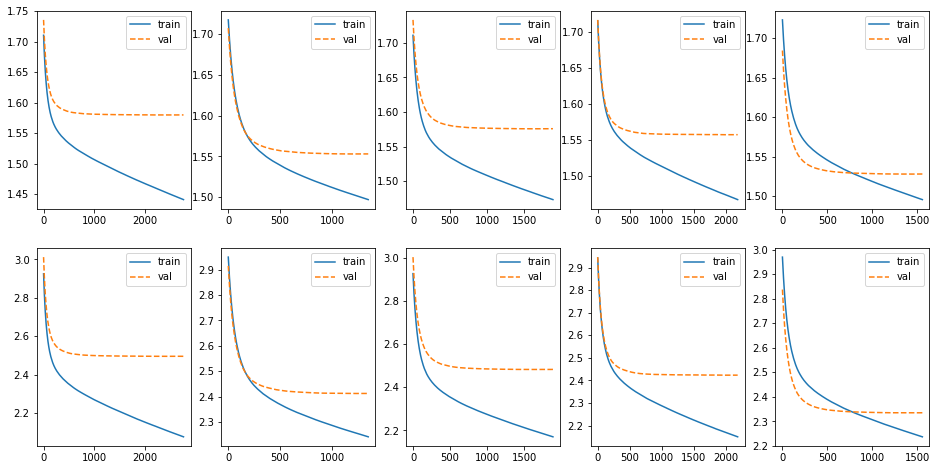

In [242]:
clf = LGBMRegressor(
    boosting_type='gbdt',
    num_leaves=31,
    max_depth=-1,
    learning_rate=0.01,
    n_estimators=10000,
    objective='regression',
    eval_metric='rmse',
    min_split_gain=0.0,
    min_child_weight=0.001,
    min_child_samples=30,
    subsample=1.0,
    colsample_bytree=1.0,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=4590,
    n_jobs=-1,
)

NFOLD = 5
skf = KFold(n_splits=NFOLD, shuffle=True, random_state=4590)

oof_train = np.zeros(len(df_train[df_train['outliers'] == 0]))

feature_importance_df = pd.DataFrame()
loss_csv = []
plt.figure(figsize=(16, 8))

for fold_, (trn_idx, val_idx) in enumerate(skf.split(df_train[df_train['outliers'] == 0])):
    print("fold {}".format(fold_))
    clf.fit(df_train[df_train['outliers'] == 0].iloc[trn_idx][features], target_no_outliers.iloc[trn_idx],
            eval_set=[(df_train[df_train['outliers'] == 0].iloc[trn_idx][features], target_no_outliers.iloc[trn_idx]),
                      (df_train[df_train['outliers'] == 0].iloc[val_idx][features], target_no_outliers.iloc[val_idx])],
            eval_metric=['rmse'], early_stopping_rounds=200, verbose=True)
    val_pre = clf.predict(df_train[df_train['outliers'] == 0].iloc[val_idx][features])
    oof_train[val_idx] = val_pre

    len_n = len(clf.evals_result_['valid_0']['rmse'])
    plt.subplot(2, 5, fold_ + 1)
    plt.plot(range(len_n), clf.evals_result_['valid_0']['rmse'], '-')
    plt.plot(range(len_n), clf.evals_result_['valid_1']['rmse'], '--')
    plt.legend(['train', 'val'])
    plt.subplot(2, 5, fold_ + 6)
    plt.plot(range(len_n), clf.evals_result_['valid_0']['l2'], '-')
    plt.plot(range(len_n), clf.evals_result_['valid_1']['l2'], '--')
    plt.legend(['train', 'val'])

    loss_csv.append(clf.best_score_['valid_1']['rmse'])
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

mean_loss = np.mean(loss_csv)
print('mean loss:', mean_loss)
plt.show()


## no drop outliers

In [243]:
target_have_outliers = df_train['target']
target_have_outliers.shape

(201917,)

fold 0
[1]	valid_0's rmse: 3.84412	valid_1's rmse: 3.85895
Training until validation scores don't improve for 200 rounds.
[2]	valid_0's rmse: 3.84072	valid_1's rmse: 3.85613
[3]	valid_0's rmse: 3.83738	valid_1's rmse: 3.85336
[4]	valid_0's rmse: 3.83411	valid_1's rmse: 3.85047
[5]	valid_0's rmse: 3.83091	valid_1's rmse: 3.84775
[6]	valid_0's rmse: 3.82778	valid_1's rmse: 3.84522
[7]	valid_0's rmse: 3.82472	valid_1's rmse: 3.84242
[8]	valid_0's rmse: 3.8217	valid_1's rmse: 3.83994
[9]	valid_0's rmse: 3.81869	valid_1's rmse: 3.83729
[10]	valid_0's rmse: 3.81575	valid_1's rmse: 3.83484
[11]	valid_0's rmse: 3.81282	valid_1's rmse: 3.83222
[12]	valid_0's rmse: 3.80996	valid_1's rmse: 3.82983
[13]	valid_0's rmse: 3.80715	valid_1's rmse: 3.82744
[14]	valid_0's rmse: 3.80437	valid_1's rmse: 3.82517
[15]	valid_0's rmse: 3.80161	valid_1's rmse: 3.8229
[16]	valid_0's rmse: 3.79894	valid_1's rmse: 3.82072
[17]	valid_0's rmse: 3.79631	valid_1's rmse: 3.81854
[18]	valid_0's rmse: 3.79369	valid_1's r

[155]	valid_0's rmse: 3.59631	valid_1's rmse: 3.69081
[156]	valid_0's rmse: 3.59543	valid_1's rmse: 3.69051
[157]	valid_0's rmse: 3.59462	valid_1's rmse: 3.69019
[158]	valid_0's rmse: 3.59386	valid_1's rmse: 3.6899
[159]	valid_0's rmse: 3.59306	valid_1's rmse: 3.68966
[160]	valid_0's rmse: 3.59219	valid_1's rmse: 3.68935
[161]	valid_0's rmse: 3.59141	valid_1's rmse: 3.68912
[162]	valid_0's rmse: 3.59063	valid_1's rmse: 3.68888
[163]	valid_0's rmse: 3.5899	valid_1's rmse: 3.68869
[164]	valid_0's rmse: 3.58911	valid_1's rmse: 3.68838
[165]	valid_0's rmse: 3.58834	valid_1's rmse: 3.68818
[166]	valid_0's rmse: 3.5875	valid_1's rmse: 3.68792
[167]	valid_0's rmse: 3.58678	valid_1's rmse: 3.6877
[168]	valid_0's rmse: 3.58592	valid_1's rmse: 3.68749
[169]	valid_0's rmse: 3.58504	valid_1's rmse: 3.68725
[170]	valid_0's rmse: 3.58431	valid_1's rmse: 3.68689
[171]	valid_0's rmse: 3.58353	valid_1's rmse: 3.6867
[172]	valid_0's rmse: 3.58286	valid_1's rmse: 3.68644
[173]	valid_0's rmse: 3.58192	val

[310]	valid_0's rmse: 3.4994	valid_1's rmse: 3.66652
[311]	valid_0's rmse: 3.49894	valid_1's rmse: 3.66636
[312]	valid_0's rmse: 3.49858	valid_1's rmse: 3.66629
[313]	valid_0's rmse: 3.49811	valid_1's rmse: 3.6663
[314]	valid_0's rmse: 3.4977	valid_1's rmse: 3.66626
[315]	valid_0's rmse: 3.49723	valid_1's rmse: 3.66615
[316]	valid_0's rmse: 3.49683	valid_1's rmse: 3.66603
[317]	valid_0's rmse: 3.49639	valid_1's rmse: 3.66594
[318]	valid_0's rmse: 3.49588	valid_1's rmse: 3.66583
[319]	valid_0's rmse: 3.49541	valid_1's rmse: 3.66584
[320]	valid_0's rmse: 3.49496	valid_1's rmse: 3.66572
[321]	valid_0's rmse: 3.49454	valid_1's rmse: 3.6657
[322]	valid_0's rmse: 3.49411	valid_1's rmse: 3.66565
[323]	valid_0's rmse: 3.49362	valid_1's rmse: 3.66563
[324]	valid_0's rmse: 3.49326	valid_1's rmse: 3.66559
[325]	valid_0's rmse: 3.4929	valid_1's rmse: 3.66544
[326]	valid_0's rmse: 3.4924	valid_1's rmse: 3.66537
[327]	valid_0's rmse: 3.49197	valid_1's rmse: 3.66521
[328]	valid_0's rmse: 3.49152	vali

[464]	valid_0's rmse: 3.43954	valid_1's rmse: 3.65789
[465]	valid_0's rmse: 3.43927	valid_1's rmse: 3.65779
[466]	valid_0's rmse: 3.43896	valid_1's rmse: 3.6578
[467]	valid_0's rmse: 3.43855	valid_1's rmse: 3.65776
[468]	valid_0's rmse: 3.43827	valid_1's rmse: 3.65767
[469]	valid_0's rmse: 3.43799	valid_1's rmse: 3.65773
[470]	valid_0's rmse: 3.43771	valid_1's rmse: 3.65773
[471]	valid_0's rmse: 3.43725	valid_1's rmse: 3.65769
[472]	valid_0's rmse: 3.43691	valid_1's rmse: 3.65774
[473]	valid_0's rmse: 3.43661	valid_1's rmse: 3.65768
[474]	valid_0's rmse: 3.43639	valid_1's rmse: 3.65766
[475]	valid_0's rmse: 3.43612	valid_1's rmse: 3.65766
[476]	valid_0's rmse: 3.4357	valid_1's rmse: 3.65758
[477]	valid_0's rmse: 3.43536	valid_1's rmse: 3.65757
[478]	valid_0's rmse: 3.43512	valid_1's rmse: 3.65751
[479]	valid_0's rmse: 3.43477	valid_1's rmse: 3.65754
[480]	valid_0's rmse: 3.43452	valid_1's rmse: 3.65751
[481]	valid_0's rmse: 3.43423	valid_1's rmse: 3.65746
[482]	valid_0's rmse: 3.43398	

[618]	valid_0's rmse: 3.39331	valid_1's rmse: 3.65394
[619]	valid_0's rmse: 3.39302	valid_1's rmse: 3.65395
[620]	valid_0's rmse: 3.39278	valid_1's rmse: 3.65388
[621]	valid_0's rmse: 3.39258	valid_1's rmse: 3.6539
[622]	valid_0's rmse: 3.39233	valid_1's rmse: 3.6539
[623]	valid_0's rmse: 3.39204	valid_1's rmse: 3.65393
[624]	valid_0's rmse: 3.39178	valid_1's rmse: 3.65393
[625]	valid_0's rmse: 3.39146	valid_1's rmse: 3.65397
[626]	valid_0's rmse: 3.39109	valid_1's rmse: 3.65389
[627]	valid_0's rmse: 3.39085	valid_1's rmse: 3.6539
[628]	valid_0's rmse: 3.39066	valid_1's rmse: 3.65387
[629]	valid_0's rmse: 3.39045	valid_1's rmse: 3.65389
[630]	valid_0's rmse: 3.39018	valid_1's rmse: 3.65392
[631]	valid_0's rmse: 3.39001	valid_1's rmse: 3.65389
[632]	valid_0's rmse: 3.3898	valid_1's rmse: 3.65391
[633]	valid_0's rmse: 3.38956	valid_1's rmse: 3.65391
[634]	valid_0's rmse: 3.38935	valid_1's rmse: 3.65389
[635]	valid_0's rmse: 3.38911	valid_1's rmse: 3.65384
[636]	valid_0's rmse: 3.38891	va

[774]	valid_0's rmse: 3.35645	valid_1's rmse: 3.65326
[775]	valid_0's rmse: 3.35627	valid_1's rmse: 3.65326
[776]	valid_0's rmse: 3.35605	valid_1's rmse: 3.65326
[777]	valid_0's rmse: 3.35575	valid_1's rmse: 3.6532
[778]	valid_0's rmse: 3.35552	valid_1's rmse: 3.65318
[779]	valid_0's rmse: 3.35522	valid_1's rmse: 3.65313
[780]	valid_0's rmse: 3.35499	valid_1's rmse: 3.65309
[781]	valid_0's rmse: 3.35481	valid_1's rmse: 3.65308
[782]	valid_0's rmse: 3.35462	valid_1's rmse: 3.65304
[783]	valid_0's rmse: 3.35431	valid_1's rmse: 3.653
[784]	valid_0's rmse: 3.35412	valid_1's rmse: 3.65296
[785]	valid_0's rmse: 3.35391	valid_1's rmse: 3.65297
[786]	valid_0's rmse: 3.35366	valid_1's rmse: 3.65297
[787]	valid_0's rmse: 3.3535	valid_1's rmse: 3.65298
[788]	valid_0's rmse: 3.3533	valid_1's rmse: 3.65297
[789]	valid_0's rmse: 3.35313	valid_1's rmse: 3.65299
[790]	valid_0's rmse: 3.35293	valid_1's rmse: 3.65302
[791]	valid_0's rmse: 3.35269	valid_1's rmse: 3.65302
[792]	valid_0's rmse: 3.35251	val

[929]	valid_0's rmse: 3.32401	valid_1's rmse: 3.65215
[930]	valid_0's rmse: 3.32386	valid_1's rmse: 3.65217
[931]	valid_0's rmse: 3.32371	valid_1's rmse: 3.6522
[932]	valid_0's rmse: 3.32358	valid_1's rmse: 3.65224
[933]	valid_0's rmse: 3.32331	valid_1's rmse: 3.6523
[934]	valid_0's rmse: 3.32317	valid_1's rmse: 3.65232
[935]	valid_0's rmse: 3.32301	valid_1's rmse: 3.6523
[936]	valid_0's rmse: 3.32276	valid_1's rmse: 3.65228
[937]	valid_0's rmse: 3.32259	valid_1's rmse: 3.65227
[938]	valid_0's rmse: 3.32234	valid_1's rmse: 3.65218
[939]	valid_0's rmse: 3.32219	valid_1's rmse: 3.65217
[940]	valid_0's rmse: 3.322	valid_1's rmse: 3.65213
[941]	valid_0's rmse: 3.3218	valid_1's rmse: 3.65209
[942]	valid_0's rmse: 3.32147	valid_1's rmse: 3.6521
[943]	valid_0's rmse: 3.32128	valid_1's rmse: 3.65205
[944]	valid_0's rmse: 3.32108	valid_1's rmse: 3.65207
[945]	valid_0's rmse: 3.32088	valid_1's rmse: 3.65207
[946]	valid_0's rmse: 3.32071	valid_1's rmse: 3.65208
[947]	valid_0's rmse: 3.32059	valid

[1080]	valid_0's rmse: 3.29586	valid_1's rmse: 3.65149
[1081]	valid_0's rmse: 3.29571	valid_1's rmse: 3.6515
[1082]	valid_0's rmse: 3.29546	valid_1's rmse: 3.65153
[1083]	valid_0's rmse: 3.29532	valid_1's rmse: 3.65155
[1084]	valid_0's rmse: 3.29521	valid_1's rmse: 3.65156
[1085]	valid_0's rmse: 3.29504	valid_1's rmse: 3.65155
[1086]	valid_0's rmse: 3.2949	valid_1's rmse: 3.65155
[1087]	valid_0's rmse: 3.29459	valid_1's rmse: 3.65159
[1088]	valid_0's rmse: 3.29437	valid_1's rmse: 3.65162
[1089]	valid_0's rmse: 3.29424	valid_1's rmse: 3.65166
[1090]	valid_0's rmse: 3.29413	valid_1's rmse: 3.65164
[1091]	valid_0's rmse: 3.29395	valid_1's rmse: 3.65162
[1092]	valid_0's rmse: 3.29373	valid_1's rmse: 3.65162
[1093]	valid_0's rmse: 3.29357	valid_1's rmse: 3.65165
[1094]	valid_0's rmse: 3.29344	valid_1's rmse: 3.65167
[1095]	valid_0's rmse: 3.2933	valid_1's rmse: 3.65166
[1096]	valid_0's rmse: 3.29308	valid_1's rmse: 3.65161
[1097]	valid_0's rmse: 3.29286	valid_1's rmse: 3.65162
[1098]	valid_

[1233]	valid_0's rmse: 3.26951	valid_1's rmse: 3.65147
[1234]	valid_0's rmse: 3.2694	valid_1's rmse: 3.65147
[1235]	valid_0's rmse: 3.26919	valid_1's rmse: 3.65152
[1236]	valid_0's rmse: 3.26895	valid_1's rmse: 3.65152
[1237]	valid_0's rmse: 3.26875	valid_1's rmse: 3.65149
[1238]	valid_0's rmse: 3.26852	valid_1's rmse: 3.6514
[1239]	valid_0's rmse: 3.26835	valid_1's rmse: 3.65139
[1240]	valid_0's rmse: 3.26815	valid_1's rmse: 3.65138
[1241]	valid_0's rmse: 3.26793	valid_1's rmse: 3.65137
[1242]	valid_0's rmse: 3.26774	valid_1's rmse: 3.65137
[1243]	valid_0's rmse: 3.26757	valid_1's rmse: 3.65133
[1244]	valid_0's rmse: 3.26741	valid_1's rmse: 3.65134
[1245]	valid_0's rmse: 3.2673	valid_1's rmse: 3.65136
[1246]	valid_0's rmse: 3.26713	valid_1's rmse: 3.65135
[1247]	valid_0's rmse: 3.26703	valid_1's rmse: 3.65136
[1248]	valid_0's rmse: 3.26682	valid_1's rmse: 3.65134
[1249]	valid_0's rmse: 3.26666	valid_1's rmse: 3.65137
[1250]	valid_0's rmse: 3.26653	valid_1's rmse: 3.65138
[1251]	valid_

[1385]	valid_0's rmse: 3.24447	valid_1's rmse: 3.65187
[1386]	valid_0's rmse: 3.24431	valid_1's rmse: 3.65191
[1387]	valid_0's rmse: 3.24418	valid_1's rmse: 3.65191
[1388]	valid_0's rmse: 3.2441	valid_1's rmse: 3.65189
[1389]	valid_0's rmse: 3.24392	valid_1's rmse: 3.65189
[1390]	valid_0's rmse: 3.24377	valid_1's rmse: 3.65192
[1391]	valid_0's rmse: 3.24358	valid_1's rmse: 3.65195
[1392]	valid_0's rmse: 3.24331	valid_1's rmse: 3.65198
[1393]	valid_0's rmse: 3.24318	valid_1's rmse: 3.65195
[1394]	valid_0's rmse: 3.24301	valid_1's rmse: 3.65194
[1395]	valid_0's rmse: 3.24283	valid_1's rmse: 3.6519
[1396]	valid_0's rmse: 3.24266	valid_1's rmse: 3.65192
[1397]	valid_0's rmse: 3.2425	valid_1's rmse: 3.65193
[1398]	valid_0's rmse: 3.2423	valid_1's rmse: 3.65193
[1399]	valid_0's rmse: 3.24199	valid_1's rmse: 3.65194
[1400]	valid_0's rmse: 3.24184	valid_1's rmse: 3.65194
[1401]	valid_0's rmse: 3.24175	valid_1's rmse: 3.65196
[1402]	valid_0's rmse: 3.24163	valid_1's rmse: 3.65196
[1403]	valid_0

[114]	valid_0's rmse: 3.63565	valid_1's rmse: 3.70275
[115]	valid_0's rmse: 3.63465	valid_1's rmse: 3.70234
[116]	valid_0's rmse: 3.63356	valid_1's rmse: 3.70185
[117]	valid_0's rmse: 3.63243	valid_1's rmse: 3.70131
[118]	valid_0's rmse: 3.63133	valid_1's rmse: 3.70068
[119]	valid_0's rmse: 3.63029	valid_1's rmse: 3.70017
[120]	valid_0's rmse: 3.62932	valid_1's rmse: 3.69964
[121]	valid_0's rmse: 3.62839	valid_1's rmse: 3.69927
[122]	valid_0's rmse: 3.62733	valid_1's rmse: 3.69855
[123]	valid_0's rmse: 3.62634	valid_1's rmse: 3.69826
[124]	valid_0's rmse: 3.62532	valid_1's rmse: 3.6977
[125]	valid_0's rmse: 3.62442	valid_1's rmse: 3.69733
[126]	valid_0's rmse: 3.62345	valid_1's rmse: 3.69703
[127]	valid_0's rmse: 3.62249	valid_1's rmse: 3.69661
[128]	valid_0's rmse: 3.6215	valid_1's rmse: 3.69625
[129]	valid_0's rmse: 3.62053	valid_1's rmse: 3.69587
[130]	valid_0's rmse: 3.61942	valid_1's rmse: 3.69534
[131]	valid_0's rmse: 3.61844	valid_1's rmse: 3.69495
[132]	valid_0's rmse: 3.61749	

[267]	valid_0's rmse: 3.52019	valid_1's rmse: 3.66401
[268]	valid_0's rmse: 3.51972	valid_1's rmse: 3.66388
[269]	valid_0's rmse: 3.51915	valid_1's rmse: 3.66386
[270]	valid_0's rmse: 3.51867	valid_1's rmse: 3.66375
[271]	valid_0's rmse: 3.51817	valid_1's rmse: 3.66357
[272]	valid_0's rmse: 3.5177	valid_1's rmse: 3.66345
[273]	valid_0's rmse: 3.51722	valid_1's rmse: 3.66332
[274]	valid_0's rmse: 3.51677	valid_1's rmse: 3.66329
[275]	valid_0's rmse: 3.51612	valid_1's rmse: 3.66316
[276]	valid_0's rmse: 3.51566	valid_1's rmse: 3.66304
[277]	valid_0's rmse: 3.51518	valid_1's rmse: 3.66295
[278]	valid_0's rmse: 3.51461	valid_1's rmse: 3.66272
[279]	valid_0's rmse: 3.51414	valid_1's rmse: 3.66258
[280]	valid_0's rmse: 3.51369	valid_1's rmse: 3.66242
[281]	valid_0's rmse: 3.51322	valid_1's rmse: 3.66227
[282]	valid_0's rmse: 3.51277	valid_1's rmse: 3.66211
[283]	valid_0's rmse: 3.51221	valid_1's rmse: 3.66197
[284]	valid_0's rmse: 3.51168	valid_1's rmse: 3.66182
[285]	valid_0's rmse: 3.51119

[420]	valid_0's rmse: 3.45349	valid_1's rmse: 3.65347
[421]	valid_0's rmse: 3.45304	valid_1's rmse: 3.65346
[422]	valid_0's rmse: 3.45273	valid_1's rmse: 3.65341
[423]	valid_0's rmse: 3.45243	valid_1's rmse: 3.65337
[424]	valid_0's rmse: 3.45215	valid_1's rmse: 3.65334
[425]	valid_0's rmse: 3.4517	valid_1's rmse: 3.65332
[426]	valid_0's rmse: 3.45135	valid_1's rmse: 3.65323
[427]	valid_0's rmse: 3.45088	valid_1's rmse: 3.65322
[428]	valid_0's rmse: 3.4505	valid_1's rmse: 3.65322
[429]	valid_0's rmse: 3.45019	valid_1's rmse: 3.6532
[430]	valid_0's rmse: 3.44989	valid_1's rmse: 3.65317
[431]	valid_0's rmse: 3.44933	valid_1's rmse: 3.65309
[432]	valid_0's rmse: 3.44906	valid_1's rmse: 3.65303
[433]	valid_0's rmse: 3.44874	valid_1's rmse: 3.65294
[434]	valid_0's rmse: 3.44839	valid_1's rmse: 3.6529
[435]	valid_0's rmse: 3.44813	valid_1's rmse: 3.65285
[436]	valid_0's rmse: 3.44775	valid_1's rmse: 3.65283
[437]	valid_0's rmse: 3.44749	valid_1's rmse: 3.65282
[438]	valid_0's rmse: 3.44715	va

[575]	valid_0's rmse: 3.40174	valid_1's rmse: 3.6483
[576]	valid_0's rmse: 3.40153	valid_1's rmse: 3.64827
[577]	valid_0's rmse: 3.40122	valid_1's rmse: 3.64828
[578]	valid_0's rmse: 3.40098	valid_1's rmse: 3.64826
[579]	valid_0's rmse: 3.40074	valid_1's rmse: 3.64818
[580]	valid_0's rmse: 3.40045	valid_1's rmse: 3.64816
[581]	valid_0's rmse: 3.40027	valid_1's rmse: 3.64816
[582]	valid_0's rmse: 3.40004	valid_1's rmse: 3.64814
[583]	valid_0's rmse: 3.39987	valid_1's rmse: 3.64812
[584]	valid_0's rmse: 3.39957	valid_1's rmse: 3.64814
[585]	valid_0's rmse: 3.39926	valid_1's rmse: 3.64811
[586]	valid_0's rmse: 3.39899	valid_1's rmse: 3.6481
[587]	valid_0's rmse: 3.39868	valid_1's rmse: 3.64809
[588]	valid_0's rmse: 3.39834	valid_1's rmse: 3.64807
[589]	valid_0's rmse: 3.39811	valid_1's rmse: 3.64803
[590]	valid_0's rmse: 3.39756	valid_1's rmse: 3.64798
[591]	valid_0's rmse: 3.39716	valid_1's rmse: 3.64789
[592]	valid_0's rmse: 3.39689	valid_1's rmse: 3.64783
[593]	valid_0's rmse: 3.39668	

[729]	valid_0's rmse: 3.36447	valid_1's rmse: 3.64677
[730]	valid_0's rmse: 3.36432	valid_1's rmse: 3.64676
[731]	valid_0's rmse: 3.36404	valid_1's rmse: 3.64681
[732]	valid_0's rmse: 3.36387	valid_1's rmse: 3.64681
[733]	valid_0's rmse: 3.36374	valid_1's rmse: 3.6468
[734]	valid_0's rmse: 3.36347	valid_1's rmse: 3.64677
[735]	valid_0's rmse: 3.36315	valid_1's rmse: 3.64674
[736]	valid_0's rmse: 3.36286	valid_1's rmse: 3.64669
[737]	valid_0's rmse: 3.36267	valid_1's rmse: 3.64669
[738]	valid_0's rmse: 3.3624	valid_1's rmse: 3.64671
[739]	valid_0's rmse: 3.36219	valid_1's rmse: 3.64667
[740]	valid_0's rmse: 3.36185	valid_1's rmse: 3.64658
[741]	valid_0's rmse: 3.36163	valid_1's rmse: 3.64658
[742]	valid_0's rmse: 3.36134	valid_1's rmse: 3.64656
[743]	valid_0's rmse: 3.36119	valid_1's rmse: 3.64657
[744]	valid_0's rmse: 3.36099	valid_1's rmse: 3.64657
[745]	valid_0's rmse: 3.36079	valid_1's rmse: 3.64659
[746]	valid_0's rmse: 3.36054	valid_1's rmse: 3.64658
[747]	valid_0's rmse: 3.36031	

[883]	valid_0's rmse: 3.33162	valid_1's rmse: 3.64651
[884]	valid_0's rmse: 3.3315	valid_1's rmse: 3.64652
[885]	valid_0's rmse: 3.3312	valid_1's rmse: 3.64656
[886]	valid_0's rmse: 3.33093	valid_1's rmse: 3.64659
[887]	valid_0's rmse: 3.33073	valid_1's rmse: 3.64659
[888]	valid_0's rmse: 3.33051	valid_1's rmse: 3.64657
[889]	valid_0's rmse: 3.33034	valid_1's rmse: 3.64656
[890]	valid_0's rmse: 3.33018	valid_1's rmse: 3.64657
[891]	valid_0's rmse: 3.33001	valid_1's rmse: 3.64657
[892]	valid_0's rmse: 3.32982	valid_1's rmse: 3.64658
[893]	valid_0's rmse: 3.32968	valid_1's rmse: 3.64656
[894]	valid_0's rmse: 3.32944	valid_1's rmse: 3.64656
[895]	valid_0's rmse: 3.32928	valid_1's rmse: 3.64657
[896]	valid_0's rmse: 3.32916	valid_1's rmse: 3.64655
[897]	valid_0's rmse: 3.32904	valid_1's rmse: 3.64654
[898]	valid_0's rmse: 3.32886	valid_1's rmse: 3.64653
[899]	valid_0's rmse: 3.32868	valid_1's rmse: 3.64658
[900]	valid_0's rmse: 3.32855	valid_1's rmse: 3.6466
[901]	valid_0's rmse: 3.32843	v

[22]	valid_0's rmse: 3.78326	valid_1's rmse: 3.80504
[23]	valid_0's rmse: 3.78068	valid_1's rmse: 3.80318
[24]	valid_0's rmse: 3.77807	valid_1's rmse: 3.80149
[25]	valid_0's rmse: 3.77564	valid_1's rmse: 3.79965
[26]	valid_0's rmse: 3.7731	valid_1's rmse: 3.79774
[27]	valid_0's rmse: 3.77067	valid_1's rmse: 3.79606
[28]	valid_0's rmse: 3.76828	valid_1's rmse: 3.79446
[29]	valid_0's rmse: 3.76598	valid_1's rmse: 3.7928
[30]	valid_0's rmse: 3.76365	valid_1's rmse: 3.79092
[31]	valid_0's rmse: 3.76133	valid_1's rmse: 3.78915
[32]	valid_0's rmse: 3.75904	valid_1's rmse: 3.7873
[33]	valid_0's rmse: 3.75686	valid_1's rmse: 3.78578
[34]	valid_0's rmse: 3.7546	valid_1's rmse: 3.78418
[35]	valid_0's rmse: 3.75242	valid_1's rmse: 3.78274
[36]	valid_0's rmse: 3.75024	valid_1's rmse: 3.78116
[37]	valid_0's rmse: 3.74816	valid_1's rmse: 3.77971
[38]	valid_0's rmse: 3.74603	valid_1's rmse: 3.77841
[39]	valid_0's rmse: 3.74393	valid_1's rmse: 3.77707
[40]	valid_0's rmse: 3.74191	valid_1's rmse: 3.775

[177]	valid_0's rmse: 3.57492	valid_1's rmse: 3.69431
[178]	valid_0's rmse: 3.57418	valid_1's rmse: 3.69399
[179]	valid_0's rmse: 3.57337	valid_1's rmse: 3.69366
[180]	valid_0's rmse: 3.5726	valid_1's rmse: 3.69339
[181]	valid_0's rmse: 3.57186	valid_1's rmse: 3.69315
[182]	valid_0's rmse: 3.57109	valid_1's rmse: 3.69301
[183]	valid_0's rmse: 3.57034	valid_1's rmse: 3.69284
[184]	valid_0's rmse: 3.56959	valid_1's rmse: 3.69252
[185]	valid_0's rmse: 3.56889	valid_1's rmse: 3.69242
[186]	valid_0's rmse: 3.56821	valid_1's rmse: 3.69231
[187]	valid_0's rmse: 3.56746	valid_1's rmse: 3.69202
[188]	valid_0's rmse: 3.56678	valid_1's rmse: 3.69191
[189]	valid_0's rmse: 3.56612	valid_1's rmse: 3.69181
[190]	valid_0's rmse: 3.56542	valid_1's rmse: 3.69159
[191]	valid_0's rmse: 3.56467	valid_1's rmse: 3.69115
[192]	valid_0's rmse: 3.564	valid_1's rmse: 3.69098
[193]	valid_0's rmse: 3.56335	valid_1's rmse: 3.69077
[194]	valid_0's rmse: 3.56274	valid_1's rmse: 3.6905
[195]	valid_0's rmse: 3.56209	va

[333]	valid_0's rmse: 3.48497	valid_1's rmse: 3.67229
[334]	valid_0's rmse: 3.48461	valid_1's rmse: 3.67217
[335]	valid_0's rmse: 3.48414	valid_1's rmse: 3.67216
[336]	valid_0's rmse: 3.48371	valid_1's rmse: 3.67207
[337]	valid_0's rmse: 3.48328	valid_1's rmse: 3.67196
[338]	valid_0's rmse: 3.48277	valid_1's rmse: 3.67193
[339]	valid_0's rmse: 3.48223	valid_1's rmse: 3.67191
[340]	valid_0's rmse: 3.4818	valid_1's rmse: 3.67185
[341]	valid_0's rmse: 3.48138	valid_1's rmse: 3.67174
[342]	valid_0's rmse: 3.48108	valid_1's rmse: 3.6716
[343]	valid_0's rmse: 3.48054	valid_1's rmse: 3.67158
[344]	valid_0's rmse: 3.48006	valid_1's rmse: 3.67146
[345]	valid_0's rmse: 3.47963	valid_1's rmse: 3.67144
[346]	valid_0's rmse: 3.47919	valid_1's rmse: 3.6714
[347]	valid_0's rmse: 3.47879	valid_1's rmse: 3.67135
[348]	valid_0's rmse: 3.47831	valid_1's rmse: 3.67131
[349]	valid_0's rmse: 3.47791	valid_1's rmse: 3.6713
[350]	valid_0's rmse: 3.47741	valid_1's rmse: 3.67124
[351]	valid_0's rmse: 3.4769	val

[486]	valid_0's rmse: 3.42796	valid_1's rmse: 3.66436
[487]	valid_0's rmse: 3.4276	valid_1's rmse: 3.66438
[488]	valid_0's rmse: 3.4272	valid_1's rmse: 3.66432
[489]	valid_0's rmse: 3.42691	valid_1's rmse: 3.66428
[490]	valid_0's rmse: 3.42646	valid_1's rmse: 3.6643
[491]	valid_0's rmse: 3.42624	valid_1's rmse: 3.66424
[492]	valid_0's rmse: 3.42582	valid_1's rmse: 3.66418
[493]	valid_0's rmse: 3.4253	valid_1's rmse: 3.66416
[494]	valid_0's rmse: 3.42489	valid_1's rmse: 3.66408
[495]	valid_0's rmse: 3.42451	valid_1's rmse: 3.66404
[496]	valid_0's rmse: 3.42426	valid_1's rmse: 3.66402
[497]	valid_0's rmse: 3.42403	valid_1's rmse: 3.66397
[498]	valid_0's rmse: 3.42354	valid_1's rmse: 3.66393
[499]	valid_0's rmse: 3.42323	valid_1's rmse: 3.6639
[500]	valid_0's rmse: 3.42289	valid_1's rmse: 3.66391
[501]	valid_0's rmse: 3.42259	valid_1's rmse: 3.66384
[502]	valid_0's rmse: 3.42234	valid_1's rmse: 3.66385
[503]	valid_0's rmse: 3.42186	valid_1's rmse: 3.66381
[504]	valid_0's rmse: 3.4216	vali

[641]	valid_0's rmse: 3.38206	valid_1's rmse: 3.66078
[642]	valid_0's rmse: 3.38181	valid_1's rmse: 3.66069
[643]	valid_0's rmse: 3.38152	valid_1's rmse: 3.66064
[644]	valid_0's rmse: 3.38135	valid_1's rmse: 3.66064
[645]	valid_0's rmse: 3.38115	valid_1's rmse: 3.6606
[646]	valid_0's rmse: 3.3809	valid_1's rmse: 3.66059
[647]	valid_0's rmse: 3.38061	valid_1's rmse: 3.66058
[648]	valid_0's rmse: 3.38032	valid_1's rmse: 3.6606
[649]	valid_0's rmse: 3.3801	valid_1's rmse: 3.66059
[650]	valid_0's rmse: 3.3799	valid_1's rmse: 3.66056
[651]	valid_0's rmse: 3.37969	valid_1's rmse: 3.66052
[652]	valid_0's rmse: 3.3794	valid_1's rmse: 3.6605
[653]	valid_0's rmse: 3.37922	valid_1's rmse: 3.66052
[654]	valid_0's rmse: 3.37905	valid_1's rmse: 3.66053
[655]	valid_0's rmse: 3.37873	valid_1's rmse: 3.66051
[656]	valid_0's rmse: 3.37853	valid_1's rmse: 3.6605
[657]	valid_0's rmse: 3.37835	valid_1's rmse: 3.66044
[658]	valid_0's rmse: 3.37804	valid_1's rmse: 3.66043
[659]	valid_0's rmse: 3.3778	valid_1

[796]	valid_0's rmse: 3.34596	valid_1's rmse: 3.65959
[797]	valid_0's rmse: 3.34579	valid_1's rmse: 3.65957
[798]	valid_0's rmse: 3.34559	valid_1's rmse: 3.65954
[799]	valid_0's rmse: 3.34542	valid_1's rmse: 3.65957
[800]	valid_0's rmse: 3.34525	valid_1's rmse: 3.65957
[801]	valid_0's rmse: 3.34508	valid_1's rmse: 3.6595
[802]	valid_0's rmse: 3.34493	valid_1's rmse: 3.65951
[803]	valid_0's rmse: 3.34476	valid_1's rmse: 3.65954
[804]	valid_0's rmse: 3.34451	valid_1's rmse: 3.65959
[805]	valid_0's rmse: 3.34434	valid_1's rmse: 3.65955
[806]	valid_0's rmse: 3.34412	valid_1's rmse: 3.65952
[807]	valid_0's rmse: 3.34391	valid_1's rmse: 3.65951
[808]	valid_0's rmse: 3.34365	valid_1's rmse: 3.65948
[809]	valid_0's rmse: 3.34343	valid_1's rmse: 3.6595
[810]	valid_0's rmse: 3.34325	valid_1's rmse: 3.65951
[811]	valid_0's rmse: 3.34301	valid_1's rmse: 3.65947
[812]	valid_0's rmse: 3.34275	valid_1's rmse: 3.65939
[813]	valid_0's rmse: 3.34258	valid_1's rmse: 3.65938
[814]	valid_0's rmse: 3.34233	

[953]	valid_0's rmse: 3.31429	valid_1's rmse: 3.65745
[954]	valid_0's rmse: 3.31406	valid_1's rmse: 3.65744
[955]	valid_0's rmse: 3.31391	valid_1's rmse: 3.65746
[956]	valid_0's rmse: 3.31369	valid_1's rmse: 3.65741
[957]	valid_0's rmse: 3.31352	valid_1's rmse: 3.65743
[958]	valid_0's rmse: 3.31336	valid_1's rmse: 3.65745
[959]	valid_0's rmse: 3.31322	valid_1's rmse: 3.65746
[960]	valid_0's rmse: 3.31305	valid_1's rmse: 3.65747
[961]	valid_0's rmse: 3.31286	valid_1's rmse: 3.65748
[962]	valid_0's rmse: 3.31271	valid_1's rmse: 3.65751
[963]	valid_0's rmse: 3.31242	valid_1's rmse: 3.65755
[964]	valid_0's rmse: 3.31217	valid_1's rmse: 3.65752
[965]	valid_0's rmse: 3.31203	valid_1's rmse: 3.65752
[966]	valid_0's rmse: 3.31182	valid_1's rmse: 3.6575
[967]	valid_0's rmse: 3.3117	valid_1's rmse: 3.65751
[968]	valid_0's rmse: 3.31153	valid_1's rmse: 3.65752
[969]	valid_0's rmse: 3.3113	valid_1's rmse: 3.65754
[970]	valid_0's rmse: 3.31111	valid_1's rmse: 3.65759
[971]	valid_0's rmse: 3.31091	v

[1105]	valid_0's rmse: 3.28695	valid_1's rmse: 3.65632
[1106]	valid_0's rmse: 3.28684	valid_1's rmse: 3.6563
[1107]	valid_0's rmse: 3.28671	valid_1's rmse: 3.65631
[1108]	valid_0's rmse: 3.28657	valid_1's rmse: 3.65632
[1109]	valid_0's rmse: 3.28642	valid_1's rmse: 3.65629
[1110]	valid_0's rmse: 3.28625	valid_1's rmse: 3.65626
[1111]	valid_0's rmse: 3.28615	valid_1's rmse: 3.65626
[1112]	valid_0's rmse: 3.28601	valid_1's rmse: 3.65625
[1113]	valid_0's rmse: 3.28581	valid_1's rmse: 3.65626
[1114]	valid_0's rmse: 3.28572	valid_1's rmse: 3.65625
[1115]	valid_0's rmse: 3.28559	valid_1's rmse: 3.65624
[1116]	valid_0's rmse: 3.2854	valid_1's rmse: 3.65622
[1117]	valid_0's rmse: 3.28511	valid_1's rmse: 3.65621
[1118]	valid_0's rmse: 3.28491	valid_1's rmse: 3.65616
[1119]	valid_0's rmse: 3.28467	valid_1's rmse: 3.65615
[1120]	valid_0's rmse: 3.28454	valid_1's rmse: 3.65617
[1121]	valid_0's rmse: 3.2844	valid_1's rmse: 3.65619
[1122]	valid_0's rmse: 3.28411	valid_1's rmse: 3.6562
[1123]	valid_0

[1259]	valid_0's rmse: 3.26241	valid_1's rmse: 3.65582
[1260]	valid_0's rmse: 3.2622	valid_1's rmse: 3.65586
[1261]	valid_0's rmse: 3.26205	valid_1's rmse: 3.65586
[1262]	valid_0's rmse: 3.2618	valid_1's rmse: 3.65589
[1263]	valid_0's rmse: 3.26168	valid_1's rmse: 3.65588
[1264]	valid_0's rmse: 3.26158	valid_1's rmse: 3.65587
[1265]	valid_0's rmse: 3.26146	valid_1's rmse: 3.65587
[1266]	valid_0's rmse: 3.26137	valid_1's rmse: 3.65587
[1267]	valid_0's rmse: 3.26123	valid_1's rmse: 3.65588
[1268]	valid_0's rmse: 3.26109	valid_1's rmse: 3.65589
[1269]	valid_0's rmse: 3.26098	valid_1's rmse: 3.65589
[1270]	valid_0's rmse: 3.26079	valid_1's rmse: 3.65583
[1271]	valid_0's rmse: 3.26063	valid_1's rmse: 3.65573
[1272]	valid_0's rmse: 3.26043	valid_1's rmse: 3.6557
[1273]	valid_0's rmse: 3.26032	valid_1's rmse: 3.65569
[1274]	valid_0's rmse: 3.26016	valid_1's rmse: 3.6557
[1275]	valid_0's rmse: 3.26008	valid_1's rmse: 3.6557
[1276]	valid_0's rmse: 3.25981	valid_1's rmse: 3.65573
[1277]	valid_0'

[1412]	valid_0's rmse: 3.23823	valid_1's rmse: 3.656
[1413]	valid_0's rmse: 3.23808	valid_1's rmse: 3.65605
[1414]	valid_0's rmse: 3.23795	valid_1's rmse: 3.65606
[1415]	valid_0's rmse: 3.23779	valid_1's rmse: 3.65605
[1416]	valid_0's rmse: 3.23767	valid_1's rmse: 3.65605
[1417]	valid_0's rmse: 3.23746	valid_1's rmse: 3.65601
[1418]	valid_0's rmse: 3.23737	valid_1's rmse: 3.65603
[1419]	valid_0's rmse: 3.23711	valid_1's rmse: 3.65603
[1420]	valid_0's rmse: 3.23697	valid_1's rmse: 3.65603
[1421]	valid_0's rmse: 3.23685	valid_1's rmse: 3.65602
[1422]	valid_0's rmse: 3.23668	valid_1's rmse: 3.65598
[1423]	valid_0's rmse: 3.23649	valid_1's rmse: 3.65598
[1424]	valid_0's rmse: 3.23639	valid_1's rmse: 3.65599
[1425]	valid_0's rmse: 3.23623	valid_1's rmse: 3.65595
[1426]	valid_0's rmse: 3.23614	valid_1's rmse: 3.65593
Early stopping, best iteration is:
[1226]	valid_0's rmse: 3.26752	valid_1's rmse: 3.65557
fold 3
[1]	valid_0's rmse: 3.84714	valid_1's rmse: 3.84715
Training until validation sc

[141]	valid_0's rmse: 3.6045	valid_1's rmse: 3.70366
[142]	valid_0's rmse: 3.60352	valid_1's rmse: 3.70332
[143]	valid_0's rmse: 3.60257	valid_1's rmse: 3.70299
[144]	valid_0's rmse: 3.60163	valid_1's rmse: 3.70243
[145]	valid_0's rmse: 3.60067	valid_1's rmse: 3.70229
[146]	valid_0's rmse: 3.59975	valid_1's rmse: 3.70197
[147]	valid_0's rmse: 3.59898	valid_1's rmse: 3.70147
[148]	valid_0's rmse: 3.59809	valid_1's rmse: 3.70115
[149]	valid_0's rmse: 3.59724	valid_1's rmse: 3.70085
[150]	valid_0's rmse: 3.59625	valid_1's rmse: 3.70048
[151]	valid_0's rmse: 3.5954	valid_1's rmse: 3.70027
[152]	valid_0's rmse: 3.59448	valid_1's rmse: 3.69986
[153]	valid_0's rmse: 3.59353	valid_1's rmse: 3.69975
[154]	valid_0's rmse: 3.59266	valid_1's rmse: 3.69943
[155]	valid_0's rmse: 3.59178	valid_1's rmse: 3.69916
[156]	valid_0's rmse: 3.59089	valid_1's rmse: 3.6988
[157]	valid_0's rmse: 3.59004	valid_1's rmse: 3.6985
[158]	valid_0's rmse: 3.58916	valid_1's rmse: 3.69828
[159]	valid_0's rmse: 3.58828	va

[297]	valid_0's rmse: 3.50042	valid_1's rmse: 3.67626
[298]	valid_0's rmse: 3.49996	valid_1's rmse: 3.67605
[299]	valid_0's rmse: 3.49935	valid_1's rmse: 3.67589
[300]	valid_0's rmse: 3.49882	valid_1's rmse: 3.67578
[301]	valid_0's rmse: 3.49834	valid_1's rmse: 3.67576
[302]	valid_0's rmse: 3.49778	valid_1's rmse: 3.67569
[303]	valid_0's rmse: 3.49729	valid_1's rmse: 3.67567
[304]	valid_0's rmse: 3.49668	valid_1's rmse: 3.6756
[305]	valid_0's rmse: 3.49625	valid_1's rmse: 3.67554
[306]	valid_0's rmse: 3.49581	valid_1's rmse: 3.67552
[307]	valid_0's rmse: 3.49539	valid_1's rmse: 3.67549
[308]	valid_0's rmse: 3.4949	valid_1's rmse: 3.67541
[309]	valid_0's rmse: 3.49445	valid_1's rmse: 3.67533
[310]	valid_0's rmse: 3.49398	valid_1's rmse: 3.67523
[311]	valid_0's rmse: 3.49355	valid_1's rmse: 3.67509
[312]	valid_0's rmse: 3.49313	valid_1's rmse: 3.67506
[313]	valid_0's rmse: 3.49264	valid_1's rmse: 3.67498
[314]	valid_0's rmse: 3.49212	valid_1's rmse: 3.67486
[315]	valid_0's rmse: 3.49174	

[452]	valid_0's rmse: 3.43724	valid_1's rmse: 3.66815
[453]	valid_0's rmse: 3.43675	valid_1's rmse: 3.66817
[454]	valid_0's rmse: 3.43644	valid_1's rmse: 3.66815
[455]	valid_0's rmse: 3.43614	valid_1's rmse: 3.66813
[456]	valid_0's rmse: 3.43576	valid_1's rmse: 3.66818
[457]	valid_0's rmse: 3.43542	valid_1's rmse: 3.66807
[458]	valid_0's rmse: 3.43505	valid_1's rmse: 3.6681
[459]	valid_0's rmse: 3.43479	valid_1's rmse: 3.66808
[460]	valid_0's rmse: 3.43448	valid_1's rmse: 3.66806
[461]	valid_0's rmse: 3.43418	valid_1's rmse: 3.66805
[462]	valid_0's rmse: 3.43376	valid_1's rmse: 3.66796
[463]	valid_0's rmse: 3.43354	valid_1's rmse: 3.66792
[464]	valid_0's rmse: 3.43333	valid_1's rmse: 3.66793
[465]	valid_0's rmse: 3.43299	valid_1's rmse: 3.66791
[466]	valid_0's rmse: 3.43263	valid_1's rmse: 3.66788
[467]	valid_0's rmse: 3.43237	valid_1's rmse: 3.66783
[468]	valid_0's rmse: 3.43209	valid_1's rmse: 3.66778
[469]	valid_0's rmse: 3.43175	valid_1's rmse: 3.66777
[470]	valid_0's rmse: 3.43133

[609]	valid_0's rmse: 3.3914	valid_1's rmse: 3.66406
[610]	valid_0's rmse: 3.39122	valid_1's rmse: 3.66409
[611]	valid_0's rmse: 3.39088	valid_1's rmse: 3.66408
[612]	valid_0's rmse: 3.39061	valid_1's rmse: 3.66407
[613]	valid_0's rmse: 3.39042	valid_1's rmse: 3.66403
[614]	valid_0's rmse: 3.39012	valid_1's rmse: 3.66397
[615]	valid_0's rmse: 3.38985	valid_1's rmse: 3.66397
[616]	valid_0's rmse: 3.38958	valid_1's rmse: 3.66396
[617]	valid_0's rmse: 3.38938	valid_1's rmse: 3.66394
[618]	valid_0's rmse: 3.38911	valid_1's rmse: 3.66391
[619]	valid_0's rmse: 3.38893	valid_1's rmse: 3.66389
[620]	valid_0's rmse: 3.38874	valid_1's rmse: 3.66388
[621]	valid_0's rmse: 3.38828	valid_1's rmse: 3.66381
[622]	valid_0's rmse: 3.38802	valid_1's rmse: 3.66375
[623]	valid_0's rmse: 3.38778	valid_1's rmse: 3.66375
[624]	valid_0's rmse: 3.38756	valid_1's rmse: 3.66377
[625]	valid_0's rmse: 3.3873	valid_1's rmse: 3.66377
[626]	valid_0's rmse: 3.38702	valid_1's rmse: 3.66371
[627]	valid_0's rmse: 3.38674	

[762]	valid_0's rmse: 3.35645	valid_1's rmse: 3.66258
[763]	valid_0's rmse: 3.35626	valid_1's rmse: 3.66263
[764]	valid_0's rmse: 3.35582	valid_1's rmse: 3.66263
[765]	valid_0's rmse: 3.35549	valid_1's rmse: 3.66264
[766]	valid_0's rmse: 3.35535	valid_1's rmse: 3.66264
[767]	valid_0's rmse: 3.3552	valid_1's rmse: 3.66263
[768]	valid_0's rmse: 3.35502	valid_1's rmse: 3.66264
[769]	valid_0's rmse: 3.35489	valid_1's rmse: 3.66257
[770]	valid_0's rmse: 3.35467	valid_1's rmse: 3.66252
[771]	valid_0's rmse: 3.35451	valid_1's rmse: 3.66247
[772]	valid_0's rmse: 3.35432	valid_1's rmse: 3.66243
[773]	valid_0's rmse: 3.35412	valid_1's rmse: 3.66247
[774]	valid_0's rmse: 3.35393	valid_1's rmse: 3.66246
[775]	valid_0's rmse: 3.35375	valid_1's rmse: 3.66243
[776]	valid_0's rmse: 3.35354	valid_1's rmse: 3.6625
[777]	valid_0's rmse: 3.3534	valid_1's rmse: 3.6625
[778]	valid_0's rmse: 3.35321	valid_1's rmse: 3.6625
[779]	valid_0's rmse: 3.35277	valid_1's rmse: 3.6626
[780]	valid_0's rmse: 3.35252	vali

[918]	valid_0's rmse: 3.32439	valid_1's rmse: 3.66201
[919]	valid_0's rmse: 3.32401	valid_1's rmse: 3.66204
[920]	valid_0's rmse: 3.3237	valid_1's rmse: 3.66208
[921]	valid_0's rmse: 3.32355	valid_1's rmse: 3.66209
[922]	valid_0's rmse: 3.32338	valid_1's rmse: 3.66206
[923]	valid_0's rmse: 3.32323	valid_1's rmse: 3.66205
[924]	valid_0's rmse: 3.32309	valid_1's rmse: 3.66202
[925]	valid_0's rmse: 3.32294	valid_1's rmse: 3.66205
[926]	valid_0's rmse: 3.32281	valid_1's rmse: 3.66203
[927]	valid_0's rmse: 3.32261	valid_1's rmse: 3.66197
[928]	valid_0's rmse: 3.3224	valid_1's rmse: 3.66196
[929]	valid_0's rmse: 3.32217	valid_1's rmse: 3.66196
[930]	valid_0's rmse: 3.32198	valid_1's rmse: 3.66201
[931]	valid_0's rmse: 3.32177	valid_1's rmse: 3.662
[932]	valid_0's rmse: 3.32162	valid_1's rmse: 3.66199
[933]	valid_0's rmse: 3.32142	valid_1's rmse: 3.662
[934]	valid_0's rmse: 3.32113	valid_1's rmse: 3.66203
[935]	valid_0's rmse: 3.32096	valid_1's rmse: 3.66206
[936]	valid_0's rmse: 3.32081	vali

[1071]	valid_0's rmse: 3.29448	valid_1's rmse: 3.66145
[1072]	valid_0's rmse: 3.29435	valid_1's rmse: 3.66143
[1073]	valid_0's rmse: 3.29411	valid_1's rmse: 3.66138
[1074]	valid_0's rmse: 3.29396	valid_1's rmse: 3.66138
[1075]	valid_0's rmse: 3.29375	valid_1's rmse: 3.66138
[1076]	valid_0's rmse: 3.2936	valid_1's rmse: 3.66135
[1077]	valid_0's rmse: 3.29343	valid_1's rmse: 3.66136
[1078]	valid_0's rmse: 3.29332	valid_1's rmse: 3.66137
[1079]	valid_0's rmse: 3.29306	valid_1's rmse: 3.66142
[1080]	valid_0's rmse: 3.29288	valid_1's rmse: 3.66137
[1081]	valid_0's rmse: 3.29272	valid_1's rmse: 3.66134
[1082]	valid_0's rmse: 3.29254	valid_1's rmse: 3.66135
[1083]	valid_0's rmse: 3.29236	valid_1's rmse: 3.66135
[1084]	valid_0's rmse: 3.29213	valid_1's rmse: 3.6613
[1085]	valid_0's rmse: 3.29196	valid_1's rmse: 3.66132
[1086]	valid_0's rmse: 3.29181	valid_1's rmse: 3.66133
[1087]	valid_0's rmse: 3.29169	valid_1's rmse: 3.66132
[1088]	valid_0's rmse: 3.29151	valid_1's rmse: 3.66133
[1089]	valid

[1222]	valid_0's rmse: 3.26709	valid_1's rmse: 3.66036
[1223]	valid_0's rmse: 3.2669	valid_1's rmse: 3.66038
[1224]	valid_0's rmse: 3.26678	valid_1's rmse: 3.66035
[1225]	valid_0's rmse: 3.26661	valid_1's rmse: 3.6603
[1226]	valid_0's rmse: 3.26649	valid_1's rmse: 3.66029
[1227]	valid_0's rmse: 3.26637	valid_1's rmse: 3.6603
[1228]	valid_0's rmse: 3.26603	valid_1's rmse: 3.6603
[1229]	valid_0's rmse: 3.26575	valid_1's rmse: 3.66023
[1230]	valid_0's rmse: 3.26565	valid_1's rmse: 3.66026
[1231]	valid_0's rmse: 3.26548	valid_1's rmse: 3.66026
[1232]	valid_0's rmse: 3.26527	valid_1's rmse: 3.66019
[1233]	valid_0's rmse: 3.26507	valid_1's rmse: 3.66016
[1234]	valid_0's rmse: 3.2648	valid_1's rmse: 3.66017
[1235]	valid_0's rmse: 3.26467	valid_1's rmse: 3.66018
[1236]	valid_0's rmse: 3.26454	valid_1's rmse: 3.66016
[1237]	valid_0's rmse: 3.26444	valid_1's rmse: 3.66014
[1238]	valid_0's rmse: 3.26429	valid_1's rmse: 3.66013
[1239]	valid_0's rmse: 3.26413	valid_1's rmse: 3.66013
[1240]	valid_0'

[1373]	valid_0's rmse: 3.24199	valid_1's rmse: 3.65986
[1374]	valid_0's rmse: 3.24179	valid_1's rmse: 3.65985
[1375]	valid_0's rmse: 3.24166	valid_1's rmse: 3.65984
[1376]	valid_0's rmse: 3.24152	valid_1's rmse: 3.65986
[1377]	valid_0's rmse: 3.24132	valid_1's rmse: 3.65985
[1378]	valid_0's rmse: 3.2411	valid_1's rmse: 3.65984
[1379]	valid_0's rmse: 3.24094	valid_1's rmse: 3.65985
[1380]	valid_0's rmse: 3.24079	valid_1's rmse: 3.65988
[1381]	valid_0's rmse: 3.24067	valid_1's rmse: 3.65987
[1382]	valid_0's rmse: 3.24042	valid_1's rmse: 3.65992
[1383]	valid_0's rmse: 3.24025	valid_1's rmse: 3.6599
[1384]	valid_0's rmse: 3.24011	valid_1's rmse: 3.65993
[1385]	valid_0's rmse: 3.24001	valid_1's rmse: 3.65994
[1386]	valid_0's rmse: 3.23992	valid_1's rmse: 3.65995
[1387]	valid_0's rmse: 3.23982	valid_1's rmse: 3.65995
[1388]	valid_0's rmse: 3.23965	valid_1's rmse: 3.65995
[1389]	valid_0's rmse: 3.23952	valid_1's rmse: 3.65994
[1390]	valid_0's rmse: 3.23932	valid_1's rmse: 3.65994
[1391]	valid

[43]	valid_0's rmse: 3.74047	valid_1's rmse: 3.75349
[44]	valid_0's rmse: 3.73853	valid_1's rmse: 3.75212
[45]	valid_0's rmse: 3.7366	valid_1's rmse: 3.75088
[46]	valid_0's rmse: 3.73471	valid_1's rmse: 3.74954
[47]	valid_0's rmse: 3.73276	valid_1's rmse: 3.74838
[48]	valid_0's rmse: 3.73073	valid_1's rmse: 3.74747
[49]	valid_0's rmse: 3.72878	valid_1's rmse: 3.74635
[50]	valid_0's rmse: 3.72683	valid_1's rmse: 3.74525
[51]	valid_0's rmse: 3.72499	valid_1's rmse: 3.74422
[52]	valid_0's rmse: 3.72309	valid_1's rmse: 3.74313
[53]	valid_0's rmse: 3.7212	valid_1's rmse: 3.74211
[54]	valid_0's rmse: 3.71944	valid_1's rmse: 3.74095
[55]	valid_0's rmse: 3.71765	valid_1's rmse: 3.73991
[56]	valid_0's rmse: 3.71597	valid_1's rmse: 3.73906
[57]	valid_0's rmse: 3.71421	valid_1's rmse: 3.73805
[58]	valid_0's rmse: 3.7125	valid_1's rmse: 3.73711
[59]	valid_0's rmse: 3.71078	valid_1's rmse: 3.73609
[60]	valid_0's rmse: 3.70902	valid_1's rmse: 3.73489
[61]	valid_0's rmse: 3.70737	valid_1's rmse: 3.73

[199]	valid_0's rmse: 3.55989	valid_1's rmse: 3.67562
[200]	valid_0's rmse: 3.55914	valid_1's rmse: 3.6752
[201]	valid_0's rmse: 3.55841	valid_1's rmse: 3.675
[202]	valid_0's rmse: 3.55766	valid_1's rmse: 3.67485
[203]	valid_0's rmse: 3.557	valid_1's rmse: 3.67459
[204]	valid_0's rmse: 3.55629	valid_1's rmse: 3.67447
[205]	valid_0's rmse: 3.55561	valid_1's rmse: 3.67428
[206]	valid_0's rmse: 3.55496	valid_1's rmse: 3.67402
[207]	valid_0's rmse: 3.55424	valid_1's rmse: 3.67384
[208]	valid_0's rmse: 3.55352	valid_1's rmse: 3.67373
[209]	valid_0's rmse: 3.55288	valid_1's rmse: 3.67349
[210]	valid_0's rmse: 3.55219	valid_1's rmse: 3.6733
[211]	valid_0's rmse: 3.55151	valid_1's rmse: 3.67314
[212]	valid_0's rmse: 3.55094	valid_1's rmse: 3.67306
[213]	valid_0's rmse: 3.5503	valid_1's rmse: 3.67284
[214]	valid_0's rmse: 3.54959	valid_1's rmse: 3.67273
[215]	valid_0's rmse: 3.54891	valid_1's rmse: 3.67269
[216]	valid_0's rmse: 3.54829	valid_1's rmse: 3.67248
[217]	valid_0's rmse: 3.54765	valid

[355]	valid_0's rmse: 3.47815	valid_1's rmse: 3.66274
[356]	valid_0's rmse: 3.47766	valid_1's rmse: 3.66271
[357]	valid_0's rmse: 3.47729	valid_1's rmse: 3.6627
[358]	valid_0's rmse: 3.47685	valid_1's rmse: 3.6625
[359]	valid_0's rmse: 3.47645	valid_1's rmse: 3.66253
[360]	valid_0's rmse: 3.476	valid_1's rmse: 3.66246
[361]	valid_0's rmse: 3.47552	valid_1's rmse: 3.66231
[362]	valid_0's rmse: 3.4752	valid_1's rmse: 3.66231
[363]	valid_0's rmse: 3.47483	valid_1's rmse: 3.66233
[364]	valid_0's rmse: 3.4744	valid_1's rmse: 3.66216
[365]	valid_0's rmse: 3.4739	valid_1's rmse: 3.6621
[366]	valid_0's rmse: 3.47348	valid_1's rmse: 3.66217
[367]	valid_0's rmse: 3.47306	valid_1's rmse: 3.6622
[368]	valid_0's rmse: 3.4727	valid_1's rmse: 3.6622
[369]	valid_0's rmse: 3.47234	valid_1's rmse: 3.66225
[370]	valid_0's rmse: 3.47196	valid_1's rmse: 3.66222
[371]	valid_0's rmse: 3.47153	valid_1's rmse: 3.66221
[372]	valid_0's rmse: 3.47119	valid_1's rmse: 3.66211
[373]	valid_0's rmse: 3.47083	valid_1's

[510]	valid_0's rmse: 3.42154	valid_1's rmse: 3.65881
[511]	valid_0's rmse: 3.42107	valid_1's rmse: 3.65876
[512]	valid_0's rmse: 3.4207	valid_1's rmse: 3.65878
[513]	valid_0's rmse: 3.4205	valid_1's rmse: 3.65874
[514]	valid_0's rmse: 3.42001	valid_1's rmse: 3.65877
[515]	valid_0's rmse: 3.41971	valid_1's rmse: 3.65877
[516]	valid_0's rmse: 3.41938	valid_1's rmse: 3.65873
[517]	valid_0's rmse: 3.41914	valid_1's rmse: 3.65867
[518]	valid_0's rmse: 3.4188	valid_1's rmse: 3.65869
[519]	valid_0's rmse: 3.4184	valid_1's rmse: 3.65864
[520]	valid_0's rmse: 3.41812	valid_1's rmse: 3.65863
[521]	valid_0's rmse: 3.41777	valid_1's rmse: 3.65862
[522]	valid_0's rmse: 3.41756	valid_1's rmse: 3.65859
[523]	valid_0's rmse: 3.4173	valid_1's rmse: 3.6586
[524]	valid_0's rmse: 3.41694	valid_1's rmse: 3.65861
[525]	valid_0's rmse: 3.41675	valid_1's rmse: 3.65861
[526]	valid_0's rmse: 3.41643	valid_1's rmse: 3.65855
[527]	valid_0's rmse: 3.41611	valid_1's rmse: 3.65859
[528]	valid_0's rmse: 3.41563	vali

[663]	valid_0's rmse: 3.37841	valid_1's rmse: 3.65613
[664]	valid_0's rmse: 3.3781	valid_1's rmse: 3.65611
[665]	valid_0's rmse: 3.37795	valid_1's rmse: 3.65611
[666]	valid_0's rmse: 3.37768	valid_1's rmse: 3.65615
[667]	valid_0's rmse: 3.37745	valid_1's rmse: 3.65615
[668]	valid_0's rmse: 3.37723	valid_1's rmse: 3.65614
[669]	valid_0's rmse: 3.37704	valid_1's rmse: 3.6561
[670]	valid_0's rmse: 3.37684	valid_1's rmse: 3.65606
[671]	valid_0's rmse: 3.37662	valid_1's rmse: 3.65612
[672]	valid_0's rmse: 3.37641	valid_1's rmse: 3.65611
[673]	valid_0's rmse: 3.37601	valid_1's rmse: 3.65615
[674]	valid_0's rmse: 3.3758	valid_1's rmse: 3.65618
[675]	valid_0's rmse: 3.37557	valid_1's rmse: 3.65618
[676]	valid_0's rmse: 3.37528	valid_1's rmse: 3.65615
[677]	valid_0's rmse: 3.37511	valid_1's rmse: 3.6561
[678]	valid_0's rmse: 3.37491	valid_1's rmse: 3.65609
[679]	valid_0's rmse: 3.37469	valid_1's rmse: 3.65603
[680]	valid_0's rmse: 3.37442	valid_1's rmse: 3.65607
[681]	valid_0's rmse: 3.3742	val

[817]	valid_0's rmse: 3.34386	valid_1's rmse: 3.6546
[818]	valid_0's rmse: 3.3437	valid_1's rmse: 3.65456
[819]	valid_0's rmse: 3.34351	valid_1's rmse: 3.65452
[820]	valid_0's rmse: 3.34333	valid_1's rmse: 3.65453
[821]	valid_0's rmse: 3.34304	valid_1's rmse: 3.65456
[822]	valid_0's rmse: 3.34275	valid_1's rmse: 3.65455
[823]	valid_0's rmse: 3.34241	valid_1's rmse: 3.65454
[824]	valid_0's rmse: 3.34224	valid_1's rmse: 3.65452
[825]	valid_0's rmse: 3.34206	valid_1's rmse: 3.65454
[826]	valid_0's rmse: 3.34168	valid_1's rmse: 3.65451
[827]	valid_0's rmse: 3.34147	valid_1's rmse: 3.65451
[828]	valid_0's rmse: 3.34127	valid_1's rmse: 3.65453
[829]	valid_0's rmse: 3.34108	valid_1's rmse: 3.65454
[830]	valid_0's rmse: 3.34095	valid_1's rmse: 3.65454
[831]	valid_0's rmse: 3.34074	valid_1's rmse: 3.65451
[832]	valid_0's rmse: 3.34053	valid_1's rmse: 3.65452
[833]	valid_0's rmse: 3.34037	valid_1's rmse: 3.65455
[834]	valid_0's rmse: 3.34021	valid_1's rmse: 3.65449
[835]	valid_0's rmse: 3.34002	

[971]	valid_0's rmse: 3.3124	valid_1's rmse: 3.65422
[972]	valid_0's rmse: 3.31226	valid_1's rmse: 3.65424
[973]	valid_0's rmse: 3.31209	valid_1's rmse: 3.65419
[974]	valid_0's rmse: 3.31183	valid_1's rmse: 3.65418
[975]	valid_0's rmse: 3.31159	valid_1's rmse: 3.65414
[976]	valid_0's rmse: 3.3114	valid_1's rmse: 3.65414
[977]	valid_0's rmse: 3.31104	valid_1's rmse: 3.65411
[978]	valid_0's rmse: 3.31093	valid_1's rmse: 3.6541
[979]	valid_0's rmse: 3.31065	valid_1's rmse: 3.65414
[980]	valid_0's rmse: 3.31052	valid_1's rmse: 3.65413
[981]	valid_0's rmse: 3.31032	valid_1's rmse: 3.65413
[982]	valid_0's rmse: 3.31007	valid_1's rmse: 3.65413
[983]	valid_0's rmse: 3.30993	valid_1's rmse: 3.65417
[984]	valid_0's rmse: 3.3097	valid_1's rmse: 3.65423
[985]	valid_0's rmse: 3.3095	valid_1's rmse: 3.65424
[986]	valid_0's rmse: 3.30922	valid_1's rmse: 3.65421
[987]	valid_0's rmse: 3.30906	valid_1's rmse: 3.65418
[988]	valid_0's rmse: 3.30891	valid_1's rmse: 3.65419
[989]	valid_0's rmse: 3.30874	val

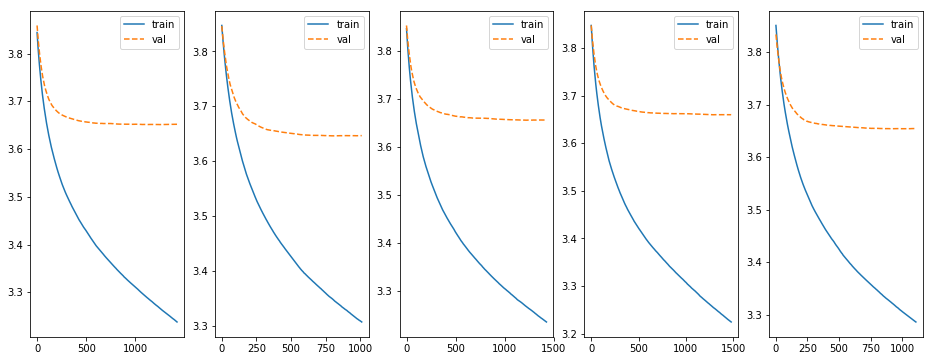

In [249]:
clf = LGBMRegressor(
    boosting_type='gbdt',
    num_leaves=31,
    max_depth=-1,
    learning_rate=0.01,
    n_estimators=10000,
    objective='regression',
    metric=['rmse'],
    min_split_gain=0.0,
    min_child_weight=0.001,
    min_child_samples=30,
    subsample=1.0,
    colsample_bytree=1.0,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=4590,
    n_jobs=-1,
)

NFOLD = 5
skf = StratifiedKFold(n_splits=NFOLD, shuffle=True, random_state=4590)

oof_train = np.zeros(len(df_train))
oof_test = np.zeros(len(df_test))

feature_importance_df = pd.DataFrame()
loss_csv = []
plt.figure(figsize=(16, 6))

for fold_, (trn_idx, val_idx) in enumerate(skf.split(df_train,df_train['outliers'].values)):
    print("fold {}".format(fold_))
    clf.fit(df_train.iloc[trn_idx][features], target_have_outliers.iloc[trn_idx],
            eval_set=[(df_train.iloc[trn_idx][features], target_have_outliers.iloc[trn_idx]),
                      (df_train.iloc[val_idx][features], target_have_outliers.iloc[val_idx])],
            eval_metric=['rmse'], early_stopping_rounds=200, verbose=True)
    val_pre = clf.predict(df_train.iloc[val_idx][features])
    oof_train[val_idx] = val_pre
    test_pre = clf.predict(df_test[features])
    oof_test += test_pre/NFOLD

    len_n = len(clf.evals_result_['valid_0']['rmse'])
    plt.subplot(1, 5, fold_ + 1)
    plt.plot(range(len_n), clf.evals_result_['valid_0']['rmse'], '-')
    plt.plot(range(len_n), clf.evals_result_['valid_1']['rmse'], '--')
    plt.legend(['train', 'val'])

    loss_csv.append(clf.best_score_['valid_1']['rmse'])
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

mean_loss = np.mean(loss_csv)
print('mean loss:', mean_loss)
plt.show()


In [251]:
nowtime = datetime.now().strftime('%Y%m%d_%H%M')

sub_df = pd.DataFrame({"card_id":df_test["card_id"].values})
sub_df["target"] = oof_test
sub_df.to_csv("result/lgb_sub_"+ nowtime + '_meanloss' + str(mean_loss) +".csv", index=False)